In [1]:
''' 
 I borrowed a lot from Tensorflow official tutorial
 https://www.tensorflow.org/tutorials/text/nmt_with_attention
'''

import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time


#################### Ignore from this part to ####################


# Download the file
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

# Converts the unicode file to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w

# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

  return zip(*word_pairs)

en, sp = create_dataset(path_to_file, None)

def max_length(tensor):
    return max(len(t) for t in tensor)

def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

def load_dataset(path, num_examples=None):
    # creating cleaned input, output pairs
    targ_lang, inp_lang = create_dataset(path, num_examples)
    
    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

# Try experimenting with the size of that dataset
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print("%d ----> %s" % (t, lang.index_word[t]))
    

#################### this part. ####################


In [2]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256 # You compress the 9414 dimensional input vectors into 256 dimensional vectors. '''
units = 1024 # The dimension of the hidden state/vector. '''
vocab_inp_size = len(inp_lang.word_index)+1 # 9414 '''
vocab_tar_size = len(targ_lang.word_index)+1 # 4935 '''

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [31]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    '''
      In the decoder part, you get an embedding vector for an input token every time step. 
      You have to calculate attentions using this class at EVERY TIME STEP. 
      'query' is the hidden state of an RNN cell at the time in the decoder part, whose size is (batch_size, 1, 1024).
      'values' is the outputs of the encoder part, whose size is (batch_size, 16, 1024). 
      (*The length of the input is not necessarily 16.)
      
      Attention mehcanism calculates relevances of a query and values with a certain function. 
      There are several functions for calculating the relevances, and in this implementation 
      we use Bahdanau"s additive style. 
    '''
    
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    
    '''
      In this implementation, you always need to consider time steps. 
    '''
    query_with_time_axis = tf.expand_dims(query, 1)

    '''
      You get the attentions between the query and outputs of the encoder below.
      In short, you compare the a word in the decoder with the input. 
      This is equivalent to finding the corresponding words in the original language, 
      when you are going to write a word in the target language. 
    '''
    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(query_with_time_axis)))

    '''
      You normalize the score calculated above with a softmax function so that the usm of its values is 1. 
    '''
    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    '''
      You reweight the outputs of the encoder with attention scores.
      The shape of the resulitng 'context_vector' is (64, 16, 1024)
    '''
    context_vector = attention_weights * values 
    '''
      You calculate the weighted average of the reweighted vectors above. 
      Thus the size of the shape of the resulting 'context_vector' is (64, 1024). 
    '''
    context_vector = tf.reduce_sum(context_vector, axis=1) # You take a weighted average of c

    return context_vector, attention_weights

In [32]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    '''
     As well as 'Encoder' class, the shape of inputs of 'Decoder' is [batch, timesteps, feature]. 
     https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU
     
     But you have to keep it in mind that you input a token every time step, the input is 
     (batch_size, 1, embedding_dim). 
    '''
    
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))
    
    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [33]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

In [34]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [35]:
checkpoint_dir = './training_checkpoints_check'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [36]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)


In [37]:
#@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  '''
    You input a (batch size, max input length) (=(64, 16)) tensor as an input
    and a (batch size, max output length) (=(64, 11)) as an output, and get a loss. 
  '''
    
  with tf.GradientTape() as tape:
    '''    
      You put a batch of input sentences as a (64, 16) tensor. 
    '''
    enc_output, enc_hidden = encoder(inp, enc_hidden)
    #print('The shape of the input is ' + str(inp.shape))
    #print('The shape of the output is ' + str(enc_output.shape))
    '''
      You pass the last hidden state/vector of the encoder to the decoder as its 
      inittial layer.
    '''
    
    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)
    
    '''
    In the encoder part you pass the whole sentence as an input, 
    whereas in the decoder part, you pass a word every time step in the loop below.  
    '''
    
    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, 
                                           dec_hidden, 
                                           enc_output) # You need encoder outputs to calculate attentions. 

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  '''
  Updating the weigths with the three lines below.   
  '''
  variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss


In [39]:
'''
  In this implementation, during training the 'Encoder' class gets a (64, 16) tensor as an input, 
  and it gives out a (64, 16, 1024) tensor as an output. That means the class gets the whole sentence
  as a sequence of integers, and gives out a 1024-dim vector every every times step, I mean each token. 
'''

class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz # 64 '''
    self.enc_units = enc_units  # 24000 // 64 = 375 '''
    
    '''
      As I explained in the last article, you propagate input 9414 dimensional vectors to 256 embedding vectors. 
    '''
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim) # (9414, 256)
    
    '''
    We use a RNN model named GRU for this seq2seq translation model. 
    All you have to keep in mind is, in this implentation, at time step t, one GRU cell takes 'embedding_dim'(=256) 
    dimensional vector as an input, and gives out a 16 dimensional (the maximum size of input sentences) output vector 
    and succeeds a hidden state/vector to the next GRU cell.  
    '''
    
    self.gru = tf.keras.layers.GRU(self.enc_units, # 1024: the dimension of the hidden vector/state. '''
                                   return_sequences=True, 
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    
    '''
     tf.keras.layers.GRU class gets [batch, timesteps, feature] sized tensors as inputs. 
     https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU
    '''
    output, state = self.gru(x, initial_state = hidden)
    
    #print(output[0][-1].shape)
    #print(output[0][-1])
    #print(state[0][-1].shape)
    #print(state[0][-1].shape)
    
    print(output[0].shape)
    print(output[0])
    #print(state[0].shape)
    #print(state[0].shape)
    
    return output, state

  '''
  '''
  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))


'''
  You construct an 'Encoder' calss as below. 
  One cell get a 9414 dimensional one-hot vector, and i
'''
encoder = Encoder(vocab_inp_size, # 9414 '''
                  embedding_dim, # 256 '''
                  units, # 1024 '''
                  BATCH_SIZE # 24000 '''
                 )

In [40]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()
  # You initialize the 'unit' dimensional hidden layer (1024 dimensional) as a 
  # 'unit' dimensional zero vector. 
  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    '''
     You input a (batch size, max input length) (=(64, 16)) matrix as an input
     and a (batch size, max output length) (=(64, 11)) as an output, and get a loss. 
     'enc_hidden' is the last 'units' dimensional hidden state vector (1024 dimensional) of the encoder. 
    '''
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))


(16, 1024)
tf.Tensor(
[[-7.37113087e-03  1.21182099e-03  8.11642874e-03 ...  1.26163680e-02
   1.19298592e-03 -8.94958939e-05]
 [-4.94148443e-03 -4.60306043e-03  1.12159923e-02 ...  1.00716576e-03
   4.23612166e-03  3.75545281e-03]
 [-1.23659205e-02 -1.16833411e-02  9.15687997e-03 ... -3.08977743e-03
   2.20410526e-03 -3.67979729e-03]
 ...
 [-8.98296386e-03 -6.01127045e-04 -3.44357197e-03 ...  1.37308678e-02
  -2.25335918e-02 -2.26321537e-03]
 [-8.78430251e-03 -5.30302175e-04 -3.60945659e-03 ...  1.37757976e-02
  -2.29563843e-02 -2.11008592e-03]
 [-8.64941161e-03 -5.04855881e-04 -3.71071370e-03 ...  1.38164181e-02
  -2.32086629e-02 -1.99388107e-03]], shape=(16, 1024), dtype=float32)
Epoch 1 Batch 0 Loss 4.4253
(16, 1024)
tf.Tensor(
[[-6.81227352e-03  9.37089906e-04  7.48969428e-03 ...  1.30769545e-02
   5.13487321e-04  7.15432339e-04]
 [-1.35112181e-02 -9.13844560e-04 -2.80277198e-03 ...  1.26966685e-02
  -2.11664755e-03 -9.50364047e-04]
 [ 4.47974820e-03 -9.03268345e-03 -1.05733601e-0

(16, 1024)
tf.Tensor(
[[-6.6554034e-03  3.7866451e-03  7.9448577e-03 ...  1.0728263e-02
   1.2846125e-03 -8.6839435e-05]
 [-5.7855691e-04 -4.9977335e-03  6.4257393e-03 ...  2.9304603e-03
   6.4557337e-04  7.5383619e-03]
 [ 2.1864736e-02 -7.1089407e-03 -8.3773853e-03 ...  1.4187939e-02
  -2.8864548e-03  9.9842227e-04]
 ...
 [ 9.9998999e-01 -9.8658043e-01 -9.9991465e-01 ...  9.9837178e-01
  -9.9998194e-01  9.9931777e-01]
 [ 9.9999106e-01 -9.9221909e-01 -9.9993497e-01 ...  9.9929190e-01
  -9.9998450e-01  9.9969560e-01]
 [ 9.9999160e-01 -9.9542391e-01 -9.9994183e-01 ...  9.9965632e-01
  -9.9998581e-01  9.9981880e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-5.3054644e-03  2.2465175e-03  6.5380242e-03 ...  1.2196975e-02
  -1.0044177e-04  1.4193601e-03]
 [-1.3330420e-03  6.2140767e-03 -1.6464347e-03 ...  3.9124470e-03
  -5.0399895e-03  4.0703244e-03]
 [ 9.9338600e-03 -3.6277215e-03 -1.6593726e-02 ...  1.5891906e-02
  -2.0560170e-02  1.2854016e-02]
 ...
 [ 9.9998981e-01 -9.

(16, 1024)
tf.Tensor(
[[ 1.3661616e-03 -5.0880732e-03 -1.6121678e-04 ...  1.8904733e-02
  -6.8566152e-03  8.4658293e-03]
 [ 1.8459158e-02 -1.8743096e-02 -2.7827639e-02 ...  2.9110573e-02
  -1.6039750e-02  1.5363149e-02]
 [ 5.5014029e-02 -4.1468441e-02 -4.8362594e-02 ...  4.6246115e-02
  -4.3808334e-02  2.6132056e-02]
 ...
 [ 9.9998116e-01 -9.9953002e-01 -9.9990308e-01 ...  9.9980032e-01
  -9.9981451e-01  9.9975139e-01]
 [ 9.9998260e-01 -9.9955577e-01 -9.9991119e-01 ...  9.9981141e-01
  -9.9992216e-01  9.9976975e-01]
 [ 9.9998355e-01 -9.9957240e-01 -9.9991584e-01 ...  9.9981987e-01
  -9.9996108e-01  9.9978262e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 1.9231102e-03 -5.7440358e-03 -7.5032882e-04 ...  1.9566728e-02
  -7.4740173e-03  9.0958755e-03]
 [ 2.4975775e-02 -1.3291640e-02 -1.3685813e-02 ...  3.1493928e-02
  -1.0347493e-02  2.0154132e-02]
 [ 6.2197845e-02 -4.6899229e-02 -5.8590829e-02 ...  6.2490493e-02
  -4.6386577e-02  5.0509386e-02]
 ...
 [ 9.9998146e-01 -9.

(16, 1024)
tf.Tensor(
[[ 0.00628925 -0.01125865 -0.00537073 ...  0.02501741 -0.01262295
   0.01420113]
 [ 0.03860332 -0.02761829 -0.02764842 ...  0.0457646  -0.03094661
   0.03149275]
 [ 0.09815054 -0.07205442 -0.08266723 ...  0.08548953 -0.08678012
   0.07320655]
 ...
 [ 0.99998313 -0.99971724 -0.999502   ...  0.9998919  -0.9996564
   0.99973285]
 [ 0.9999844  -0.99972624 -0.99973834 ...  0.9998947  -0.9998454
   0.9997428 ]
 [ 0.9999851  -0.99973315 -0.9998417  ...  0.9998969  -0.99992776
   0.9997506 ]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 0.00644726 -0.01147701 -0.00552631 ...  0.02522779 -0.01282789
   0.0144045 ]
 [ 0.04083078 -0.01861355 -0.0295526  ...  0.03575181 -0.02768114
   0.02896594]
 [ 0.08869207 -0.06350903 -0.07776296 ...  0.07755802 -0.0920486
   0.07404718]
 ...
 [ 0.9999824  -0.99972284 -0.9988923  ...  0.9998918  -0.9995637
   0.9997366 ]
 [ 0.99998474 -0.99973166 -0.9994333  ...  0.99989516 -0.9998049
   0.9997473 ]
 [ 0.99998575 -0.99973834

(16, 1024)
tf.Tensor(
[[ 0.00698587 -0.01273263 -0.00600842 ...  0.02611453 -0.01379731
   0.01519475]
 [ 0.03537285 -0.02934837 -0.03217799 ...  0.03871372 -0.04040385
   0.03106239]
 [ 0.1035378  -0.0915947  -0.09572688 ...  0.08839075 -0.10898312
   0.07195958]
 ...
 [ 0.9999325  -0.9998555  -0.99988943 ...  0.9999054  -0.99691063
   0.9997146 ]
 [ 0.9999689  -0.9998592  -0.99989575 ...  0.9999077  -0.99824107
   0.9997271 ]
 [ 0.9999821  -0.99986255 -0.9998983  ...  0.9999095  -0.9989977
   0.9997337 ]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 0.00710241 -0.01291009 -0.006122   ...  0.02628584 -0.01396125
   0.01536675]
 [ 0.02528408 -0.03293401 -0.03375696 ...  0.04110256 -0.04592874
   0.03188889]
 [ 0.09685954 -0.08438417 -0.08986565 ...  0.09451117 -0.10717039
   0.06483822]
 ...
 [ 0.9997982  -0.9998559  -0.99988353 ...  0.9998987  -0.99710107
   0.9996866 ]
 [ 0.999912   -0.99985975 -0.9998907  ...  0.9999012  -0.99839413
   0.99970555]
 [ 0.99995804 -0.9998

(16, 1024)
tf.Tensor(
[[ 0.00629851 -0.01225423 -0.00526697 ...  0.02525905 -0.01343341
   0.01447999]
 [ 0.04200698 -0.04307798 -0.04930187 ...  0.05252039 -0.04448603
   0.03716048]
 [ 0.12030381 -0.11076552 -0.11409734 ...  0.11854362 -0.13784057
   0.0863036 ]
 ...
 [ 0.9970013  -0.9998853  -0.99976254 ...  0.9997911  -0.93224144
   0.8941733 ]
 [ 0.99824584 -0.9998902  -0.99982464 ...  0.9997998  -0.9454427
   0.91361415]
 [ 0.9989708  -0.99989396 -0.99984795 ...  0.9998058  -0.95607007
   0.9294869 ]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 0.00630509 -0.01227703 -0.00526469 ...  0.0252499  -0.01347297
   0.01450758]
 [ 0.04724642 -0.04244307 -0.04968374 ...  0.05813437 -0.0371869
   0.0395283 ]
 [ 0.12537675 -0.11176959 -0.11092269 ...  0.10515393 -0.11839363
   0.08530423]
 ...
 [ 0.9949746  -0.9998735  -0.99961674 ...  0.9997504  -0.90612614
   0.8291821 ]
 [ 0.9969034  -0.9998798  -0.99975926 ...  0.999764   -0.922109
   0.8535227 ]
 [ 0.99808705 -0.9998847

(16, 1024)
tf.Tensor(
[[ 0.00715039 -0.01335155 -0.00594998 ...  0.02617609 -0.01478241
   0.01608322]
 [ 0.0413131  -0.03437384 -0.03157979 ...  0.03882558 -0.04473304
   0.03317165]
 [ 0.12258568 -0.08700174 -0.08676989 ...  0.08403572 -0.10053856
   0.07157969]
 ...
 [ 0.9998144  -0.9998584  -0.9917859  ...  0.86258405 -0.99977267
   0.99751455]
 [ 0.99992144 -0.9998676  -0.99523807 ...  0.88537043 -0.99991155
   0.99766886]
 [ 0.99996305 -0.9998742  -0.99718106 ...  0.90429384 -0.99996305
   0.99777865]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 0.00710984 -0.01331599 -0.00591385 ...  0.02614591 -0.01477197
   0.01608881]
 [ 0.04401008 -0.04485299 -0.04957538 ...  0.05374595 -0.04741179
   0.04001675]
 [ 0.1210202  -0.10204425 -0.09299833 ...  0.11052004 -0.11686395
   0.09017617]
 ...
 [ 0.999911   -0.99986386 -0.9925158  ...  0.8406676  -0.99986184
   0.9974785 ]
 [ 0.99996156 -0.9998725  -0.99567187 ...  0.8642942  -0.9999467
   0.99762684]
 [ 0.9999796  -0.9998

(16, 1024)
tf.Tensor(
[[ 0.00747155 -0.01415468 -0.0057473  ...  0.02639242 -0.01543037
   0.01745817]
 [ 0.04184329 -0.03315666 -0.03647305 ...  0.04052571 -0.05081889
   0.037341  ]
 [ 0.09857894 -0.08412717 -0.06867255 ...  0.06584779 -0.10532895
   0.05370912]
 ...
 [ 0.9963237  -0.99970657 -0.8621713  ...  0.98818195 -0.9929379
   0.9710806 ]
 [ 0.9982059  -0.9997465  -0.8996071  ...  0.99209154 -0.9965119
   0.97298974]
 [ 0.9991233  -0.99976957 -0.9267118  ...  0.9939174  -0.9982792
   0.9741237 ]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 0.00749912 -0.01421593 -0.00569303 ...  0.02634634 -0.01544931
   0.01756462]
 [ 0.05941097 -0.05741192 -0.04387935 ...  0.05284197 -0.07239528
   0.06262027]
 [ 0.15397696 -0.12931153 -0.10599732 ...  0.12014671 -0.15668708
   0.11940211]
 ...
 [ 0.9943156  -0.99965465 -0.88247997 ...  0.99071497 -0.994894
   0.96287006]
 [ 0.9967832  -0.99968934 -0.9119015  ...  0.99252796 -0.99734205
   0.96436423]
 [ 0.99817955 -0.99971163

(16, 1024)
tf.Tensor(
[[ 0.00760268 -0.01472439 -0.00520822 ...  0.02610571 -0.01570584
   0.01895824]
 [ 0.03492128 -0.04767695 -0.03634755 ...  0.04758664 -0.05626529
   0.03942319]
 [ 0.1245324  -0.11867492 -0.08828942 ...  0.10682248 -0.13288936
   0.08327999]
 ...
 [ 0.9939405  -0.9997542  -0.99570686 ...  0.9970863  -0.999766
   0.9984725 ]
 [ 0.99671245 -0.99976397 -0.9958528  ...  0.997438   -0.9999247
   0.9985405 ]
 [ 0.99821377 -0.99976915 -0.9959416  ...  0.99759954 -0.9999704
   0.9985843 ]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 0.00748849 -0.01468662 -0.00517569 ...  0.02609215 -0.01568456
   0.01895624]
 [ 0.03569933 -0.02750375 -0.02096095 ...  0.04367491 -0.03547532
   0.02763417]
 [ 0.04997378 -0.03616771 -0.02883797 ...  0.05405983 -0.05329586
   0.01999912]
 ...
 [ 0.9914405  -0.99978286 -0.9957012  ...  0.9962696  -0.999052
   0.9983647 ]
 [ 0.99585307 -0.99980533 -0.9960556  ...  0.99750215 -0.9997376
   0.9985172 ]
 [ 0.9979919  -0.9998152  -

(16, 1024)
tf.Tensor(
[[ 0.00751681 -0.01564103 -0.00579199 ...  0.02777213 -0.01685144
   0.02101344]
 [ 0.04004081 -0.04804888 -0.04375927 ...  0.05650536 -0.05451563
   0.05260612]
 [ 0.10984936 -0.1174989  -0.08798163 ...  0.09402046 -0.12375217
   0.07892277]
 ...
 [ 0.9973678  -0.99960035 -0.9972093  ...  0.9982517  -0.98410857
   0.9980822 ]
 [ 0.99875355 -0.99965984 -0.997381   ...  0.9988005  -0.9911713
   0.9981858 ]
 [ 0.99940246 -0.99968064 -0.99747485 ...  0.9989784  -0.99511576
   0.99824387]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 0.00772364 -0.01595966 -0.00597512 ...  0.02812529 -0.01713843
   0.02143777]
 [ 0.04342797 -0.0428404  -0.03630438 ...  0.05645943 -0.05686837
   0.05580309]
 [ 0.11491439 -0.09984778 -0.09222266 ...  0.10808591 -0.13683821
   0.08519225]
 ...
 [ 0.9956161  -0.99949026 -0.9968655  ...  0.99783945 -0.9759233
   0.9978097 ]
 [ 0.9977307  -0.9995818  -0.99708134 ...  0.99851906 -0.985454
   0.99793744]
 [ 0.9988192  -0.9996153

(16, 1024)
tf.Tensor(
[[ 0.00690962 -0.01594695 -0.00549995 ...  0.02794089 -0.01690913
   0.02239129]
 [ 0.04087899 -0.03856017 -0.04364944 ...  0.04835717 -0.04475868
   0.04112394]
 [ 0.09955465 -0.07590546 -0.07496636 ...  0.08001499 -0.10142972
   0.06683984]
 ...
 [ 0.9979189  -0.9983156  -0.99833035 ...  0.99644625 -0.9961464
   0.9973891 ]
 [ 0.9991256  -0.9991988  -0.99843687 ...  0.99735165 -0.9986614
   0.99754536]
 [ 0.9996187  -0.99948263 -0.998478   ...  0.99760664 -0.99953336
   0.99761534]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 0.00671883 -0.01570648 -0.00523983 ...  0.02759194 -0.01665066
   0.02223284]
 [ 0.04263031 -0.04836399 -0.04787115 ...  0.06510041 -0.05955958
   0.05806664]
 [ 0.10825074 -0.09799936 -0.0829865  ...  0.08941031 -0.1210469
   0.05914608]
 ...
 [ 0.9976164  -0.998227   -0.9981158  ...  0.9961002  -0.99806404
   0.9970957 ]
 [ 0.99891376 -0.99905705 -0.9982043  ...  0.99673903 -0.99934995
   0.9972316 ]
 [ 0.9994904  -0.999351

(16, 1024)
tf.Tensor(
[[ 0.00436841 -0.01435659 -0.00429066 ...  0.02648601 -0.01545517
   0.02132184]
 [ 0.00629389 -0.01064458 -0.01836194 ...  0.03170875 -0.00383654
   0.01704994]
 [ 0.03587732 -0.02908499 -0.02809822 ...  0.0290572  -0.02885251
   0.02482707]
 ...
 [ 0.9740721  -0.96838987 -0.9961988  ...  0.96053827 -0.9823011
   0.9949914 ]
 [ 0.9841995  -0.9832376  -0.99821013 ...  0.98488086 -0.9937223
   0.9966569 ]
 [ 0.99037135 -0.9909448  -0.99854106 ...  0.9919864  -0.99780107
   0.9970742 ]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 0.00433403 -0.01437912 -0.00425468 ...  0.02646255 -0.01542793
   0.02143634]
 [ 0.05711528 -0.08512946 -0.10359117 ...  0.11761814 -0.09482472
   0.08571865]
 [ 0.19511236 -0.23080547 -0.2793368  ...  0.25743437 -0.28447866
   0.2854108 ]
 ...
 [ 0.99801695 -0.9982828  -0.99856627 ...  0.9956491  -0.9999341
   0.99747413]
 [ 0.9988787  -0.99879277 -0.99858475 ...  0.9957576  -0.999972
   0.9975028 ]
 [ 0.9993484  -0.9990442 

(16, 1024)
tf.Tensor(
[[ 0.00265717 -0.01358958 -0.00303028 ...  0.02496491 -0.01445887
   0.02134079]
 [ 0.04173289 -0.05765021 -0.05102994 ...  0.0567581  -0.06027599
   0.05739821]
 [ 0.11748829 -0.11212142 -0.11215967 ...  0.11122295 -0.15372786
   0.10408609]
 ...
 [ 0.9998806  -0.9996228  -0.99910116 ...  0.99802756 -0.99999356
   0.99772125]
 [ 0.99990225 -0.9996781  -0.99910814 ...  0.9980705  -0.999994
   0.9977315 ]
 [ 0.99991035 -0.9996965  -0.9991129  ...  0.99809754 -0.99999404
   0.99773663]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 0.00245556 -0.01337797 -0.00285745 ...  0.02472683 -0.01426145
   0.02113152]
 [ 0.02559741 -0.03463623 -0.02233763 ...  0.03531154 -0.03665164
   0.04349548]
 [ 0.0683822  -0.06579099 -0.03897596 ...  0.04847946 -0.09868661
   0.04216985]
 ...
 [ 0.999884   -0.99965715 -0.99921113 ...  0.9982502  -0.99999374
   0.9977729 ]
 [ 0.9999154  -0.9997381  -0.99922013 ...  0.9983174  -0.9999952
   0.9977919 ]
 [ 0.999926   -0.999762

(16, 1024)
tf.Tensor(
[[ 0.00118862 -0.01163363 -0.00102753 ...  0.02259921 -0.01246641
   0.01977211]
 [ 0.03893489 -0.07255431 -0.10386188 ...  0.10576688 -0.07858145
   0.06580684]
 [ 0.14301032 -0.21394807 -0.2586858  ...  0.20264177 -0.23192455
   0.23882629]
 ...
 [ 0.99993294 -0.99974823 -0.9987532  ...  0.9966997  -0.9999923
   0.99604946]
 [ 0.99993455 -0.9997531  -0.9987593  ...  0.99678427 -0.9999925
   0.99608034]
 [ 0.9999356  -0.99975514 -0.99876356 ...  0.9968163  -0.99999255
   0.9961031 ]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 0.00118789 -0.01177704 -0.00121254 ...  0.02286186 -0.01262944
   0.01987376]
 [ 0.0212445  -0.03773305 -0.03535176 ...  0.04623482 -0.04171313
   0.04621005]
 [ 0.08104169 -0.08095582 -0.06253864 ...  0.06995853 -0.09181997
   0.04606182]
 ...
 [ 0.9999604  -0.99986076 -0.99915487 ...  0.9900712  -0.99999446
   0.99605656]
 [ 0.99996495 -0.9998853  -0.9992165  ...  0.9953131  -0.9999965
   0.996271  ]
 [ 0.999967   -0.999892

(16, 1024)
tf.Tensor(
[[-2.4035388e-04 -1.1064469e-02 -4.9031863e-04 ...  2.2458062e-02
  -1.2215514e-02  1.9702915e-02]
 [ 1.6816465e-02 -2.6656013e-02 -1.6041847e-02 ...  2.8051876e-02
  -2.8149925e-02  3.5564337e-02]
 [ 5.7182934e-02 -6.3830741e-02 -4.1127987e-02 ...  3.4132868e-02
  -6.7558281e-02  2.8703637e-02]
 ...
 [ 9.9995100e-01 -9.9974179e-01 -9.9952227e-01 ...  9.9611050e-01
  -9.9999344e-01  9.9448317e-01]
 [ 9.9995959e-01 -9.9980104e-01 -9.9954724e-01 ...  9.9784464e-01
  -9.9999660e-01  9.9482471e-01]
 [ 9.9996281e-01 -9.9981767e-01 -9.9955684e-01 ...  9.9821717e-01
  -9.9999708e-01  9.9498421e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-4.5719929e-04 -1.0956925e-02 -4.0206514e-04 ...  2.2370106e-02
  -1.2159989e-02  1.9627668e-02]
 [ 3.1198770e-02 -2.2184968e-02 -4.6755146e-02 ...  5.0285853e-02
  -5.0536919e-02  5.4245871e-02]
 [ 9.1513291e-02 -9.5409535e-02 -1.0092537e-01 ...  8.8496581e-02
  -1.3092124e-01  7.6425306e-02]
 ...
 [ 9.9995887e-01 -9.

(16, 1024)
tf.Tensor(
[[-0.00420389 -0.00709948  0.00305665 ...  0.01849476 -0.00890527
   0.01624109]
 [ 0.00495838 -0.01500888 -0.00656193 ...  0.0180745  -0.01618525
   0.02690195]
 [ 0.04178388 -0.02887368 -0.02993603 ...  0.03359663 -0.0462027
   0.02362238]
 ...
 [ 0.9998412  -0.99977505 -0.9994499  ...  0.99641705 -0.99999607
   0.9903977 ]
 [ 0.999879   -0.9997883  -0.9994783  ...  0.99665356 -0.999997
   0.9908109 ]
 [ 0.999896   -0.9997955  -0.9994959  ...  0.99674416 -0.9999969
   0.9910508 ]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.00425012 -0.00682884  0.00343744 ...  0.01806535 -0.00858037
   0.01612816]
 [ 0.01983461 -0.03310319 -0.03008617 ...  0.02505402 -0.02935086
   0.03983798]
 [ 0.05960187 -0.06062941 -0.07435681 ...  0.0691971  -0.08864044
   0.0730997 ]
 ...
 [ 0.99974245 -0.9996673  -0.99937385 ...  0.9953492  -0.9999953
   0.9890261 ]
 [ 0.9998057  -0.9996831  -0.99939823 ...  0.9955694  -0.9999962
   0.9893998 ]
 [ 0.9998368  -0.99969244 

(16, 1024)
tf.Tensor(
[[-0.00307651 -0.0082202   0.00309639 ...  0.02009369 -0.01012806
   0.01879603]
 [ 0.00484532 -0.01275747 -0.00439438 ...  0.01784739 -0.01582064
   0.02923433]
 [ 0.02152873 -0.02304286 -0.01893016 ...  0.02605326 -0.04360741
   0.0181778 ]
 ...
 [ 0.99969614 -0.99931026 -0.9991919  ...  0.98574007 -0.99999034
   0.96671724]
 [ 0.999756   -0.9993611  -0.9992567  ...  0.9881249  -0.99999547
   0.9681076 ]
 [ 0.99978626 -0.9993861  -0.99927497 ...  0.98868567 -0.9999963
   0.9685341 ]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.00335212 -0.0081129   0.0031393  ...  0.02014509 -0.01007872
   0.01870401]
 [ 0.02066261 -0.05879853 -0.1195841  ...  0.09996017 -0.06092463
   0.05915508]
 [ 0.06681447 -0.1734933  -0.32367676 ...  0.17466192 -0.1721999
   0.14824942]
 ...
 [ 0.9966238  -0.9978849  -0.9991256  ...  0.9821611  -0.99997455
   0.9383311 ]
 [ 0.9977013  -0.9979337  -0.99912983 ...  0.9824391  -0.999975
   0.9386612 ]
 [ 0.9982674  -0.9979659

(16, 1024)
tf.Tensor(
[[-0.00439446 -0.00776808  0.00316305 ...  0.02125864 -0.0106048
   0.01995908]
 [ 0.0124335  -0.01064192 -0.02000271 ...  0.03181368 -0.03858913
   0.04803276]
 [ 0.06149416 -0.05066223 -0.05609579 ...  0.07084145 -0.09751555
   0.04848303]
 ...
 [ 0.999252   -0.9973892  -0.9993609  ...  0.96972454 -0.9999752
   0.95509166]
 [ 0.99939907 -0.9973319  -0.99939406 ...  0.9714049  -0.99998915
   0.9565958 ]
 [ 0.9994873  -0.9972934  -0.99940836 ...  0.97197866 -0.99999225
   0.957357  ]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.00427734 -0.00777368  0.00321548 ...  0.02127409 -0.0106632
   0.02016267]
 [ 0.01231638 -0.01422512 -0.02659348 ...  0.04892414 -0.0312868
   0.04274175]
 [ 0.00740326  0.00839269 -0.0183419  ...  0.00655223 -0.02750292
  -0.00232664]
 ...
 [ 0.9986627  -0.99644935 -0.9992223  ...  0.9573252  -0.99990207
   0.9534444 ]
 [ 0.99896014 -0.99632853 -0.99930984 ...  0.96255946 -0.99996996
   0.95627284]
 [ 0.99915236 -0.9962359

(16, 1024)
tf.Tensor(
[[-0.00525384 -0.00680615  0.00480928 ...  0.02062091 -0.00972079
   0.02023381]
 [ 0.00233303 -0.01838808 -0.02030711 ...  0.04897392 -0.03690344
   0.04306544]
 [ 0.02770701 -0.04661323 -0.06642278 ...  0.06712392 -0.08339378
   0.05827219]
 ...
 [ 0.9954796  -0.99828994 -0.9995415  ...  0.9906996  -0.9997376
   0.9606503 ]
 [ 0.9968535  -0.99847835 -0.9995891  ...  0.9921476  -0.9999273
   0.9623496 ]
 [ 0.9977827  -0.9985665  -0.9996058  ...  0.99261737 -0.9999765
   0.96286154]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.00563789 -0.00670804  0.00485754 ...  0.02078099 -0.00975945
   0.02003694]
 [-0.005918   -0.00193677  0.00406381 ...  0.0138112  -0.0059998
   0.03242072]
 [ 0.02278335 -0.01193284 -0.01677123 ...  0.0207394  -0.02585951
   0.02348425]
 ...
 [ 0.9981562  -0.99884844 -0.9996104  ...  0.9939283  -0.9998517
   0.9685756 ]
 [ 0.9987339  -0.99897116 -0.99964166 ...  0.99474216 -0.9999616
   0.9697419 ]
 [ 0.99910533 -0.99902475 

(16, 1024)
tf.Tensor(
[[-0.00928312 -0.00360329  0.00790856 ...  0.01843169 -0.00726213
   0.0183127 ]
 [-0.01467239  0.00560592  0.01055967 ...  0.0101071   0.00171469
   0.03089805]
 [ 0.00704812 -0.00849309 -0.01412974 ...  0.01922736 -0.03614183
   0.0396408 ]
 ...
 [ 0.98732316 -0.9929126  -0.99797136 ...  0.95653176 -0.9929205
   0.9326653 ]
 [ 0.98982215 -0.99349964 -0.99887574 ...  0.9803894  -0.99686164
   0.9414207 ]
 [ 0.9917389  -0.99373484 -0.99910456 ...  0.9876001  -0.9986161
   0.94429845]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.00919324 -0.00380982  0.00778465 ...  0.01880769 -0.00751685
   0.01857943]
 [-0.00139103 -0.00537656 -0.0158568  ...  0.04423334 -0.03476189
   0.05453674]
 [ 0.02313912 -0.03648842 -0.0638539  ...  0.05487205 -0.0786269
   0.0620967 ]
 ...
 [ 0.99022627 -0.9931078  -0.9989428  ...  0.97321117 -0.9979069
   0.9156871 ]
 [ 0.992592   -0.99368334 -0.99911094 ...  0.98145413 -0.9991282
   0.917993  ]
 [ 0.99432945 -0.9940095 

(16, 1024)
tf.Tensor(
[[-0.00939901 -0.00234211  0.00993122 ...  0.01645656 -0.00631333
   0.01781587]
 [ 0.00361858 -0.01287817 -0.01853892 ...  0.04287876 -0.02706551
   0.04505921]
 [ 0.01961986 -0.02620847 -0.05794983 ...  0.05481163 -0.07044943
   0.05373228]
 ...
 [ 0.98575926 -0.9854578  -0.99893713 ...  0.99733865 -0.9921458
   0.9901054 ]
 [ 0.98793393 -0.9870115  -0.99897677 ...  0.99741036 -0.9957869
   0.99033356]
 [ 0.98976254 -0.9881208  -0.9989964  ...  0.9974315  -0.9977362
   0.9904451 ]], shape=(16, 1024), dtype=float32)
Epoch 1 Batch 300 Loss 1.7486
(16, 1024)
tf.Tensor(
[[-9.3411235e-03 -2.4402791e-03  9.8464489e-03 ...  1.6576538e-02
  -6.4105624e-03  1.7824836e-02]
 [-1.1835342e-02  7.7849450e-03 -3.5424968e-03 ...  1.8517386e-02
  -9.0440712e-04  2.9382385e-02]
 [ 1.1326387e-02 -6.0216510e-03 -2.8544115e-02 ...  3.0939996e-02
  -2.3216421e-02  4.2785659e-02]
 ...
 [ 9.7404271e-01 -9.7966313e-01 -9.9896938e-01 ...  9.9772853e-01
  -9.8847431e-01  9.9212956e-01]
 [

(16, 1024)
tf.Tensor(
[[-0.00953925 -0.00151826  0.01154564 ...  0.01549866 -0.00541185
   0.01837391]
 [-0.0054851   0.00309984 -0.02651456 ...  0.04392901 -0.02120152
   0.0439899 ]
 [ 0.02588361 -0.02623204 -0.06663083 ...  0.06013142 -0.07975596
   0.07903372]
 ...
 [ 0.9992472  -0.9878536  -0.99905306 ...  0.9976963  -0.9993075
   0.99012995]
 [ 0.9992418  -0.9872024  -0.99904644 ...  0.99766916 -0.9996811
   0.9901808 ]
 [ 0.99923927 -0.9867958  -0.9990401  ...  0.99764776 -0.99984986
   0.99021304]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.00963748 -0.00150109  0.01145257 ...  0.01566058 -0.00550957
   0.0183902 ]
 [-0.01370574 -0.00784535 -0.00792939 ...  0.03537127 -0.02749326
   0.04419416]
 [ 0.01585549 -0.02774011 -0.06151726 ...  0.07363058 -0.07586706
   0.07433608]
 ...
 [ 0.9992151  -0.99183595 -0.99895185 ...  0.9975512  -0.9992624
   0.9892234 ]
 [ 0.9992571  -0.99144465 -0.99894446 ...  0.9975226  -0.9996786
   0.98930055]
 [ 0.99928236 -0.9912081

(16, 1024)
tf.Tensor(
[[-0.00820793 -0.00304451  0.00972898 ...  0.01729702 -0.00695027
   0.02012075]
 [ 0.00123127  0.00221985 -0.00902826 ...  0.03334168 -0.02895903
   0.04443749]
 [ 0.03867561 -0.03096829 -0.0417605  ...  0.04624769 -0.07729529
   0.0764905 ]
 ...
 [ 0.9976142  -0.91800237 -0.99868625 ...  0.99059075 -0.9957626
   0.98533845]
 [ 0.99744177 -0.9110441  -0.9986825  ...  0.9906193  -0.9975537
   0.9855267 ]
 [ 0.9973309  -0.9065737  -0.9986744  ...  0.9906104  -0.9985838
   0.9856395 ]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.00830183 -0.00295441  0.00995717 ...  0.01712995 -0.00691102
   0.02010628]
 [-0.01771977  0.01166185  0.01630389 ...  0.00641028  0.00533444
   0.03671132]
 [ 0.00855269  0.009578    0.0031656  ...  0.02219902 -0.01976155
   0.04809212]
 ...
 [ 0.9971651  -0.89548504 -0.9984454  ...  0.9886122  -0.99214375
   0.9852414 ]
 [ 0.9967989  -0.8808526  -0.99849623 ...  0.9889017  -0.99524295
   0.9856256 ]
 [ 0.99654543 -0.871380

(16, 1024)
tf.Tensor(
[[-0.00883036 -0.00223561  0.01103034 ...  0.01605416 -0.00634848
   0.02016667]
 [-0.00296962 -0.02692422 -0.09352029 ...  0.09774903 -0.03328714
   0.08885545]
 [-0.00167896 -0.05721518 -0.25987217 ...  0.10876036 -0.08144874
   0.14977151]
 ...
 [ 0.9926025  -0.8932558  -0.9977706  ...  0.9523746  -0.9989257
   0.9567255 ]
 [ 0.9924492  -0.8836962  -0.9978256  ...  0.9530329  -0.99938214
   0.9570815 ]
 [ 0.9923445  -0.8770101  -0.9978527  ...  0.9532868  -0.99962133
   0.95725846]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-8.7590944e-03 -2.2955260e-03  1.0934548e-02 ...  1.6177405e-02
  -6.4091650e-03  2.0302733e-02]
 [ 1.4685462e-03  6.8516373e-03  1.6616059e-02 ...  1.1523474e-02
  -2.1572834e-02  6.7523867e-02]
 [ 9.9594062e-03 -1.6949745e-03  2.0693988e-05 ...  2.7558690e-02
  -5.3055551e-02  6.5910958e-02]
 ...
 [ 9.9271142e-01 -8.4518659e-01 -9.9751103e-01 ...  9.8857421e-01
  -9.6875542e-01  9.8520744e-01]
 [ 9.9166298e-01 -8.2398337e-0

(16, 1024)
tf.Tensor(
[[-1.1278002e-02  5.4237462e-04  1.3664395e-02 ...  1.3499612e-02
  -3.3292207e-03  1.7900763e-02]
 [-1.0894939e-02  1.9137669e-02  1.5973700e-03 ...  1.4699090e-02
   7.6505616e-03  3.5791151e-02]
 [ 6.4425408e-03  1.1124160e-02 -2.1481590e-02 ...  2.6720220e-02
  -1.8968634e-02  5.6201149e-02]
 ...
 [ 9.9457109e-01 -6.6209567e-01 -9.9164581e-01 ...  9.8008484e-01
  -9.4365346e-01  9.8330164e-01]
 [ 9.9263662e-01 -5.8930641e-01 -9.9450898e-01 ...  9.8174179e-01
  -9.5276928e-01  9.8446065e-01]
 [ 9.9104714e-01 -5.3233552e-01 -9.9490154e-01 ...  9.8164970e-01
  -9.6030527e-01  9.8446852e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-1.1619182e-02  7.6044811e-04  1.3916134e-02 ...  1.3454188e-02
  -3.1918667e-03  1.7830342e-02]
 [-2.0355595e-02  1.3532819e-02  1.1228284e-02 ...  1.2370992e-02
   8.9567052e-03  3.0117486e-02]
 [-1.8701587e-02  2.8283203e-02  1.2416113e-02 ...  2.8091013e-03
  -2.6331400e-03  3.7093490e-02]
 ...
 [ 9.9593663e-01 -6.

(16, 1024)
tf.Tensor(
[[-0.00840649 -0.00157345  0.01188207 ...  0.01584934 -0.00520233
   0.02106822]
 [-0.02946786  0.02274182  0.01514829 ...  0.00293084  0.00992278
   0.02594633]
 [-0.04757918  0.05539331  0.02923963 ... -0.0215032   0.03619808
  -0.01108743]
 ...
 [ 0.99379104 -0.4372054  -0.9901178  ...  0.970306   -0.69800794
   0.9686674 ]
 [ 0.9937851  -0.3773083  -0.99361455 ...  0.9729035  -0.71477854
   0.9699222 ]
 [ 0.9937641  -0.33237305 -0.99450266 ...  0.97350127 -0.730656
   0.96982753]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.00886168 -0.00138596  0.01198812 ...  0.01569895 -0.00484201
   0.02065304]
 [-0.01103111  0.00658958 -0.01181065 ...  0.01069538  0.00484522
   0.04395223]
 [ 0.0146543  -0.00994164 -0.04202318 ...  0.03781553 -0.04125808
   0.07785851]
 ...
 [ 0.99678075 -0.47892985 -0.9969571  ...  0.9834282  -0.8759431
   0.9755303 ]
 [ 0.9964546  -0.4146647  -0.99737805 ...  0.9834539  -0.88682574
   0.9763714 ]
 [ 0.9961811  -0.369473

(16, 1024)
tf.Tensor(
[[-0.00857856 -0.00199382  0.01202612 ...  0.01524852 -0.00447369
   0.02008017]
 [-0.00945541  0.0070532  -0.01641508 ...  0.04149266 -0.00444615
   0.05268358]
 [-0.02142741  0.0099875  -0.04125714 ...  0.02962176 -0.01386748
   0.04564474]
 ...
 [ 0.9967158  -0.93836564 -0.997731   ...  0.9905004  -0.95436466
   0.98418117]
 [ 0.9960759  -0.9181489  -0.9978876  ...  0.9906089  -0.96006864
   0.98498183]
 [ 0.99554753 -0.9005837  -0.9979113  ...  0.99056226 -0.9650819
   0.985169  ]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-8.5289348e-03 -2.0468188e-03  1.1977852e-02 ...  1.5227692e-02
  -4.4675623e-03  2.0051090e-02]
 [-3.1549584e-02  2.2413379e-02  1.4484689e-02 ...  2.7791476e-03
   1.1384256e-02  2.6838280e-02]
 [-1.8633142e-02  3.0115250e-02  2.6138499e-04 ...  3.8066688e-03
   1.5428066e-03  3.0862287e-02]
 ...
 [ 9.9669826e-01 -8.9148462e-01 -9.9466550e-01 ...  9.8365778e-01
  -7.9151237e-01  9.7763509e-01]
 [ 9.9633712e-01 -8.6790550e-0

(16, 1024)
tf.Tensor(
[[-0.00852843 -0.00235612  0.01263187 ...  0.0136832  -0.00381996
   0.01847018]
 [-0.00953612  0.01833647  0.02584639 ...  0.04244261 -0.00719465
   0.10756339]
 [-0.02218603  0.03891787  0.00459149 ...  0.05177245 -0.00874081
   0.11418436]
 ...
 [ 0.9963131  -0.9680349  -0.9888345  ...  0.98533666 -0.78102434
   0.9756901 ]
 [ 0.9956065  -0.96227676 -0.99152505 ...  0.98649126 -0.79010814
   0.97559315]
 [ 0.9950249  -0.95715684 -0.99210554 ...  0.9870034  -0.7988291
   0.975935  ]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-8.21389817e-03 -2.70712445e-03  1.23386364e-02 ...  1.38700865e-02
  -4.05153213e-03  1.87654234e-02]
 [-1.38384253e-02 -1.58782792e-03  2.58738920e-03 ...  2.24766918e-02
  -5.93573274e-03  5.50987422e-02]
 [ 1.49618834e-04 -6.28922367e-03 -1.52331498e-02 ...  3.57025303e-02
  -4.02898900e-02  6.85670078e-02]
 ...
 [ 9.95362639e-01 -9.66108620e-01 -9.93653297e-01 ...  9.88756418e-01
  -7.99298763e-01  9.79540229e-01]
 [ 9.9

(16, 1024)
tf.Tensor(
[[-0.00786588 -0.00392432  0.01157467 ...  0.01451668 -0.00431997
   0.01905305]
 [-0.01688541  0.00653849 -0.00435319 ...  0.03517688 -0.01665683
   0.06216604]
 [-0.03398144  0.02746982 -0.01434455 ...  0.03267501 -0.01144748
   0.05790452]
 ...
 [ 0.9933344  -0.952389   -0.9795096  ...  0.98862934 -0.8870316
   0.98335516]
 [ 0.9919759  -0.94221413 -0.98215526 ...  0.9886876  -0.8945258
   0.9828299 ]
 [ 0.9907561  -0.9328234  -0.98277944 ...  0.98849124 -0.9014368
   0.9825029 ]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.00790655 -0.00405614  0.01136687 ...  0.01478575 -0.00444304
   0.01907154]
 [-0.00574568  0.00607756 -0.0057213  ...  0.03062072 -0.01378843
   0.0524735 ]
 [-0.00450516  0.01175433 -0.03362367 ...  0.0395011  -0.03633886
   0.06305344]
 ...
 [ 0.99346846 -0.9528575  -0.99066675 ...  0.99090385 -0.91727173
   0.98570836]
 [ 0.9923634  -0.9434648  -0.9911493  ...  0.990687   -0.92362225
   0.9853277 ]
 [ 0.9913866  -0.934752

(16, 1024)
tf.Tensor(
[[-0.00887388 -0.00371135  0.01299424 ...  0.01423965 -0.00444494
   0.01836916]
 [ 0.00149097  0.00247256 -0.0116676  ...  0.03646057 -0.00860788
   0.0465463 ]
 [-0.01359382  0.02058258 -0.01429752 ...  0.01633736 -0.01107205
   0.03457773]
 ...
 [ 0.98952127 -0.88210547 -0.99448824 ...  0.99353206 -0.69211304
   0.98941374]
 [ 0.9876696  -0.8674456  -0.9950173  ...  0.9934675  -0.69782835
   0.98906636]
 [ 0.9859797  -0.85392535 -0.99520415 ...  0.99345154 -0.7035083
   0.9889304 ]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.00861565 -0.00398746  0.01281151 ...  0.01428759 -0.00458208
   0.01837998]
 [-0.00799401 -0.0022644  -0.00655693 ...  0.02978031 -0.00969396
   0.05903879]
 [ 0.01361663 -0.02059071 -0.05199316 ...  0.06472404 -0.06141378
   0.09477526]
 ...
 [ 0.9874053  -0.8738977  -0.9943709  ...  0.99284065 -0.6983677
   0.98856574]
 [ 0.9856933  -0.8622707  -0.99466956 ...  0.99274755 -0.7043086
   0.9883058 ]
 [ 0.98414963 -0.851406

(16, 1024)
tf.Tensor(
[[-0.00696965 -0.00498906  0.01142493 ...  0.01413694 -0.00471236
   0.01752835]
 [-0.03648757  0.03115199  0.05169604 ... -0.0192626   0.03166835
   0.02223786]
 [-0.03793733  0.04259847  0.04830278 ... -0.01575748  0.02863683
   0.01183958]
 ...
 [ 0.98858434 -0.7062225  -0.72663105 ...  0.97109205 -0.17807503
   0.9516311 ]
 [ 0.9864594  -0.70029044 -0.7540846  ...  0.9718462  -0.17960186
   0.9517898 ]
 [ 0.98440886 -0.6948198  -0.7714425  ...  0.97131985 -0.18113907
   0.95026815]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-7.0376471e-03 -5.0162086e-03  1.1321560e-02 ...  1.4288734e-02
  -4.7415863e-03  1.7557671e-02]
 [-1.6714482e-02  1.7607989e-02 -1.5974250e-02 ...  1.6311532e-02
   1.1807035e-02  1.9295137e-02]
 [-3.1152816e-02  2.2388421e-02 -1.1717050e-02 ...  9.6160173e-04
  -7.4066347e-03 -1.2027815e-02]
 ...
 [ 9.9479806e-01 -9.1794640e-01 -9.9117589e-01 ...  9.9009800e-01
  -7.0480841e-01  9.8730069e-01]
 [ 9.9383771e-01 -9.1288209e-

(16, 1024)
tf.Tensor(
[[-0.00521905 -0.00595746  0.01101358 ...  0.01353464 -0.00562204
   0.01693631]
 [-0.02288564 -0.00728017  0.00573075 ...  0.03207212 -0.01475982
   0.03400128]
 [-0.02641974  0.015791   -0.01597729 ...  0.03048525 -0.01835936
   0.02933684]
 ...
 [ 0.9925348  -0.92036504 -0.9682371  ...  0.9916679  -0.7882281
   0.9862691 ]
 [ 0.9900667  -0.90951306 -0.9724767  ...  0.9908844  -0.7920892
   0.9847992 ]
 [ 0.9877429  -0.89921457 -0.973958   ...  0.99038243 -0.79588556
   0.9839731 ]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.00464539 -0.00633769  0.01068607 ...  0.01398834 -0.0062234
   0.01747826]
 [ 0.02408493 -0.02954733 -0.0483032  ...  0.05985806 -0.04689087
   0.06620093]
 [ 0.0310522  -0.02295396 -0.07633143 ...  0.06614043 -0.0746369
   0.0747817 ]
 ...
 [ 0.9882016  -0.8839911  -0.9637371  ...  0.99228853 -0.79142976
   0.991343  ]
 [ 0.98567724 -0.8745515  -0.96680236 ...  0.99169135 -0.79630625
   0.99059397]
 [ 0.9833317  -0.865466 

(16, 1024)
tf.Tensor(
[[-0.00529367 -0.00634158  0.01167572 ...  0.01273787 -0.00570673
   0.01725238]
 [-0.02553095 -0.00896021  0.00480144 ...  0.03337736 -0.01509572
   0.03181417]
 [-0.02283387 -0.00577264 -0.026514   ...  0.04542415 -0.03833426
   0.05105962]
 ...
 [ 0.98337954 -0.8798206  -0.96832985 ...  0.9990222  -0.8329415
   0.99930906]
 [ 0.9794419  -0.859678   -0.96985245 ...  0.9989418  -0.83677065
   0.9992707 ]
 [ 0.9760164  -0.8412733  -0.97061384 ...  0.99889463 -0.8405114
   0.9992511 ]], shape=(16, 1024), dtype=float32)
Epoch 2 Batch 100 Loss 1.5244
(16, 1024)
tf.Tensor(
[[-0.00521759 -0.00664746  0.01102827 ...  0.01325895 -0.00598411
   0.01717556]
 [-0.02409818  0.00108336 -0.01198    ...  0.02086312 -0.00488464
   0.04016827]
 [-0.0350787  -0.0070926  -0.02002545 ...  0.03403705 -0.029782
   0.04361277]
 ...
 [ 0.9816251  -0.8767415  -0.9275607  ...  0.9991565  -0.7282154
   0.9993307 ]
 [ 0.97609574 -0.8577397  -0.936611   ...  0.9990579  -0.732572
   0.9992552

(16, 1024)
tf.Tensor(
[[-4.2215702e-03 -7.2092237e-03  1.0528709e-02 ...  1.3879022e-02
  -6.1330958e-03  1.7954048e-02]
 [-6.4691794e-03 -8.1230998e-03 -5.6399633e-03 ...  2.8364418e-02
  -1.6562862e-02  4.0990207e-02]
 [-1.0942716e-02  7.7330237e-03  2.3000408e-04 ...  1.0527978e-02
  -2.4176002e-02  2.6082048e-02]
 ...
 [ 9.7465867e-01 -8.1919360e-01 -9.1099370e-01 ...  9.9915427e-01
  -6.5085393e-01  9.9950284e-01]
 [ 9.7216028e-01 -8.0763859e-01 -9.2182845e-01 ...  9.9911952e-01
  -6.5402687e-01  9.9948734e-01]
 [ 9.6982819e-01 -7.9663843e-01 -9.3057787e-01 ...  9.9909288e-01
  -6.5718383e-01  9.9948072e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.0041783  -0.00696887  0.0108541  ...  0.0137342  -0.00597698
   0.01845504]
 [-0.02535285  0.02427887  0.01012183 ... -0.00473653  0.02649591
   0.0087625 ]
 [-0.00366359  0.00644178 -0.00281973 ...  0.0094276  -0.02436665
   0.0220028 ]
 ...
 [ 0.97433704 -0.79805917 -0.81151164 ...  0.99928176 -0.5602064
   0.9995

(16, 1024)
tf.Tensor(
[[-0.00220256 -0.0074353   0.00853645 ...  0.01495096 -0.0076451
   0.01974505]
 [-0.03450987  0.02687662  0.06659162 ... -0.0246313   0.03379816
   0.02941356]
 [-0.02724849  0.04139837  0.07189984 ... -0.00489428  0.02479152
   0.10123306]
 ...
 [ 0.894081   -0.32780868 -0.00349235 ...  0.99912035 -0.07974891
   0.9995934 ]
 [ 0.8933757  -0.3259956  -0.00562374 ...  0.99909145 -0.08052818
   0.9995743 ]
 [ 0.89267844 -0.32419413 -0.00766356 ...  0.99907213 -0.08131265
   0.99956274]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-2.3661898e-03 -6.9780028e-03  9.2265233e-03 ...  1.4309748e-02
  -7.3098885e-03  1.9735184e-02]
 [-9.1229714e-03 -6.4758048e-03 -1.8918285e-02 ...  3.0697949e-02
  -1.8495033e-02  3.0517630e-02]
 [ 1.0700863e-02 -8.3679799e-04 -7.2266436e-03 ...  5.4527458e-02
  -4.8150413e-02  1.4301838e-01]
 ...
 [ 9.8328090e-01 -8.0560648e-01 -8.7127554e-01 ...  9.9934626e-01
  -5.5452973e-01  9.9964982e-01]
 [ 9.7949839e-01 -7.9196888e-0

(16, 1024)
tf.Tensor(
[[-0.00338283 -0.00523291  0.01106035 ...  0.01099912 -0.0053817
   0.01586794]
 [ 0.01630592 -0.02774612 -0.0509443  ...  0.06886868 -0.05024103
   0.04804448]
 [ 0.03464639 -0.04140221 -0.0870308  ...  0.10771794 -0.09411202
   0.12092316]
 ...
 [ 0.9840898  -0.8120389  -0.9968928  ...  0.99867445 -0.8409779
   0.9994593 ]
 [ 0.9821009  -0.79965    -0.9968791  ...  0.9985996  -0.84486
   0.9994413 ]
 [ 0.9802197  -0.787544   -0.99685246 ...  0.99854827 -0.8486647
   0.9994305 ]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-2.8343191e-03 -5.7360507e-03  1.0124301e-02 ...  1.1811201e-02
  -5.9126536e-03  1.6202746e-02]
 [-1.7439319e-02  2.1696245e-02 -1.9280359e-02 ...  1.3703207e-02
   1.3238702e-02  6.2803668e-03]
 [-4.1478840e-03 -4.6922546e-04 -3.4559548e-02 ...  2.4546685e-02
  -2.7053431e-02  2.1198079e-02]
 ...
 [ 9.9040115e-01 -8.5450923e-01 -9.9796593e-01 ...  9.9856740e-01
  -9.1490090e-01  9.9948651e-01]
 [ 9.8849601e-01 -8.3615714e-01 -9.

(16, 1024)
tf.Tensor(
[[-0.0013864  -0.00673459  0.00756864 ...  0.01288976 -0.00697401
   0.01589852]
 [-0.03462315 -0.00358839  0.01825382 ...  0.03476042 -0.0091657
   0.02571402]
 [-0.04122806  0.02014811 -0.01099147 ...  0.03869605  0.00863124
   0.01532182]
 ...
 [ 0.9878192  -0.77634174 -0.9965273  ...  0.99908924 -0.8502463
   0.9995515 ]
 [ 0.9848554  -0.76500595 -0.9968816  ...  0.99897254 -0.8548969
   0.9995171 ]
 [ 0.9821274  -0.75395256 -0.9970593  ...  0.9989059  -0.8594552
   0.9995027 ]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-1.2863802e-03 -6.5730419e-03  8.1281504e-03 ...  1.2295677e-02
  -6.7059128e-03  1.5758209e-02]
 [-5.7048481e-03  7.6930760e-04 -4.1163728e-02 ...  3.2863587e-02
  -1.3898683e-02  2.3062885e-02]
 [-7.5148782e-03  9.6228253e-03 -3.2547243e-02 ...  1.7042262e-02
  -2.8849259e-02  2.0583231e-02]
 ...
 [ 9.8815346e-01 -8.2020807e-01 -9.9685603e-01 ...  9.9913925e-01
  -8.9709336e-01  9.9962628e-01]
 [ 9.8474729e-01 -8.0715656e-01 -

(16, 1024)
tf.Tensor(
[[-9.7217511e-05 -7.6068896e-03  8.5050352e-03 ...  1.2215072e-02
  -6.4860936e-03  1.6399823e-02]
 [ 1.0522294e-02  5.8845687e-03  3.5108820e-02 ...  4.7376242e-02
  -5.5644163e-03  1.6951057e-01]
 [-1.7621931e-02  2.9705744e-02  2.3865605e-02 ...  5.2887380e-02
   1.3713134e-02  1.3096711e-01]
 ...
 [ 9.6532083e-01 -6.8066305e-01 -9.4741207e-01 ...  9.9924707e-01
  -4.6170461e-01  9.9953067e-01]
 [ 9.5834935e-01 -6.7490464e-01 -9.4569963e-01 ...  9.9922454e-01
  -4.6367475e-01  9.9950927e-01]
 [ 9.5179904e-01 -6.6928446e-01 -9.4418484e-01 ...  9.9920791e-01
  -4.6564230e-01  9.9949676e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-1.2775337e-04 -7.5945347e-03  8.2622292e-03 ...  1.2268771e-02
  -6.3394415e-03  1.6132731e-02]
 [-2.8011641e-02  2.5074495e-02  2.3526959e-02 ... -8.6024432e-03
   2.5057545e-02  2.0601437e-03]
 [-3.2277323e-02  3.5369061e-02  2.7939431e-02 ... -1.3047877e-02
   2.1937024e-02 -1.8024327e-02]
 ...
 [ 9.6697581e-01 -6.

(16, 1024)
tf.Tensor(
[[-0.00196209 -0.00574351  0.00896765 ...  0.00998019 -0.00423099
   0.01263259]
 [-0.02709507  0.02214328  0.00111177 ... -0.00744653  0.01249109
   0.00916189]
 [-0.03954688  0.04059452  0.02852049 ... -0.01111001  0.01403797
  -0.01186253]
 ...
 [ 0.97677386 -0.6808198  -0.96898526 ...  0.99919677 -0.5720421
   0.9995974 ]
 [ 0.96974504 -0.6766222  -0.9688086  ...  0.9991456  -0.5747634
   0.9995634 ]
 [ 0.96295565 -0.6725379  -0.9686918  ...  0.9991161  -0.5774701
   0.9995475 ]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-2.2555091e-03 -5.4178680e-03  9.3392786e-03 ...  9.6338959e-03
  -3.9061478e-03  1.2773803e-02]
 [-3.4449091e-03 -3.3378978e-03  1.7282746e-03 ...  1.5499834e-02
  -6.1978847e-03  2.6654236e-02]
 [-4.6734419e-04 -5.3966790e-03 -2.1642111e-02 ...  5.5871762e-02
  -3.7731562e-02  7.6916091e-02]
 ...
 [ 9.8105586e-01 -7.3628449e-01 -9.8837107e-01 ...  9.9923366e-01
  -6.9872558e-01  9.9957544e-01]
 [ 9.7543687e-01 -7.3118144e-01 

(16, 1024)
tf.Tensor(
[[ 2.2792075e-04 -7.8266589e-03  8.1223305e-03 ...  1.1540738e-02
  -5.6967447e-03  1.5196025e-02]
 [ 7.6962328e-03  9.0049170e-03  3.5936836e-02 ...  4.1748628e-02
   2.1011205e-03  1.5903030e-01]
 [-3.2677598e-02  3.5343785e-02  4.7039963e-02 ...  3.8795136e-02
   2.1621758e-02  1.0909211e-01]
 ...
 [ 9.8195070e-01 -7.4647963e-01 -9.0378338e-01 ...  9.9944854e-01
  -5.1581550e-01  9.9966300e-01]
 [ 9.7724319e-01 -7.4279797e-01 -9.0272933e-01 ...  9.9941736e-01
  -5.1737452e-01  9.9963731e-01]
 [ 9.7263491e-01 -7.3924786e-01 -9.0174508e-01 ...  9.9939775e-01
  -5.1892006e-01  9.9962413e-01]], shape=(16, 1024), dtype=float32)
Epoch 2 Batch 200 Loss 1.4869
(16, 1024)
tf.Tensor(
[[-9.38407247e-05 -7.72407372e-03  8.41491949e-03 ...  1.15752965e-02
  -5.53884404e-03  1.52685158e-02]
 [ 6.22211071e-03  2.21305192e-02  3.48127782e-02 ...  2.08804309e-02
   1.66245159e-02  9.82367322e-02]
 [-2.91033667e-02  4.67542298e-02  4.25857231e-02 ...  1.58945918e-02
   3.7208758

(16, 1024)
tf.Tensor(
[[ 0.00386346 -0.01017459  0.0052565  ...  0.01312609 -0.00770162
   0.01705617]
 [-0.00907845  0.02497711 -0.02126083 ...  0.01591849  0.01672663
   0.02009813]
 [-0.01972094  0.04037663 -0.0190845  ...  0.0033133   0.0183437
  -0.03960206]
 ...
 [ 0.99236    -0.8851594  -0.99863225 ...  0.99904    -0.9269843
   0.9996358 ]
 [ 0.9905434  -0.8721125  -0.998643   ...  0.9989406  -0.93023103
   0.99961984]
 [ 0.9888077  -0.8593412  -0.99863505 ...  0.9988852  -0.9333455
   0.9996147 ]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 3.7858747e-03 -1.0149261e-02  5.3916401e-03 ...  1.3086755e-02
  -7.5549912e-03  1.7203657e-02]
 [-2.4229521e-03  1.6989212e-02 -3.9001346e-02 ...  3.3226743e-02
  -5.1194928e-03  6.0229681e-02]
 [-7.8106644e-03  2.0590670e-02 -4.3621808e-02 ...  1.8699948e-02
  -7.9312781e-03 -6.6106953e-04]
 ...
 [ 9.9220639e-01 -8.8494718e-01 -9.9882871e-01 ...  9.9905413e-01
  -9.2078364e-01  9.9965400e-01]
 [ 9.9037528e-01 -8.6963314e-01 

(16, 1024)
tf.Tensor(
[[ 0.00551125 -0.0111162   0.00513144 ...  0.01450043 -0.0085453
   0.02134087]
 [ 0.01890734  0.00439817 -0.0308916  ...  0.04256374 -0.02056689
   0.07105781]
 [ 0.01694911  0.00992839 -0.04737909 ...  0.06701605 -0.03875388
   0.08614908]
 ...
 [ 0.9698013  -0.81727004 -0.99648    ...  0.9988322  -0.7207121
   0.99939114]
 [ 0.9629583  -0.80894655 -0.9964512  ...  0.99876624 -0.7236541
   0.9993817 ]
 [ 0.95643914 -0.8007284  -0.99642754 ...  0.99872667 -0.7265819
   0.99937993]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 0.00584108 -0.01134481  0.00484932 ...  0.01465906 -0.00864612
   0.02144657]
 [-0.0204272   0.02385519  0.01531776 ... -0.00703911  0.02099983
   0.01659139]
 [-0.02606699  0.02028845  0.00488401 ...  0.00335823  0.0094179
   0.00960342]
 ...
 [ 0.97297406 -0.78192264 -0.98935956 ...  0.99894404 -0.5658541
   0.999261  ]
 [ 0.96558785 -0.776518   -0.9891441  ...  0.9988642  -0.56807756
   0.99922186]
 [ 0.9584013  -0.77125984 

(16, 1024)
tf.Tensor(
[[ 0.00234029 -0.00790245  0.00596234 ...  0.00953485 -0.0045976
   0.01368525]
 [-0.02330665  0.02457973 -0.01213702 ...  0.0082323   0.0299544
  -0.00672955]
 [-0.03340056  0.0301647  -0.02879046 ...  0.01527558  0.0122049
  -0.05792607]
 ...
 [ 0.9761621  -0.75383127 -0.9970203  ...  0.9962496  -0.8785947
   0.99684733]
 [ 0.97080255 -0.7275055  -0.99694014 ...  0.9959564  -0.8836658
   0.99667513]
 [ 0.9658855  -0.70248526 -0.99688303 ...  0.9958018  -0.88855237
   0.9966163 ]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 1.8194352e-03 -7.7139121e-03  5.3640651e-03 ...  9.5327003e-03
  -4.3676924e-03  1.2670706e-02]
 [-4.1893393e-02  3.8750287e-02  1.0131791e-01 ... -5.9013925e-02
   5.9582759e-02  2.7706213e-02]
 [-5.9609100e-02  5.7209589e-02  9.4379403e-02 ... -5.8533981e-02
   6.8455793e-02  2.7928501e-04]
 ...
 [ 9.3928623e-01 -1.5464334e-01  2.4186527e-02 ...  9.9761391e-01
  -7.4919420e-03  9.9688977e-01]
 [ 9.3282467e-01 -1.5438898e-01  2

(16, 1024)
tf.Tensor(
[[ 1.5767523e-03 -8.1832204e-03  3.7181473e-03 ...  1.0181183e-02
  -5.0488831e-03  1.3515991e-02]
 [ 5.5895123e-04  1.6489178e-02 -1.0585143e-02 ...  1.5218203e-02
   3.1298217e-03  4.3385435e-02]
 [-7.3359488e-03  1.6495029e-02 -9.8368861e-03 ...  1.7653773e-02
  -1.0695554e-02  4.6109878e-02]
 ...
 [ 9.4469088e-01 -8.1667501e-01 -9.9532628e-01 ...  9.9779665e-01
  -6.5312052e-01  9.9785513e-01]
 [ 9.2746729e-01 -8.0258834e-01 -9.9532127e-01 ...  9.9749649e-01
  -6.5749300e-01  9.9754548e-01]
 [ 9.1104269e-01 -7.8893453e-01 -9.9527788e-01 ...  9.9734461e-01
  -6.6180211e-01  9.9741185e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 0.00145711 -0.00799481  0.00458748 ...  0.00953695 -0.00460828
   0.01337313]
 [-0.03036186  0.03220231 -0.04019123 ...  0.00466882  0.03104727
  -0.03335164]
 [ 0.00757151 -0.01693865 -0.03606336 ...  0.02198607 -0.05560471
   0.06070132]
 ...
 [ 0.94391495 -0.81995857 -0.9981849  ...  0.99607074 -0.9220874
   0.9963

(16, 1024)
tf.Tensor(
[[ 0.00448326 -0.00986566  0.00440255 ...  0.0093697  -0.00563149
   0.01445133]
 [-0.02041646  0.01235854 -0.01085812 ...  0.01223696  0.02374479
   0.00954172]
 [-0.02364804  0.03950366  0.00295452 ... -0.01160103  0.02599712
   0.00512017]
 ...
 [ 0.9491456  -0.8030968  -0.98434055 ...  0.99455136 -0.7111015
   0.9954929 ]
 [ 0.9274007  -0.7957089  -0.9838955  ...  0.9926743  -0.71480674
   0.9919583 ]
 [ 0.9082498  -0.78875744 -0.9833126  ...  0.99081874 -0.7183268
   0.98885536]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 0.004453   -0.01011152  0.00418184 ...  0.00998195 -0.00583109
   0.01483953]
 [ 0.01110535  0.02004434  0.0494461  ... -0.03431477  0.00836816
   0.10051198]
 [-0.00126441  0.03323787  0.05522865 ... -0.02165888  0.01702186
   0.21710579]
 ...
 [ 0.91757673 -0.532871   -0.872862   ...  0.9951634  -0.17974676
   0.9905078 ]
 [ 0.90287066 -0.5313715  -0.8665807  ...  0.99465495 -0.18073802
   0.9881521 ]
 [ 0.8886851  -0.52988

(16, 1024)
tf.Tensor(
[[ 0.00810622 -0.01133184  0.00376763 ...  0.01055084 -0.00768747
   0.01840242]
 [-0.01838379  0.02628639  0.09521874 ... -0.04558241  0.04532727
   0.04512753]
 [-0.05542638  0.02056139  0.09867398 ... -0.02519051  0.03266533
  -0.01244736]
 ...
 [ 0.9071945  -0.10243761  0.02556209 ...  0.9910792  -0.03309112
   0.99209243]
 [ 0.89624804 -0.1023868   0.02540572 ...  0.989855   -0.03326843
   0.98956764]
 [ 0.8857084  -0.10233449  0.02526393 ...  0.9887387  -0.03345315
   0.9876288 ]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 0.00799538 -0.01131651  0.00398316 ...  0.0106331  -0.00757821
   0.01874378]
 [-0.0185328   0.02653188  0.09553738 ... -0.04544978  0.04557818
   0.04549303]
 [-0.04422879  0.0376772   0.10236941 ... -0.04719732  0.04816314
   0.00382578]
 ...
 [ 0.9043471  -0.12996203 -0.00730334 ...  0.99203223 -0.0234685
   0.993344  ]
 [ 0.8920183  -0.12987666 -0.00744636 ...  0.99111676 -0.02364584
   0.9919756 ]
 [ 0.88018477 -0.1297

(16, 1024)
tf.Tensor(
[[ 0.00920726 -0.01278971  0.00177501 ...  0.01149446 -0.00814844
   0.01918017]
 [-0.00968925 -0.01115741 -0.03389452 ...  0.04681841 -0.02787615
   0.0376513 ]
 [-0.00574798  0.00516141 -0.06472988 ...  0.08608312 -0.03510971
   0.0482698 ]
 ...
 [ 0.8989081  -0.8669376  -0.99763745 ...  0.99606866 -0.8727358
   0.9974607 ]
 [ 0.87250805 -0.8520605  -0.9974726  ...  0.995786   -0.8760555
   0.99726206]
 [ 0.8479871  -0.83761555 -0.99735534 ...  0.99560726 -0.87930894
   0.99716264]], shape=(16, 1024), dtype=float32)
Epoch 2 Batch 300 Loss 1.3819
(16, 1024)
tf.Tensor(
[[ 0.00918597 -0.01280776  0.0018923  ...  0.01143989 -0.00804235
   0.01918398]
 [-0.01660916  0.02322534  0.09789887 ... -0.04833735  0.0454879
   0.04544374]
 [-0.04319828  0.04139592  0.07743637 ... -0.04123825  0.047611
  -0.03287886]
 ...
 [ 0.8971823  -0.10782622  0.03627504 ...  0.9912538  -0.02266491
   0.98980266]
 [ 0.88648504 -0.10774714  0.03619492 ...  0.99021506 -0.02288477
   0.98761

(16, 1024)
tf.Tensor(
[[ 1.08183688e-02 -1.33348899e-02 -9.61011319e-05 ...  1.41333155e-02
  -9.54435486e-03  2.32075118e-02]
 [-5.37495054e-02  4.13120985e-02 -3.12393215e-02 ... -6.74229581e-03
   3.17014381e-02 -4.96622548e-02]
 [-3.11843678e-02 -2.33354084e-02 -4.10365984e-02 ...  2.32380815e-02
  -2.12560948e-02 -4.52528074e-02]
 ...
 [ 9.32515919e-01 -8.25473666e-01 -9.97554302e-01 ...  9.94302154e-01
  -9.71157134e-01  9.97392893e-01]
 [ 9.13455129e-01 -8.04663301e-01 -9.97430384e-01 ...  9.93860424e-01
  -9.72264946e-01  9.97213006e-01]
 [ 8.95478785e-01 -7.84520864e-01 -9.97303843e-01 ...  9.93557513e-01
  -9.73329127e-01  9.97143567e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 1.1065810e-02 -1.3500360e-02  2.0413057e-05 ...  1.4189388e-02
  -9.6279001e-03  2.3355896e-02]
 [ 3.2443501e-02 -7.5180177e-04  1.4582393e-02 ...  5.2263860e-02
  -8.7377662e-04  2.5209296e-01]
 [ 2.3345340e-02  1.1004519e-02  9.9280430e-03 ...  5.0961986e-02
   1.7102215e-03  2.80

(16, 1024)
tf.Tensor(
[[ 0.00793981 -0.01262466  0.00149087 ...  0.01160792 -0.0076426
   0.01779703]
 [-0.01255253  0.00283448 -0.07103797 ...  0.1079326   0.00776341
   0.04499935]
 [-0.01841831  0.02787023 -0.06074908 ...  0.02615579  0.05622091
  -0.09673318]
 ...
 [ 0.94398767 -0.966208   -0.99557495 ...  0.98936605 -0.9734361
   0.9938764 ]
 [ 0.94089854 -0.9657769  -0.9955799  ...  0.9893989  -0.978088
   0.993818  ]
 [ 0.93880534 -0.96540296 -0.99560976 ...  0.9895047  -0.9818419
   0.9938386 ]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 0.00784069 -0.01241149  0.00185175 ...  0.01109278 -0.0073656
   0.01770242]
 [-0.05630466 -0.00696456  0.03335156 ...  0.03860052 -0.00103036
   0.00155814]
 [-0.0629349   0.01361619  0.04723785 ...  0.02842122  0.00553931
  -0.06939899]
 ...
 [ 0.91564304 -0.7835498  -0.9919702  ...  0.9973293  -0.6908921
   0.9980919 ]
 [ 0.89568216 -0.7794304  -0.99131733 ...  0.9968937  -0.6927707
   0.99755126]
 [ 0.8770276  -0.77538955 -0

(16, 1024)
tf.Tensor(
[[ 7.19134230e-03 -1.27266543e-02  5.21133712e-04 ...  1.26610445e-02
  -6.94068987e-03  1.98023133e-02]
 [-2.38860529e-02  5.91118895e-02 -4.16911207e-02 ...  4.45692837e-02
  -3.48611595e-03  6.38485774e-02]
 [-1.50688142e-02  4.49611023e-02 -4.15878780e-02 ...  1.61372703e-02
  -6.82410784e-03  4.73738313e-02]
 ...
 [ 8.68099332e-01 -7.81945348e-01 -9.92993474e-01 ...  9.95946765e-01
  -8.09015036e-01  9.96158600e-01]
 [ 8.45205188e-01 -7.79091537e-01 -9.92541790e-01 ...  9.95683372e-01
  -8.10989320e-01  9.95876670e-01]
 [ 8.23643386e-01 -7.76243806e-01 -9.92185593e-01 ...  9.95501697e-01
  -8.12944353e-01  9.95710790e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 7.2315428e-03 -1.2802685e-02  7.0939699e-05 ...  1.2787983e-02
  -7.1303858e-03  1.9457698e-02]
 [ 1.5695205e-02  6.0149794e-03  1.4738964e-02 ...  4.7833230e-02
   1.4145638e-02  2.2219469e-01]
 [-7.5373314e-03  2.6095094e-02  4.2956788e-03 ...  4.7441147e-02
   2.7604543e-02  1.23

(16, 1024)
tf.Tensor(
[[ 8.26268084e-03 -1.27342716e-02  9.09599592e-04 ...  1.32346982e-02
  -7.16069154e-03  2.11247150e-02]
 [ 3.76728713e-03 -6.83371909e-05  9.42821894e-03 ...  3.14231254e-02
   4.75189369e-03  1.07651398e-01]
 [ 1.33942915e-02  1.67703873e-03  1.48862051e-02 ...  7.38597661e-02
   3.55928345e-03  3.32222432e-01]
 ...
 [ 8.05758178e-01 -3.17224324e-01 -5.07088840e-01 ...  9.92862761e-01
  -1.36409298e-01  9.82637942e-01]
 [ 7.87527740e-01 -3.16847473e-01 -5.06692111e-01 ...  9.91661429e-01
  -1.36783659e-01  9.77820635e-01]
 [ 7.69928634e-01 -3.16462368e-01 -5.06307781e-01 ...  9.91070569e-01
  -1.37164727e-01  9.75259781e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 0.00851233 -0.01256781  0.00112641 ...  0.01315191 -0.00743411
   0.02128646]
 [-0.01584382  0.03570791  0.01131161 ... -0.0193516   0.04355521
   0.04724988]
 [ 0.002596    0.02491093  0.01753224 ...  0.01778468  0.026575
   0.23874481]
 ...
 [ 0.8047534  -0.30076566 -0.45755085 ..

(16, 1024)
tf.Tensor(
[[ 0.00781231 -0.01371069  0.00287813 ...  0.01293252 -0.00714314
   0.01920705]
 [ 0.01598643 -0.00290142  0.00760174 ...  0.03865917  0.00586506
   0.14383736]
 [ 0.01877121 -0.00729044 -0.01049529 ...  0.0288507  -0.01502249
   0.27036276]
 ...
 [ 0.70658505 -0.52845716 -0.91822225 ...  0.9956063  -0.18965645
   0.9925748 ]
 [ 0.6915854  -0.5277105  -0.91587764 ...  0.99519515 -0.19002385
   0.99148554]
 [ 0.6774933  -0.5269801  -0.91355574 ...  0.99496835 -0.19038633
   0.9909372 ]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 7.93530513e-03 -1.39821460e-02  2.43945769e-03 ...  1.36187775e-02
  -7.60266325e-03  1.94990411e-02]
 [-8.79928377e-03 -1.06437821e-02 -8.35964903e-02 ...  1.24316864e-01
  -3.59000033e-03  6.48197979e-02]
 [-6.84484839e-04 -3.14472057e-02 -8.98203552e-02 ...  1.26787648e-02
   3.07306042e-03 -5.43254167e-02]
 ...
 [ 5.53649485e-01 -9.34029937e-01 -9.82802153e-01 ...  9.61245418e-01
  -9.25085604e-01  9.68984544e-01]
 [ 5.

(16, 1024)
tf.Tensor(
[[ 0.0046841  -0.00899837  0.00413381 ...  0.00855773 -0.00475854
   0.01445786]
 [-0.00366449  0.01501336  0.00960583 ... -0.03179934  0.00795315
   0.01874437]
 [-0.01585669  0.05051883  0.05104654 ... -0.05020727  0.01582718
   0.10564855]
 ...
 [ 0.7368939  -0.46183392 -0.9466104  ...  0.98701376 -0.25466746
   0.9832345 ]
 [ 0.72292507 -0.4610906  -0.9402852  ...  0.9837167  -0.25521305
   0.97966725]
 [ 0.7095049  -0.460342   -0.9341365  ...  0.9820662  -0.25576037
   0.9781636 ]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 0.00459915 -0.0089712   0.00394554 ...  0.00890204 -0.00506662
   0.01478509]
 [-0.0079251   0.0235302   0.02370546 ...  0.02130966  0.01232542
   0.09527023]
 [-0.02098418  0.04089927  0.01519096 ...  0.01856988  0.01699187
   0.09854636]
 ...
 [ 0.7583914  -0.32392487 -0.9301635  ...  0.98582965 -0.13636105
   0.98134154]
 [ 0.749306   -0.32351947 -0.924057   ...  0.984551   -0.13684058
   0.9799512 ]
 [ 0.740448   -0.323

(16, 1024)
tf.Tensor(
[[ 7.3124045e-03 -1.2056833e-02  5.1169319e-04 ...  1.4154524e-02
  -7.7507445e-03  2.3361968e-02]
 [-2.7129181e-02  2.2275427e-02 -4.3862857e-02 ...  1.8298170e-02
   1.5006639e-02  5.0953273e-02]
 [-2.4721509e-02  4.6958949e-02 -3.6070094e-02 ... -3.8603488e-02
   2.6607659e-02 -2.8523367e-02]
 ...
 [ 6.9873106e-01 -7.8398293e-01 -9.9163634e-01 ...  9.9301326e-01
  -6.5980685e-01  9.9285108e-01]
 [ 6.6925001e-01 -7.7649897e-01 -9.9125743e-01 ...  9.9270505e-01
  -6.6290736e-01  9.9251586e-01]
 [ 6.4165252e-01 -7.6907259e-01 -9.9095678e-01 ...  9.9251491e-01
  -6.6601068e-01  9.9227804e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 7.8971703e-03 -1.2539903e-02  2.7510067e-04 ...  1.4495421e-02
  -8.1865964e-03  2.4113433e-02]
 [-1.3521141e-02  2.7053602e-02  1.1195800e-01 ... -3.9826393e-02
   5.3838126e-02  1.1149639e-01]
 [-3.2868655e-03  2.7099494e-02  1.1077672e-01 ... -1.3627110e-02
   5.3467561e-02  2.4331306e-01]
 ...
 [ 8.3460331e-01 -6.

(16, 1024)
tf.Tensor(
[[ 5.3686225e-03 -1.1088846e-02  1.3887562e-03 ...  1.3290269e-02
  -8.8074664e-03  2.0745508e-02]
 [ 4.5337696e-03  2.2282667e-02 -4.9259458e-02 ...  6.6457088e-03
  -5.6750425e-03  1.5479139e-02]
 [ 1.0427926e-04  2.5432061e-02 -1.9983668e-02 ... -4.7960132e-03
  -2.5280451e-02 -5.3668700e-02]
 ...
 [ 7.1839237e-01 -7.5480789e-01 -9.8814631e-01 ...  9.9177533e-01
  -5.6436670e-01  9.9203855e-01]
 [ 6.9383556e-01 -7.4820226e-01 -9.8777926e-01 ...  9.9127322e-01
  -5.6614983e-01  9.9179566e-01]
 [ 6.7065883e-01 -7.4165916e-01 -9.8742282e-01 ...  9.9094701e-01
  -5.6793183e-01  9.9164355e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 0.0055587  -0.01122397  0.00142286 ...  0.01342271 -0.00899851
   0.02075802]
 [-0.04011907  0.1160061  -0.12444876 ... -0.01159393  0.04096733
   0.02967322]
 [-0.01939148  0.05700868 -0.10954503 ... -0.03688248  0.01126322
  -0.01654381]
 ...
 [ 0.602348   -0.90488374 -0.9977025  ...  0.99393725 -0.9267466
   0.9875

(16, 1024)
tf.Tensor(
[[ 5.65123977e-03 -9.31409653e-03  2.95420969e-03 ...  1.27940504e-02
  -7.73423398e-03  1.87406503e-02]
 [-8.80994368e-03 -9.88479331e-03 -8.11923817e-02 ...  7.66703561e-02
  -3.20704840e-02  5.08820526e-02]
 [-6.52716961e-04 -2.89513394e-02 -1.23640984e-01 ...  1.06782116e-01
  -5.73723875e-02  3.30694020e-05]
 ...
 [ 5.44159591e-01 -8.57258797e-01 -9.96499479e-01 ...  9.88564909e-01
  -8.53087962e-01  9.76653636e-01]
 [ 5.05991697e-01 -8.46090257e-01 -9.96253133e-01 ...  9.87778068e-01
  -8.55209231e-01  9.74836946e-01]
 [ 4.71758097e-01 -8.34951878e-01 -9.96044159e-01 ...  9.87249970e-01
  -8.57314885e-01  9.73786712e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 0.00558321 -0.00947955  0.00293639 ...  0.01292558 -0.0078286
   0.01852558]
 [-0.04055594  0.05297816 -0.01121625 ... -0.00104188  0.03196369
   0.01794081]
 [ 0.01632636  0.02782568  0.00522123 ... -0.02272418 -0.0065726
   0.17772074]
 ...
 [ 0.6174631  -0.55063224 -0.9631419  ..

(16, 1024)
tf.Tensor(
[[ 0.00687992 -0.00933289  0.00281957 ...  0.013063   -0.00714168
   0.01851195]
 [-0.01759687  0.04574656  0.01599527 ... -0.02669998  0.04870709
   0.03623526]
 [-0.02089799  0.06133603  0.01728337 ... -0.02992952  0.05669102
   0.04045196]
 ...
 [ 0.5994092  -0.5805788  -0.97000384 ...  0.99494225 -0.21729304
   0.9927031 ]
 [ 0.55849123 -0.5785808  -0.96646976 ...  0.9944061  -0.21752572
   0.9906551 ]
 [ 0.52520734 -0.57655495 -0.9634133  ...  0.9942166  -0.2177628
   0.98972756]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 7.14982953e-03 -9.35265608e-03  3.24551435e-03 ...  1.28173875e-02
  -7.09315343e-03  1.86752453e-02]
 [ 4.93547879e-04  3.54944803e-02  1.49585530e-01 ... -6.31279722e-02
   6.44742548e-02  6.17324039e-02]
 [ 9.10814386e-03  5.15429489e-02  1.47312462e-01 ... -4.22318950e-02
   7.50925094e-02  1.09351173e-01]
 ...
 [ 8.08540046e-01 -9.46008228e-03  1.40630618e-01 ...  9.85191584e-01
   4.69586961e-02  9.72785056e-01]
 [ 7.8

(16, 1024)
tf.Tensor(
[[ 0.00558602 -0.01090125  0.00266694 ...  0.01422223 -0.00850074
   0.02125223]
 [-0.01330093  0.01745341 -0.0211376  ...  0.00400071  0.00453952
   0.05234143]
 [-0.0049592   0.03858204 -0.0182457  ... -0.04923552  0.00818679
  -0.02793719]
 ...
 [ 0.6935613  -0.6377637  -0.98785394 ...  0.9935764  -0.40335387
   0.9894826 ]
 [ 0.6724935  -0.6341116  -0.98702365 ...  0.99321854 -0.40409133
   0.9891788 ]
 [ 0.65241534 -0.63045245 -0.9862808  ...  0.99294937 -0.40483314
   0.9889628 ]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 0.00590702 -0.01115052  0.00239693 ...  0.01467575 -0.00887518
   0.02175442]
 [-0.01505569  0.03608526  0.01375447 ... -0.02272112  0.04444795
   0.04314983]
 [-0.0341309   0.04695234  0.01549768 ... -0.02159207  0.03945037
   0.01460564]
 ...
 [ 0.822186   -0.6939522  -0.96223027 ...  0.99633586 -0.3332864
   0.9937813 ]
 [ 0.7956518  -0.6917974  -0.9616183  ...  0.99634176 -0.333515
   0.9913683 ]
 [ 0.77082133 -0.689650

(16, 1024)
tf.Tensor(
[[ 0.00504013 -0.01197913  0.0032847  ...  0.0148535  -0.00926086
   0.02501663]
 [-0.04084188  0.01321597  0.03549469 ...  0.01684794  0.02478008
   0.065505  ]
 [-0.01643627 -0.01416131  0.03129144 ...  0.02905127  0.00307441
   0.12242202]
 ...
 [ 0.6727281  -0.35468352 -0.7071739  ...  0.99014646 -0.1654408
   0.9817863 ]
 [ 0.65430164 -0.35404542 -0.70741075 ...  0.9897339  -0.16567314
   0.9809578 ]
 [ 0.63662887 -0.3534051  -0.70764726 ...  0.98948866 -0.1659033
   0.980427  ]], shape=(16, 1024), dtype=float32)
Epoch 3 Batch 100 Loss 1.1343
(16, 1024)
tf.Tensor(
[[ 4.7135050e-03 -1.1825252e-02  3.5792429e-03 ...  1.4472676e-02
  -8.8787405e-03  2.4496468e-02]
 [-3.8190749e-02  1.6616698e-02 -3.2764517e-02 ...  3.8555868e-02
  -2.0112284e-04  2.8805163e-02]
 [-8.7780356e-03 -4.3492401e-03 -2.9970085e-02 ...  4.9428605e-02
  -1.3853202e-02 -1.6176193e-03]
 ...
 [ 4.3655670e-01 -7.4077094e-01 -9.9001682e-01 ...  9.9308664e-01
  -6.1458200e-01  9.8114711e-01]
 

(16, 1024)
tf.Tensor(
[[ 0.00526022 -0.01098555  0.00391953 ...  0.01402244 -0.00778942
   0.02358418]
 [-0.01154499  0.05811837  0.02322123 ... -0.07709973  0.02977683
   0.02149615]
 [-0.00914713  0.08492354  0.11008592 ... -0.10891651  0.08786679
   0.03172499]
 ...
 [ 0.9070605  -0.0986397   0.09626745 ...  0.9940533  -0.02151643
   0.98876685]
 [ 0.85575396 -0.09858136  0.09609821 ...  0.9920063  -0.02156504
   0.9847855 ]
 [ 0.83307636 -0.09853527  0.09605338 ...  0.98949915 -0.02160986
   0.97209084]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 0.00563659 -0.01139733  0.00412945 ...  0.0136508  -0.00781033
   0.02333633]
 [-0.01800039  0.03250578  0.02157563 ... -0.02573724  0.05322552
   0.05484277]
 [-0.03040371  0.03560929  0.01517062 ... -0.01550082  0.03688839
   0.07018223]
 ...
 [ 0.5978794  -0.42636988 -0.8638524  ...  0.9966625  -0.1655516
   0.98968434]
 [ 0.55492586 -0.42552    -0.86162376 ...  0.9964621  -0.16571619
   0.98725533]
 [ 0.5165725  -0.4246

(16, 1024)
tf.Tensor(
[[ 0.00624188 -0.00892102  0.00237645 ...  0.01248835 -0.00732746
   0.02370801]
 [-0.03567506  0.0180271  -0.03886733 ...  0.00551207  0.00398068
   0.07266206]
 [-0.0250219   0.02616215 -0.07229038 ...  0.04760653 -0.02648636
   0.07064915]
 ...
 [ 0.27081084 -0.7464094  -0.99926883 ...  0.998718   -0.9445798
   0.9922135 ]
 [ 0.20980678 -0.68268603 -0.9991867  ...  0.9984723  -0.94567895
   0.98993355]
 [ 0.16817647 -0.6261353  -0.99913764 ...  0.99836624 -0.94670993
   0.98938656]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 0.00614271 -0.00878027  0.00253191 ...  0.01242456 -0.00712769
   0.0241257 ]
 [-0.00396112  0.06228832 -0.02497756 ... -0.04695342  0.0483581
   0.06520294]
 [-0.04737566  0.03744453 -0.00385628 ... -0.003999    0.0242749
  -0.02300215]
 ...
 [ 0.37229913 -0.890646   -0.9989775  ...  0.9988825  -0.86677045
   0.99461883]
 [ 0.2554736  -0.8520888  -0.9986061  ...  0.9982907  -0.86795485
   0.9903942 ]
 [ 0.1899942  -0.812128

(16, 1024)
tf.Tensor(
[[ 0.00825189 -0.00999608  0.00141768 ...  0.01298832 -0.00788055
   0.02670168]
 [ 0.03295687  0.01669676  0.00328196 ... -0.00778788 -0.01420507
   0.09212225]
 [ 0.02023686  0.01855122  0.00310237 ...  0.00594289 -0.01124012
   0.0915847 ]
 ...
 [ 0.46967763 -0.3521937  -0.8342521  ...  0.99495924 -0.12807073
   0.97906554]
 [ 0.43199527 -0.3512329  -0.83482087 ...  0.9948348  -0.12833054
   0.9780029 ]
 [ 0.39769822 -0.35026604 -0.8354557  ...  0.99479395 -0.12858875
   0.9777373 ]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 0.00813669 -0.00981556  0.00191728 ...  0.01267643 -0.00754806
   0.02680152]
 [-0.01724342  0.02132765 -0.03479226 ... -0.0189685  -0.0261062
   0.00998621]
 [ 0.0037807   0.03971821 -0.0296526  ... -0.06859828 -0.03447818
  -0.00543269]
 ...
 [ 0.25040367 -0.81693673 -0.9989993  ...  0.99925417 -0.8853914
   0.9955731 ]
 [ 0.17245503 -0.7779091  -0.99879855 ...  0.99901146 -0.8863971
   0.99206024]
 [ 0.12885793 -0.738034

(16, 1024)
tf.Tensor(
[[ 0.00615954 -0.01000289  0.00252389 ...  0.01411421 -0.00928257
   0.02440177]
 [-0.012589    0.03438822 -0.03181066 ...  0.00952362 -0.00813224
   0.09612514]
 [ 0.00135591  0.01339992 -0.03573716 ...  0.01296071 -0.04941642
   0.1822554 ]
 ...
 [ 0.3805865  -0.6435591  -0.9847713  ...  0.9981201  -0.36539656
   0.9772353 ]
 [ 0.34558263 -0.64069533 -0.9824527  ...  0.9979156  -0.36563984
   0.9758792 ]
 [ 0.31440532 -0.63782156 -0.9801363  ...  0.9978043  -0.36588168
   0.9750015 ]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 5.8000851e-03 -9.8614423e-03  2.7773252e-03 ...  1.3725828e-02
  -8.9183738e-03  2.4027430e-02]
 [-2.8269636e-02  3.4354154e-02  9.1762226e-03 ... -2.2781387e-02
   4.4270195e-02  5.6809530e-02]
 [-5.0015077e-02  5.7140045e-02 -5.9946226e-03 ... -8.9594722e-04
   4.5076597e-02  3.0044317e-03]
 ...
 [ 5.4726964e-01 -6.4025265e-01 -9.8457152e-01 ...  9.9890059e-01
  -2.4550354e-01  9.8923290e-01]
 [ 4.8614538e-01 -6.3738972e-

(16, 1024)
tf.Tensor(
[[ 5.96019253e-03 -8.22714064e-03  3.10022151e-03 ...  1.39113441e-02
  -8.18399154e-03  2.68869605e-02]
 [-8.19866359e-03  2.41813920e-02  1.34603262e-01 ... -5.06660156e-02
   6.67109564e-02  8.48520473e-02]
 [-6.39842823e-03  2.97665820e-02  1.25759974e-01 ... -1.94705054e-02
   4.10582609e-02  1.00581214e-01]
 ...
 [ 9.15376842e-01 -2.87615927e-03  1.21758133e-01 ...  9.45728540e-01
  -4.84997523e-04  9.27316904e-01]
 [ 9.05902267e-01 -2.87840981e-03  1.21753059e-01 ...  9.29821491e-01
  -5.15051826e-04  9.13776815e-01]
 [ 8.96585882e-01 -2.88072485e-03  1.21747978e-01 ...  9.18262303e-01
  -5.46801195e-04  9.02488291e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 0.00622715 -0.008448    0.00278013 ...  0.01415377 -0.0083056
   0.02727178]
 [-0.02505763  0.04469655  0.01034021 ... -0.02185215  0.04303349
   0.07433628]
 [-0.03831272  0.04937872  0.00104055 ... -0.00943403  0.046651
   0.07538976]
 ...
 [ 0.6754996  -0.37379506 -0.94841707 ...

(16, 1024)
tf.Tensor(
[[ 0.00772285 -0.01089938  0.00224691 ...  0.01575353 -0.01008688
   0.02543669]
 [-0.0077355   0.01799756  0.14465496 ... -0.0512374   0.07209348
   0.08804798]
 [-0.00299756  0.01110599  0.14361425 ... -0.03013534  0.07060625
   0.17670485]
 ...
 [ 0.88072675 -0.14266856  0.13637976 ...  0.93819726 -0.02867474
   0.8924954 ]
 [ 0.86622083 -0.14262085  0.13636981 ...  0.9262104  -0.02870781
   0.88516587]
 [ 0.8524457  -0.14257272  0.13636008 ...  0.9179484  -0.02874113
   0.88067627]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 0.00781334 -0.01110036  0.00266774 ...  0.0159258  -0.01016018
   0.02598116]
 [ 0.01170379  0.03602418  0.01405817 ...  0.04187098  0.040335
   0.12436564]
 [ 0.0023112   0.05065539  0.02073673 ...  0.00824736  0.04616596
   0.07825989]
 ...
 [ 0.7230667  -0.20700233 -0.54883015 ...  0.9758696  -0.06442719
   0.9491314 ]
 [ 0.70149904 -0.20668638 -0.5489938  ...  0.97100127 -0.06454936
   0.93800503]
 [ 0.6808948  -0.20636

(16, 1024)
tf.Tensor(
[[ 0.00515085 -0.0078369   0.00301042 ...  0.01388449 -0.00882084
   0.02354901]
 [-0.05953896  0.05989836 -0.05147281 ...  0.0102501   0.03470586
  -0.04763716]
 [-0.04359895  0.03824583 -0.04210641 ...  0.01863232  0.0188403
  -0.01349175]
 ...
 [ 0.24061958 -0.48170954 -0.998618   ...  0.99516946 -0.6819264
   0.9703954 ]
 [ 0.20113534 -0.45911157 -0.9985788  ...  0.99503195 -0.6829317
   0.96941704]
 [ 0.17129162 -0.43764874 -0.99854183 ...  0.9949141  -0.68390954
   0.96863663]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 5.17941639e-03 -7.54135754e-03  3.16250045e-03 ...  1.36705870e-02
  -8.63546971e-03  2.33898219e-02]
 [-5.16415108e-04  3.63770523e-03 -7.21011758e-02 ...  4.14726250e-02
  -4.18288521e-02  8.38186219e-02]
 [ 1.39543237e-02 -1.15100015e-02 -5.94034716e-02 ...  7.00703636e-02
  -7.85512105e-02 -4.25165668e-02]
 ...
 [ 5.29908299e-01 -2.92811930e-01 -9.31490421e-01 ...  9.37361062e-01
  -2.48030901e-01  8.90563726e-01]
 [ 4.932

(16, 1024)
tf.Tensor(
[[ 0.00865204 -0.01139478  0.0018503  ...  0.01460829 -0.01039206
   0.02683579]
 [-0.01390609  0.03341484 -0.01194202 ... -0.0098292   0.03785988
   0.05297213]
 [-0.01210334  0.04567443  0.00154569 ...  0.0350314   0.03602357
   0.05594514]
 ...
 [ 0.62019205 -0.6838362  -0.9969393  ...  0.9966209  -0.36971775
   0.99515074]
 [ 0.5212741  -0.6769644  -0.9961357  ...  0.9964023  -0.37036288
   0.99462426]
 [ 0.45011538 -0.6698217  -0.99577045 ...  0.9955128  -0.37097603
   0.9939042 ]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 0.00920926 -0.01220854  0.00205031 ...  0.01488143 -0.01092287
   0.0271302 ]
 [-0.01559641  0.02461141  0.14094345 ... -0.05954999  0.05822986
   0.11581913]
 [-0.02627085  0.04179109  0.13979508 ... -0.06572191  0.07116909
   0.102792  ]
 ...
 [ 0.89165735  0.03669437  0.13819453 ...  0.9535691   0.0458901
   0.982097  ]
 [ 0.8829513   0.03668473  0.1381923  ...  0.945807    0.04585294
   0.9821174 ]
 [ 0.8745831   0.0366

(16, 1024)
tf.Tensor(
[[ 0.00871098 -0.0099183   0.00401878 ...  0.01486734 -0.00967629
   0.02578182]
 [-0.02846919  0.04278934  0.03161395 ... -0.04034562  0.04470895
   0.05908192]
 [-0.03522562  0.05781998  0.02570081 ... -0.03776054  0.0494431
   0.07576759]
 ...
 [ 0.18440574 -0.4116095  -0.98375833 ...  0.9957716  -0.27012733
   0.9877401 ]
 [ 0.1476298  -0.40852612 -0.9807291  ...  0.9941508  -0.27062288
   0.98501956]
 [ 0.1217835  -0.40523997 -0.9782474  ...  0.9931911  -0.2711517
   0.98385704]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 0.00868258 -0.00946836  0.00452981 ...  0.01459514 -0.00939694
   0.02585324]
 [-0.00776815  0.01907684  0.1757586  ... -0.06370286  0.07083244
   0.08564276]
 [ 0.00843408 -0.00865597  0.17347758 ... -0.0478952   0.04112239
   0.16598004]
 ...
 [ 0.7774858  -0.01285253  0.17266509 ...  0.9710585   0.03367724
   0.9883706 ]
 [ 0.7570915  -0.01285119  0.17266266 ...  0.9674381   0.03365522
   0.98751533]
 [ 0.73777217 -0.01284

(16, 1024)
tf.Tensor(
[[ 0.00711817 -0.0068691   0.00200087 ...  0.01563507 -0.00942079
   0.02123597]
 [-0.01249172  0.05283397 -0.05643751 ...  0.02729063  0.00449216
   0.01221374]
 [ 0.00558038  0.03346094 -0.06146462 ...  0.08692083 -0.00455138
   0.06251469]
 ...
 [ 0.05057645 -0.7576558  -0.9920552  ...  0.9961956  -0.4995556
   0.9924487 ]
 [ 0.05045991 -0.7395471  -0.99237376 ...  0.9959825  -0.5002389
   0.9922898 ]
 [ 0.0505134  -0.7221119  -0.9925407  ...  0.9958523  -0.5009066
   0.992153  ]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 0.00668611 -0.00699218  0.00230024 ...  0.01597286 -0.00949542
   0.02050119]
 [-0.02693442  0.01679287 -0.12003691 ...  0.12037784 -0.01474153
   0.04793265]
 [-0.0194265   0.03557648  0.06290166 ...  0.00699749  0.01912831
   0.06839053]
 ...
 [ 0.8972423  -0.94536257 -0.9952843  ...  0.9945198  -0.46515474
   0.9952033 ]
 [ 0.8825757  -0.9468807  -0.99495065 ...  0.99432385 -0.46861655
   0.99493396]
 [ 0.87088627 -0.947851

(16, 1024)
tf.Tensor(
[[ 6.7459731e-03 -9.0401443e-03  4.6976641e-04 ...  1.6408920e-02
  -9.8249745e-03  2.1472652e-02]
 [-1.9479780e-02  1.0530463e-02 -2.9957881e-02 ...  1.0207533e-02
   3.0843008e-02  7.1906410e-02]
 [-3.3767387e-02  5.3118981e-02 -6.7428850e-02 ... -5.3704873e-02
   7.3789351e-02  1.1054854e-01]
 ...
 [ 7.9876803e-02 -7.2680551e-01 -9.9445444e-01 ...  9.9560106e-01
  -8.6221683e-01  9.9700868e-01]
 [ 5.9739858e-02 -5.8350211e-01 -9.9365997e-01 ...  9.9481922e-01
  -8.6366612e-01  9.9471754e-01]
 [ 5.5181835e-02 -4.6203354e-01 -9.9319184e-01 ...  9.9435198e-01
  -8.6467820e-01  9.9244237e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 6.7898650e-03 -9.1746943e-03  4.0122506e-04 ...  1.6314944e-02
  -9.6323043e-03  2.1570789e-02]
 [-3.3402193e-02 -1.1752282e-02 -4.2597856e-02 ...  1.2135669e-02
  -7.1482593e-03  2.4164869e-02]
 [-2.7226523e-02 -1.4541781e-02 -4.5593366e-02 ...  9.1078848e-02
  -5.8249332e-02 -5.6806050e-02]
 ...
 [ 5.4643773e-02 -6.

(16, 1024)
tf.Tensor(
[[ 0.0069523  -0.00571938  0.0023556  ...  0.01666822 -0.00855877
   0.0221843 ]
 [-0.01098342  0.01282695 -0.01738767 ...  0.032662   -0.01705956
   0.02916119]
 [-0.00443082  0.04117963  0.00129012 ... -0.10593007  0.00851541
  -0.08245665]
 ...
 [ 0.1073335  -0.08504545 -0.8502886  ...  0.98522437 -0.24378876
   0.9422607 ]
 [ 0.08851524 -0.08463701 -0.8516038  ...  0.9839185  -0.24450038
   0.9394211 ]
 [ 0.07654129 -0.08421909 -0.8518021  ...  0.9831604  -0.24522063
   0.93823165]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 0.00709056 -0.00574643  0.00196521 ...  0.01680187 -0.00871664
   0.02205389]
 [-0.02764037  0.00509318 -0.1098273  ...  0.13029154 -0.02032135
   0.05427582]
 [-0.03345022  0.02817804 -0.06668095 ...  0.11988757 -0.01140022
   0.05339754]
 ...
 [ 0.76213956 -0.8988432  -0.9859319  ...  0.9919313  -0.50496536
   0.9933051 ]
 [ 0.6971623  -0.897836   -0.9830179  ...  0.9908239  -0.511336
   0.99204034]
 [ 0.6466236  -0.89580

(16, 1024)
tf.Tensor(
[[ 5.9106005e-03 -8.3994735e-03  1.7854372e-04 ...  1.8428339e-02
  -1.1278684e-02  1.5971947e-02]
 [-6.8376981e-02  7.9379216e-02 -3.2201570e-02 ... -2.4430640e-02
   3.4260288e-02 -3.7439190e-02]
 [-5.1953122e-02  5.7939213e-02 -3.1652711e-02 ... -6.3925534e-03
   2.9369874e-02  2.7197059e-03]
 ...
 [ 5.6375273e-02 -4.2026669e-01 -9.9668479e-01 ...  9.9540591e-01
  -9.0969050e-01  9.6460462e-01]
 [ 5.2349437e-02 -4.0800661e-01 -9.9615216e-01 ...  9.9480474e-01
  -9.1044927e-01  9.5976245e-01]
 [ 5.1559702e-02 -3.9614758e-01 -9.9584752e-01 ...  9.9470979e-01
  -9.1109049e-01  9.5855296e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 5.7838191e-03 -8.7510180e-03  6.3197949e-05 ...  1.8324234e-02
  -1.1150676e-02  1.6318709e-02]
 [-3.0933915e-02 -1.6243545e-02 -1.2271794e-01 ...  1.4982055e-01
  -3.3586860e-02  4.4476181e-02]
 [-5.7793945e-02 -8.4523976e-02  9.0812065e-02 ...  1.3903752e-01
  -5.5596158e-02 -1.1295505e-01]
 ...
 [ 9.4407403e-01 -8.

(16, 1024)
tf.Tensor(
[[ 0.00705875 -0.00602369 -0.00104124 ...  0.01649285 -0.00966291
   0.02405229]
 [-0.01660427 -0.0067716   0.05756348 ...  0.00977223 -0.00387559
  -0.04065873]
 [ 0.00363745  0.02132779  0.01820165 ...  0.02874119 -0.01235339
  -0.01877308]
 ...
 [ 0.0542396  -0.19192426 -0.9448861  ...  0.98493874 -0.5518189
   0.86604047]
 [ 0.05291854 -0.1909904  -0.94022804 ...  0.9844427  -0.5529072
   0.86282367]
 [ 0.05246673 -0.19003747 -0.9377399  ...  0.98392457 -0.5540024
   0.8592169 ]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 6.8881894e-03 -6.0236808e-03 -7.1269437e-04 ...  1.5894162e-02
  -9.5372247e-03  2.3891326e-02]
 [ 9.3466612e-03  3.4521010e-02 -1.1802516e-01 ...  3.4616768e-02
  -3.9041325e-02  4.1054990e-02]
 [-2.1791402e-02  4.2967092e-02 -1.9706871e-01 ...  2.7420048e-02
   7.6885521e-04  7.3347487e-02]
 ...
 [ 1.4729655e-01 -5.9703177e-01 -9.3303078e-01 ...  9.5992064e-01
  -3.1352413e-01  8.3269083e-01]
 [ 1.2851740e-01 -5.8581978e-01 

(16, 1024)
tf.Tensor(
[[ 7.40961730e-03 -9.07786191e-03  8.86976894e-04 ...  1.41372764e-02
  -1.05753783e-02  2.05784347e-02]
 [-1.88488625e-02  2.05429029e-02  2.61840448e-02 ... -4.30207439e-02
   5.18620759e-02  5.38599975e-02]
 [-1.67647358e-02  1.85213573e-02  2.38986313e-02 ... -2.81509813e-02
   3.18423286e-02  1.57899305e-01]
 ...
 [ 3.46994400e-01 -1.43834755e-01 -9.24416661e-01 ...  9.92072284e-01
  -1.05794638e-01  9.89220798e-01]
 [ 2.99759328e-01 -1.43725172e-01 -9.16812241e-01 ...  9.91739035e-01
  -1.05921604e-01  9.87733603e-01]
 [ 2.61673182e-01 -1.43615142e-01 -9.09116209e-01 ...  9.91352260e-01
  -1.06044419e-01  9.86906588e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 7.52539281e-03 -8.92641954e-03  8.24551622e-04 ...  1.37863755e-02
  -1.05050895e-02  2.08350495e-02]
 [-1.67736523e-02  4.48600277e-02  3.62340957e-02 ... -1.08586721e-01
   1.99416764e-02  4.00151089e-02]
 [-2.00821087e-02  6.48329705e-02  5.70325032e-02 ... -1.19955868e-01
   7.3

(16, 1024)
tf.Tensor(
[[ 8.80549662e-03 -6.82270341e-03  5.49749355e-04 ...  1.26382075e-02
  -1.02134263e-02  2.20820867e-02]
 [-2.63599101e-02  4.56719585e-02  2.27390719e-03 ... -1.91535763e-02
   4.40020859e-02  6.62495047e-02]
 [-1.08958241e-02  5.78584597e-02  3.91611457e-03 ... -2.59965267e-02
   4.27372828e-02  1.03046119e-01]
 ...
 [ 8.88208821e-02 -2.40395620e-01 -9.76695776e-01 ...  9.93808091e-01
  -7.67918408e-01  7.93892145e-01]
 [ 6.56262189e-02 -2.38109231e-01 -9.71061409e-01 ...  9.93266821e-01
  -7.68694580e-01  9.61367846e-01]
 [ 5.74750826e-02 -2.35961601e-01 -9.70049918e-01 ...  9.93081808e-01
  -7.69299328e-01  9.92483675e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 0.00829935 -0.00690997  0.00107474 ...  0.01206739 -0.00975729
   0.02207878]
 [-0.03562082  0.00847761 -0.08938218 ...  0.06295411  0.01301159
   0.04880251]
 [-0.02236911  0.04511106 -0.10708392 ...  0.1083895  -0.00257809
  -0.07126486]
 ...
 [ 0.05482364 -0.31554192 -0.989291   

(16, 1024)
tf.Tensor(
[[ 0.00559193 -0.00772712  0.00308312 ...  0.00932274 -0.0098838
   0.02092687]
 [-0.0251526  -0.00726037 -0.13131575 ...  0.11871538 -0.01912911
   0.06640194]
 [-0.03796317 -0.02036307 -0.03789227 ... -0.04906459 -0.01032207
  -0.0139884 ]
 ...
 [ 0.7070727  -0.94243443 -0.99489206 ...  0.99469346 -0.8150451
   0.77838445]
 [ 0.6611659  -0.94314975 -0.99417824 ...  0.9944361  -0.8207195
   0.87453556]
 [ 0.62272143 -0.9436355  -0.9936566  ...  0.99432003 -0.82592344
   0.933177  ]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 5.76219754e-03 -7.64413970e-03  2.48242705e-03 ...  1.01919025e-02
  -1.01848729e-02  2.15976927e-02]
 [-2.49046572e-02 -4.06425633e-03 -1.32380590e-01 ...  1.20665111e-01
  -1.88508891e-02  6.73387945e-02]
 [-4.35126573e-03 -4.76767309e-06  1.47996368e-02 ... -6.33091778e-02
  -7.34773744e-03 -7.27950409e-02]
 ...
 [ 8.46177161e-01 -6.19374514e-01 -9.95298803e-01 ...  9.94185328e-01
  -8.83289814e-01  1.77520558e-01]
 [ 7.930

(16, 1024)
tf.Tensor(
[[ 4.5631086e-03 -8.5225338e-03 -1.6905276e-04 ...  1.1593208e-02
  -9.4931861e-03  2.1203861e-02]
 [-1.8181082e-02  3.2740887e-02  9.4642453e-02 ... -6.6444181e-02
   4.4767357e-02  7.0387080e-02]
 [-1.6242797e-03  1.4931563e-02  8.6307310e-02 ... -4.2544506e-02
   3.3699732e-02  8.4604099e-02]
 ...
 [ 8.0231088e-01  1.3160125e-02  6.6696174e-02 ...  9.6543658e-01
   1.1730010e-02  9.7582722e-01]
 [ 7.8203869e-01  1.3157938e-02  6.6672161e-02 ...  9.6145725e-01
   1.1667335e-02  9.7166133e-01]
 [ 7.6211905e-01  1.3155695e-02  6.6649601e-02 ...  9.5876426e-01
   1.1604259e-02  9.6712297e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 4.3157586e-03 -8.3900578e-03 -6.7140261e-04 ...  1.1803494e-02
  -9.7437985e-03  2.1374587e-02]
 [-4.5525126e-02  3.1502459e-02 -3.5704568e-02 ...  1.2492391e-02
   2.3368716e-02  8.0487877e-02]
 [-4.7936246e-02  2.4225423e-02 -3.0167036e-02 ...  4.1725505e-02
   1.9133169e-02  1.1378736e-02]
 ...
 [ 6.3785084e-02 -4.

(16, 1024)
tf.Tensor(
[[ 2.8698344e-03 -8.4346738e-03 -3.3915887e-05 ...  1.2397061e-02
  -9.1396533e-03  2.4025097e-02]
 [ 1.8480800e-02  2.6402220e-02 -4.2058744e-02 ... -9.3568824e-03
   5.4786075e-04 -1.9267201e-04]
 [-2.1300716e-02  5.8619279e-02  6.2699974e-02 ... -3.1445503e-02
   2.5237678e-02 -1.4092867e-01]
 ...
 [ 7.1413964e-02  3.4234304e-02 -8.2493562e-01 ...  9.8832077e-01
  -1.3379548e-01  9.8053712e-01]
 [ 6.2507927e-02  3.4226779e-02 -8.2714081e-01 ...  9.8866081e-01
  -1.3401406e-01  9.8113811e-01]
 [ 5.7662558e-02  3.4219280e-02 -8.2949293e-01 ...  9.8884493e-01
  -1.3422298e-01  9.8148030e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 2.9128236e-03 -8.3603235e-03 -7.1071299e-05 ...  1.2491954e-02
  -9.2930114e-03  2.3791106e-02]
 [-3.2897867e-02 -1.4877906e-03 -1.3666062e-01 ...  1.3759866e-01
  -6.1998488e-03  7.8612752e-02]
 [-2.0890256e-02 -1.2959157e-01 -1.8118487e-01 ...  1.6781528e-01
  -1.6969933e-01  1.5190367e-01]
 ...
 [ 1.6117321e-01 -7.

(16, 1024)
tf.Tensor(
[[-1.0048418e-04 -7.7648233e-03  1.1122647e-03 ...  1.3008467e-02
  -9.1240751e-03  2.5126791e-02]
 [-1.3973670e-02 -7.6466165e-02 -6.1942987e-02 ...  3.6559459e-02
  -2.0051530e-02  5.6215666e-02]
 [-3.1926818e-02 -8.6557172e-02 -1.3839658e-02 ...  1.2540910e-01
  -6.8736836e-02 -1.2050538e-01]
 ...
 [ 8.2384475e-02 -4.0304399e-01 -9.5178521e-01 ...  9.8324186e-01
  -2.6156217e-01  9.8715407e-01]
 [ 6.2727794e-02 -4.0248200e-01 -9.4199574e-01 ...  9.8047435e-01
  -2.6259288e-01  9.8707354e-01]
 [ 5.5631168e-02 -4.0191713e-01 -9.3566704e-01 ...  9.7945541e-01
  -2.6352605e-01  9.8803341e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-2.98522209e-04 -7.85247143e-03  1.21709984e-03 ...  1.28655713e-02
  -9.21497867e-03  2.48728525e-02]
 [-2.71016285e-02  6.16981052e-02  6.80267885e-02 ... -1.30940937e-02
   2.02511847e-02  2.30349489e-02]
 [-3.10294889e-02  6.82966784e-02  6.65059611e-02 ... -8.05122778e-03
   3.21321227e-02  9.62096918e-03]
 ...
 [

(16, 1024)
tf.Tensor(
[[ 6.0780888e-04 -7.4962573e-03  3.0501084e-03 ...  1.1984064e-02
  -8.7806359e-03  2.3477690e-02]
 [ 7.6299566e-03  5.9172671e-02 -1.1267530e-03 ... -3.5893470e-02
  -2.4295606e-02  8.5108727e-02]
 [-8.8347029e-04  2.7119132e-02 -8.7040085e-03 ... -6.1065793e-02
  -4.1294400e-02 -9.1829896e-04]
 ...
 [ 2.4360536e-01 -6.1517477e-01 -9.8301196e-01 ...  9.9362892e-01
  -1.2846617e-01  9.9769735e-01]
 [ 1.7661649e-01 -6.1450535e-01 -9.7890031e-01 ...  9.9331623e-01
  -1.2862469e-01  9.9766320e-01]
 [ 1.3388425e-01 -6.1385077e-01 -9.7536063e-01 ...  9.9317044e-01
  -1.2876730e-01  9.9747384e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 5.6782295e-04 -7.3411819e-03  3.1945459e-03 ...  1.1777443e-02
  -8.8154329e-03  2.2962693e-02]
 [-3.9732847e-02  2.3477880e-02 -1.3606118e-01 ...  1.3017459e-01
  -8.7490883e-03  6.9721594e-02]
 [-4.1391399e-02  7.2082281e-02  2.2330176e-02 ... -1.3306507e-01
   5.0229251e-02  8.5263386e-02]
 ...
 [ 8.5911459e-01 -8.

(16, 1024)
tf.Tensor(
[[ 0.00185551 -0.00895594  0.00262845 ...  0.01146    -0.00966047
   0.01931669]
 [-0.02552106  0.00464702 -0.15468754 ...  0.07317674 -0.04323465
  -0.00507923]
 [-0.01974548  0.01343766 -0.16880333 ...  0.27677175 -0.04500303
   0.02540141]
 ...
 [ 0.11522116 -0.34282878 -0.9653378  ...  0.995339   -0.24390055
   0.9882293 ]
 [ 0.09474534 -0.34264565 -0.9631213  ...  0.9950118  -0.24469768
   0.98851013]
 [ 0.08113039 -0.34245536 -0.96159905 ...  0.99481505 -0.2454974
   0.98832256]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 0.0017852  -0.00885548  0.00251758 ...  0.011464   -0.00943446
   0.01937286]
 [-0.05017197  0.0439116   0.02921659 ... -0.03397012  0.05453867
   0.05868352]
 [-0.03895803  0.02216036  0.0149358  ... -0.02120469 -0.02553295
  -0.03216568]
 ...
 [ 0.05476067 -0.19854917 -0.98247415 ...  0.9970292  -0.7674243
  -0.11503896]
 [ 0.05301457 -0.19834958 -0.98105216 ...  0.99697495 -0.7677777
  -0.09605742]
 [ 0.0526381  -0.198167

(16, 1024)
tf.Tensor(
[[-9.1924047e-04 -7.7762050e-03  5.2792993e-03 ...  1.1342295e-02
  -1.0445401e-02  2.3520086e-02]
 [-7.4771396e-03  8.0720864e-02 -3.8487457e-02 ... -5.8236763e-02
   5.1952001e-02  6.1157361e-02]
 [-4.8334386e-02  6.0004771e-02 -1.3707766e-01 ... -1.8934138e-02
  -2.7795471e-03 -1.6366123e-01]
 ...
 [ 5.4180194e-02 -6.9281662e-01 -9.9073994e-01 ...  9.8493820e-01
  -8.7316930e-01 -5.7816092e-02]
 [ 5.3991299e-02 -6.8865454e-01 -9.9038655e-01 ...  9.8489201e-01
  -8.6828625e-01 -5.5591024e-02]
 [ 5.3868964e-02 -6.8465346e-01 -9.9001038e-01 ...  9.8556149e-01
  -8.6358649e-01 -5.2993283e-02]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.00163462 -0.00680912  0.00569787 ...  0.01075058 -0.01019267
   0.02328566]
 [-0.02497781  0.0280044   0.20982213 ... -0.07766207  0.06460008
   0.14718615]
 [-0.01172324  0.04858513  0.20756894 ... -0.03564403  0.04706682
   0.24936602]
 ...
 [ 0.8233687   0.00098909  0.20570102 ...  0.9817083   0.03528192
   0.986

(16, 1024)
tf.Tensor(
[[-0.00224189 -0.00901952  0.00471966 ...  0.01122134 -0.01007641
   0.0244706 ]
 [-0.03009575  0.02914238 -0.04687403 ...  0.00762168  0.02903486
   0.09925405]
 [ 0.00299521  0.01942977 -0.05018476 ...  0.00822821 -0.03347344
   0.19863343]
 ...
 [ 0.05732819 -0.5801441  -0.95304304 ...  0.99444103 -0.66669697
  -0.01998359]
 [ 0.05596187 -0.57912123 -0.9491928  ...  0.9945341  -0.6678513
   0.09215412]
 [ 0.05575763 -0.5781812  -0.95046616 ...  0.99473137 -0.66879123
   0.21793783]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-1.7907994e-03 -9.7235451e-03  4.2510484e-03 ...  1.1707489e-02
  -1.0271426e-02  2.4997870e-02]
 [-7.6193750e-02 -4.2509407e-02  2.6382171e-02 ...  5.4570183e-02
  -3.9264463e-02 -2.2364939e-02]
 [-8.2303487e-02 -2.5776256e-02 -4.0525038e-02 ...  6.3443094e-02
   4.3804012e-04 -3.0992862e-02]
 ...
 [ 1.1732167e-01 -6.7767733e-01 -9.7578186e-01 ...  9.8911661e-01
  -7.3246378e-01  8.5574418e-02]
 [ 8.7449022e-02 -6.7614752e-0

(16, 1024)
tf.Tensor(
[[-9.0639514e-04 -9.6723912e-03  4.7053322e-03 ...  1.2074825e-02
  -9.1157192e-03  2.5433624e-02]
 [-3.7251957e-02 -1.1075556e-02 -1.5634055e-01 ...  1.4186107e-01
  -7.1697682e-03  8.9783654e-02]
 [-3.2040671e-02 -3.5490297e-02 -2.8315010e-03 ...  6.8402380e-02
   1.3899980e-02  8.0575764e-02]
 ...
 [ 8.9129257e-01 -9.5453185e-01 -9.6455556e-01 ...  9.9463689e-01
  -8.5195810e-01  1.5613049e-01]
 [ 7.8486526e-01 -9.5455170e-01 -9.3859136e-01 ...  9.9316239e-01
  -8.5597324e-01  1.8863799e-01]
 [ 6.9810092e-01 -9.5425928e-01 -9.1875696e-01 ...  9.9203563e-01
  -8.5886389e-01  2.2117388e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-7.1539514e-04 -9.4356937e-03  4.3725912e-03 ...  1.2334201e-02
  -8.6864484e-03  2.6464464e-02]
 [-5.4285251e-02 -4.8625570e-02 -4.7494262e-02 ...  1.1505079e-01
  -2.3925867e-02 -3.3363320e-02]
 [-5.2894317e-02 -1.1440814e-02 -1.8842790e-02 ...  1.1577755e-01
  -8.5102078e-03 -3.4284644e-02]
 ...
 [ 5.4167490e-02 -1.

(16, 1024)
tf.Tensor(
[[-0.00168566 -0.00755809  0.00484018 ...  0.01223212 -0.01000617
   0.03250308]
 [-0.02773319  0.06581071  0.07128619 ...  0.00241501  0.01398046
   0.02793934]
 [-0.02700419  0.0503374   0.06719029 ...  0.01024294 -0.02848028
   0.23224837]
 ...
 [ 0.05763113  0.010705   -0.92665935 ...  0.9991926  -0.35588056
   0.9489878 ]
 [ 0.05512505  0.0107054  -0.9200256  ...  0.99919116 -0.35601476
   0.97772187]
 [ 0.05417749  0.0107058  -0.9139529  ...  0.99918485 -0.3561459
   0.9898555 ]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.00175535 -0.00814969  0.00482107 ...  0.01229071 -0.01033316
   0.03203605]
 [-0.0131504   0.0445582  -0.04828787 ...  0.01729765  0.03039213
  -0.01571272]
 [ 0.03445064  0.0054435  -0.07816343 ...  0.0459651  -0.08349665
  -0.10365845]
 ...
 [ 0.05896719 -0.522678   -0.9084656  ...  0.9970664  -0.7138946
  -0.09709192]
 [ 0.05551218 -0.5216807  -0.8997232  ...  0.9965009  -0.7156099
  -0.0850092 ]
 [ 0.05480447 -0.520697

(16, 1024)
tf.Tensor(
[[ 7.61045842e-04 -1.24352453e-02  6.06819196e-03 ...  1.13350684e-02
  -1.02912923e-02  2.53982861e-02]
 [ 2.38901153e-02 -2.18068138e-02  5.65153435e-02 ... -1.39952861e-02
  -2.44784113e-02  1.12715170e-01]
 [ 3.24865803e-03 -2.17131115e-02  5.46688773e-02 ...  1.07177101e-01
  -1.41380522e-02  2.12051526e-01]
 ...
 [ 4.08445597e-01 -7.34493807e-02 -1.13263823e-01 ...  9.97859716e-01
  -3.42642553e-02  9.96899784e-01]
 [ 3.59103769e-01 -7.34295547e-02 -1.13381609e-01 ...  9.97912645e-01
  -3.43017131e-02  9.96737301e-01]
 [ 3.15396458e-01 -7.34094828e-02 -1.13498576e-01 ...  9.97944057e-01
  -3.43382806e-02  9.96601343e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 0.00125403 -0.01234533  0.00583959 ...  0.01137748 -0.01039669
   0.0249827 ]
 [-0.01620985  0.01730171  0.21310626 ... -0.07347333  0.06692386
   0.1280676 ]
 [-0.0118952   0.02925701  0.21270363 ... -0.06521933  0.06318525
   0.26841387]
 ...
 [ 0.9146669   0.0023933   0.20958608 

(16, 1024)
tf.Tensor(
[[ 0.00197034 -0.01063495  0.00526402 ...  0.00895356 -0.00780266
   0.01943721]
 [-0.02842295  0.06254592  0.10032947 ... -0.07240468  0.0592928
   0.05250883]
 [-0.04242907 -0.00106912  0.10110851 ... -0.0455329   0.02226697
  -0.1799903 ]
 ...
 [ 0.35849547 -0.06464744 -0.9017712  ...  0.9937647  -0.27684477
   0.03363424]
 [ 0.22662358 -0.06461751 -0.87082773 ...  0.9930878  -0.27812997
   0.07342735]
 [ 0.15113486 -0.06458508 -0.8460543  ...  0.992303   -0.27940303
   0.12669897]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 0.00156505 -0.01010425  0.00508216 ...  0.00866483 -0.00755221
   0.01844265]
 [ 0.00749998  0.04383727 -0.00299099 ...  0.06918682 -0.00195912
   0.01413135]
 [ 0.03108446  0.02990718 -0.00205766 ...  0.05597008  0.00698439
  -0.21718466]
 ...
 [ 0.05679297 -0.01412933 -0.6649151  ...  0.9977906  -0.06951046
   0.99250793]
 [ 0.05464841 -0.01412781 -0.66247326 ...  0.99793464 -0.06966488
   0.9926845 ]
 [ 0.05379469 -0.0141

(16, 1024)
tf.Tensor(
[[ 3.38000851e-03 -1.00609185e-02  8.58280167e-04 ...  1.25559727e-02
  -9.39068198e-03  1.63899064e-02]
 [ 1.25266444e-02  3.63099910e-02 -1.11856565e-01 ...  6.81952685e-02
  -4.87533920e-02  1.82748511e-02]
 [ 1.00638922e-02  5.62064275e-02 -2.12674439e-01 ...  1.50650606e-01
  -2.43565608e-02  2.13317156e-01]
 ...
 [ 6.71805739e-02 -7.44932234e-01 -9.19572949e-01 ...  9.92853045e-01
  -2.11211264e-01  9.72037375e-01]
 [ 5.90061918e-02 -7.42576718e-01 -9.20599520e-01 ...  9.92640197e-01
  -2.11916491e-01  9.78810310e-01]
 [ 5.51362559e-02 -7.40201771e-01 -9.21045065e-01 ...  9.92472351e-01
  -2.12596089e-01  9.80801821e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 3.2501889e-03 -1.0099958e-02  8.0542872e-04 ...  1.2488055e-02
  -9.3234833e-03  1.5796516e-02]
 [-2.1604156e-02  3.1759292e-02  1.7473441e-01 ... -6.4481959e-02
   4.4356111e-02  1.0244225e-01]
 [-2.8418474e-02  6.3561559e-02  1.7378283e-01 ... -6.6094808e-02
   6.6812381e-02  6.62

(16, 1024)
tf.Tensor(
[[ 7.9670437e-03 -1.1140882e-02 -4.5786990e-04 ...  1.5791461e-02
  -8.9885341e-03  2.0322526e-02]
 [-3.8432140e-02 -4.7405824e-02  1.6301710e-02 ...  6.5481700e-02
  -3.3866566e-02 -6.7150295e-02]
 [-3.8224068e-02  1.7463863e-03 -1.1855115e-02 ...  1.3103738e-01
  -9.9636596e-03 -6.0370646e-02]
 ...
 [ 5.3008731e-02 -4.2643413e-01 -9.6313536e-01 ...  9.9255264e-01
  -6.9951993e-01  1.9416434e-01]
 [ 5.2917235e-02 -4.2531571e-01 -9.6554619e-01 ...  9.9213964e-01
  -6.9936502e-01  1.9452544e-01]
 [ 5.2906852e-02 -4.2423066e-01 -9.6779180e-01 ...  9.9233800e-01
  -6.9864482e-01  1.9494134e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 8.0960440e-03 -1.1335747e-02 -7.3107553e-04 ...  1.5852252e-02
  -9.1720568e-03  2.0521374e-02]
 [-1.3854084e-02 -3.4170724e-02 -8.7432086e-02 ...  3.6622263e-02
   3.9529502e-03  5.4240387e-02]
 [ 1.1599709e-02 -1.1474540e-01 -1.5017802e-01 ...  2.1446887e-01
  -2.2391188e-01  1.3090473e-02]
 ...
 [ 5.7080209e-02 -6.

(16, 1024)
tf.Tensor(
[[ 4.77932394e-03 -1.04529075e-02 -3.40778060e-04 ...  1.43865021e-02
  -7.86952674e-03  1.95041690e-02]
 [-1.31912781e-02  2.66992245e-02 -1.69603661e-01 ...  1.41524583e-01
   6.95794541e-03  8.52179751e-02]
 [-1.16079692e-02  1.13934234e-01  1.00292843e-02 ... -1.10741988e-01
   5.59142791e-02  4.70896624e-02]
 ...
 [ 8.29851210e-01 -3.57266903e-01 -9.90769625e-01 ...  9.94452834e-01
  -4.03301716e-01 -2.01059654e-02]
 [ 8.05193007e-01 -3.58560473e-01 -9.90996301e-01 ...  9.94560480e-01
  -4.09015089e-01 -1.88246071e-02]
 [ 7.84448028e-01 -3.59827161e-01 -9.91124094e-01 ...  9.94726419e-01
  -4.14615542e-01 -1.76119227e-02]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 4.7407751e-03 -1.0580938e-02 -1.6260805e-05 ...  1.4256210e-02
  -7.8348164e-03  1.9402865e-02]
 [-2.4651840e-02  3.9357793e-02 -8.9552894e-04 ... -1.4180135e-02
   4.3788776e-02  5.6432143e-02]
 [ 6.4212680e-03 -3.4278914e-02 -4.6750726e-03 ... -2.2990629e-03
  -2.2497216e-02  5.79

(16, 1024)
tf.Tensor(
[[ 0.00344414 -0.00973706  0.00113722 ...  0.01594937 -0.00694732
   0.02235578]
 [-0.03720986  0.04351176  0.0295813  ... -0.02310176  0.03883233
   0.09037448]
 [-0.02207597  0.03418382  0.02913394 ...  0.02751401  0.03333624
   0.04897242]
 ...
 [ 0.23246877 -0.08689413 -0.9638013  ...  0.9971974  -0.12839384
   0.99178225]
 [ 0.19621728 -0.08688356 -0.96187603 ...  0.99729764 -0.128465
   0.99188656]
 [ 0.16641192 -0.08687317 -0.9600183  ...  0.9974482  -0.12853245
   0.99179333]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 0.0032052  -0.00941724  0.00159199 ...  0.01579927 -0.00665001
   0.02244413]
 [ 0.00991092 -0.01859639 -0.02911943 ...  0.00944644 -0.02871446
   0.03583694]
 [ 0.01605813 -0.05030362 -0.02940188 ...  0.05020348 -0.04921701
   0.00669011]
 ...
 [ 0.05206481 -0.41603795 -0.95747006 ...  0.99800605 -0.54027873
   0.22088635]
 [ 0.05109441 -0.41569796 -0.9581945  ...  0.99797064 -0.5409739
   0.39904773]
 [ 0.05089046 -0.415380

(16, 1024)
tf.Tensor(
[[ 2.4561962e-04 -8.4024491e-03  4.2397748e-03 ...  1.3778338e-02
  -5.6581185e-03  1.8551836e-02]
 [-2.7595827e-02 -7.1034255e-04  4.3520350e-02 ... -4.5235809e-02
  -1.3866811e-02 -7.7132054e-02]
 [-1.1500766e-02  5.1895864e-03  5.2004933e-02 ... -6.9773383e-02
   5.0979862e-03 -4.4466555e-04]
 ...
 [ 5.0638251e-02  8.2729176e-02 -9.7279483e-01 ...  9.9288797e-01
  -8.0421495e-01 -1.8536088e-01]
 [ 5.0457768e-02  8.2714170e-02 -9.6813589e-01 ...  9.9221563e-01
  -8.0248880e-01 -1.8373086e-01]
 [ 5.0451711e-02  8.2696855e-02 -9.6687758e-01 ...  9.9187434e-01
  -8.0081588e-01 -1.8176877e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 2.38922687e-04 -8.11474584e-03  4.64494899e-03 ...  1.37303444e-02
  -5.42162498e-03  1.89325511e-02]
 [ 7.65520846e-03 -5.76487258e-02 -1.17442690e-01 ...  5.23314998e-02
  -1.89458877e-02  4.63283733e-02]
 [ 7.14560086e-03 -2.65286975e-02 -1.10738628e-01 ...  1.20243058e-03
  -1.50990123e-02  4.68903817e-02]
 ...
 [

(16, 1024)
tf.Tensor(
[[-0.00355942 -0.00687997  0.00363895 ...  0.01468194 -0.00537058
   0.02424947]
 [-0.07310456 -0.01510967  0.01551828 ...  0.01211972 -0.09067285
  -0.04940648]
 [-0.06937411 -0.00327832  0.02554728 ... -0.04087321 -0.05158174
   0.04566202]
 ...
 [ 0.07082988 -0.21109319 -0.9810653  ...  0.99541694 -0.56441087
   0.10573667]
 [ 0.06008266 -0.21103375 -0.981074   ...  0.99543405 -0.56533194
   0.23079227]
 [ 0.05556929 -0.21097003 -0.98246855 ...  0.9954383  -0.5662568
   0.35368672]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.00376012 -0.00648007  0.00409273 ...  0.01439154 -0.00539721
   0.0243083 ]
 [-0.04052196  0.04353155  0.19433416 ... -0.06048794  0.07070141
   0.1483143 ]
 [-0.03043398  0.04684624  0.19216149 ... -0.02725745  0.04597689
   0.20095241]
 ...
 [ 0.8534215   0.02767255  0.18713853 ...  0.9937774   0.01634556
   0.9962202 ]
 [ 0.84173363  0.02766656  0.18713064 ...  0.99390614  0.01632812
   0.9960039 ]
 [ 0.83005285  0.0276

(16, 1024)
tf.Tensor(
[[-6.25172921e-04 -6.04080735e-03  2.40438688e-03 ...  1.56946927e-02
  -7.58253550e-03  2.59547252e-02]
 [-1.44801158e-02  4.06427495e-02 -4.45901975e-02 ...  1.23353256e-02
   3.92355211e-02 -1.32968891e-02]
 [ 2.15494893e-02  1.76084697e-01 -6.71403296e-03 ... -1.65957343e-02
   1.00171804e-01  7.88909495e-02]
 ...
 [ 4.91792969e-02  5.84409609e-02 -9.76432443e-01 ...  9.37704802e-01
  -2.49039993e-01 -9.60635021e-02]
 [ 4.91916165e-02  5.83764240e-02 -9.74020660e-01 ...  9.13706541e-01
  -2.55330920e-01 -9.50823277e-02]
 [ 4.92075682e-02  5.82958274e-02 -9.73691165e-01 ...  9.03158247e-01
  -2.62255698e-01 -9.38712209e-02]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-6.6935300e-04 -5.5875061e-03  2.9785973e-03 ...  1.5440085e-02
  -7.6817502e-03  2.5807211e-02]
 [-3.5314742e-02  1.9156143e-01 -9.2159256e-02 ...  4.6412569e-02
  -2.2320233e-02  1.3453316e-02]
 [-1.8600546e-02  2.5907136e-02 -8.9751020e-02 ... -4.2681798e-02
  -8.4954195e-02  2.31

(16, 1024)
tf.Tensor(
[[ 6.2637957e-04 -8.6052762e-03  3.7926179e-04 ...  1.8233504e-02
  -8.3546676e-03  2.7173590e-02]
 [-2.8710963e-02  4.5149505e-02  1.6209096e-01 ... -4.5505941e-02
   5.4822471e-02  1.7441450e-01]
 [-7.3724296e-03 -7.8242570e-03  1.5987130e-01 ... -9.3459487e-03
  -8.2794651e-03  1.1319399e-01]
 ...
 [ 8.4455198e-01 -8.3388172e-02  1.5352137e-01 ...  9.8623717e-01
  -1.6502269e-02  9.9781185e-01]
 [ 8.3744192e-01 -8.3377466e-02  1.5351036e-01 ...  9.8634183e-01
  -1.6516777e-02  9.9759418e-01]
 [ 8.3045989e-01 -8.3366349e-02  1.5349996e-01 ...  9.8632199e-01
  -1.6531684e-02  9.9742669e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 5.1310676e-04 -8.1768781e-03  6.6935230e-04 ...  1.7870359e-02
  -7.9037212e-03  2.7452294e-02]
 [-1.7744113e-02  4.2945351e-02 -4.5197152e-02 ...  1.2292466e-02
   4.2275500e-02 -6.5564960e-03]
 [ 4.1168548e-02  1.3876098e-02 -6.6014528e-02 ...  5.1803846e-02
   2.8566921e-02 -8.6906468e-03]
 ...
 [ 5.0125379e-02 -4.

(16, 1024)
tf.Tensor(
[[-1.4002128e-04 -7.5349873e-03  1.1312074e-03 ...  1.6122708e-02
  -8.2666883e-03  2.5480323e-02]
 [ 4.0898775e-03 -3.4246344e-02  2.8602043e-02 ...  1.7669396e-03
   1.6854411e-02  4.3383248e-02]
 [-3.6673013e-03  1.8498581e-03  3.3245232e-02 ... -9.2702247e-03
   4.7785062e-02 -1.0089602e-01]
 ...
 [ 8.2475349e-02 -6.9792318e-01 -9.9782372e-01 ...  9.7054493e-01
  -6.1379570e-01 -1.4207838e-02]
 [ 3.8425803e-02 -6.9522071e-01 -9.9528575e-01 ...  9.7103983e-01
  -6.1534333e-01 -1.4083204e-02]
 [ 4.0086530e-02 -6.9154847e-01 -9.9085379e-01 ...  9.6580678e-01
  -6.1730415e-01 -1.3832533e-02]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-2.85974937e-04 -7.64710084e-03  1.26861432e-03 ...  1.59382969e-02
  -8.29493906e-03  2.52357591e-02]
 [-2.78762281e-02  6.77536847e-03  8.57742038e-03 ... -2.29148827e-02
  -1.51932109e-02 -4.09067944e-02]
 [-1.42081715e-02  4.29996988e-03  7.45090237e-03 ...  8.92845169e-03
  -3.28696892e-02 -2.19542682e-02]
 ...
 [

(16, 1024)
tf.Tensor(
[[ 1.65374344e-03 -1.00087952e-02  8.62075656e-04 ...  1.43824900e-02
  -9.57600027e-03  2.18766090e-02]
 [-1.48812653e-02  2.66997982e-02  9.73905344e-03 ...  3.86687107e-02
   1.50268339e-02  2.04574373e-02]
 [-1.34533085e-02 -4.74349931e-02  5.63056022e-03 ...  5.03207780e-02
   4.76065138e-03  1.54856980e-01]
 ...
 [ 5.39585054e-02  4.82358038e-02 -9.53006148e-01 ...  9.79003429e-01
  -2.17609391e-01  6.68226704e-02]
 [ 5.38534261e-02  4.81989570e-02 -9.52702761e-01 ...  9.79550719e-01
  -2.18104750e-01  8.69547874e-02]
 [ 5.38383536e-02  4.81624715e-02 -9.51919436e-01 ...  9.79681790e-01
  -2.18587965e-01  1.08550996e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 1.74816523e-03 -9.77650471e-03  6.91983150e-04 ...  1.45558724e-02
  -9.68579669e-03  2.25084331e-02]
 [-6.56313002e-02  8.42601061e-02 -5.76489186e-03 ... -2.36218013e-02
   4.35620621e-02 -2.18165312e-02]
 [-5.06850034e-02 -2.72936020e-02 -1.43013885e-02 ... -3.24532129e-02
  -3.1

(16, 1024)
tf.Tensor(
[[ 8.01065646e-04 -6.33515883e-03  6.54326403e-04 ...  1.55703295e-02
  -8.49279575e-03  2.76574530e-02]
 [-8.87134112e-03  1.14047177e-01 -6.94009885e-02 ...  7.07166418e-02
   3.17573291e-03 -2.48563141e-02]
 [ 2.37080436e-02 -5.87625690e-02 -7.63670877e-02 ...  8.52634609e-02
  -1.06824256e-01  2.04364076e-01]
 ...
 [ 5.19894175e-02 -7.07056582e-01 -9.78377461e-01 ...  9.64241803e-01
  -1.41650409e-01  7.01020211e-02]
 [ 5.19864634e-02 -6.98261142e-01 -9.75039184e-01 ...  9.54975128e-01
  -1.42056376e-01  1.29613280e-01]
 [ 5.20626605e-02 -6.89798057e-01 -9.73096132e-01 ...  9.49069381e-01
  -1.42451763e-01  1.94674492e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 1.4083988e-03 -6.8038665e-03  6.8248104e-04 ...  1.5631506e-02
  -8.8055003e-03  2.8135205e-02]
 [-1.3774389e-02  2.0739160e-02  3.0134946e-02 ... -5.5175178e-02
   2.2954511e-02  5.8934513e-02]
 [ 8.1775878e-03  6.2278524e-02  1.3177948e-01 ... -5.3572468e-02
   2.3584528e-02  8.64

(16, 1024)
tf.Tensor(
[[-7.28352577e-04 -2.61968258e-03 -1.42340301e-04 ...  1.31432880e-02
  -7.09001580e-03  2.68955287e-02]
 [-3.65433134e-02  1.24968894e-01  6.63473923e-03 ... -6.42586201e-02
   6.43505007e-02  9.80690345e-02]
 [-5.65552264e-02  1.09217636e-01  2.15012357e-02 ... -6.18362501e-02
   7.57548586e-02 -7.43170641e-03]
 ...
 [ 5.56467250e-02  1.47870868e-01 -9.21550751e-01 ...  9.94738281e-01
  -1.13125980e-01  2.54142553e-01]
 [ 5.51405996e-02  1.47834748e-01 -9.15647984e-01 ...  9.94847775e-01
  -1.13324113e-01  3.64189923e-01]
 [ 5.49373403e-02  1.47799686e-01 -9.12074327e-01 ...  9.94944453e-01
  -1.13508388e-01  4.65486974e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-1.0432807e-03 -1.8727350e-03  6.7063347e-06 ...  1.2822765e-02
  -6.9706384e-03  2.6513565e-02]
 [-3.2252833e-02  5.1848158e-02  1.5689148e-01 ... -5.4099292e-02
   3.6842924e-02  1.6000652e-01]
 [-4.4547185e-02 -5.0503071e-03  1.5607445e-01 ... -4.3814454e-02
   1.7684331e-02  5.17

(16, 1024)
tf.Tensor(
[[-0.00126247  0.00135077  0.00108375 ...  0.01097032 -0.00662372
   0.02124546]
 [ 0.01000739  0.08130845 -0.02842777 ... -0.05327967  0.0564462
   0.04605599]
 [-0.02553771  0.12891264 -0.04521994 ... -0.07531624  0.04723866
  -0.18429115]
 ...
 [ 0.0599564  -0.42521513 -0.99606085 ...  0.9965754  -0.9382987
  -0.04508493]
 [ 0.0599407  -0.42477116 -0.9958615  ...  0.996534   -0.93658936
  -0.04442654]
 [ 0.05993911 -0.4243132  -0.9958007  ...  0.9966655  -0.9349417
  -0.04372415]], shape=(16, 1024), dtype=float32)
Epoch 4 Batch 300 Loss 0.6327
(16, 1024)
tf.Tensor(
[[-0.00133025  0.00119935  0.00111482 ...  0.01073864 -0.00663981
   0.02073252]
 [ 0.0056451   0.03526434 -0.05969875 ...  0.0537545  -0.00528821
  -0.04772989]
 [ 0.02329457 -0.00701373 -0.04778458 ...  0.0318303  -0.0576709
  -0.13830955]
 ...
 [ 0.058313   -0.83195996 -0.9860243  ...  0.9885472  -0.34951997
   0.11778101]
 [ 0.0582784  -0.8250584  -0.983967   ...  0.98722214 -0.35040474
   0.1600

(16, 1024)
tf.Tensor(
[[ 1.40543008e-04 -2.48009781e-03  1.60198519e-03 ...  1.28597887e-02
  -9.23718605e-03  2.39055473e-02]
 [-2.82748602e-02 -3.23909409e-02  3.58582884e-02 ... -1.07899895e-02
  -7.47513073e-03  2.85070185e-02]
 [-2.69841533e-02  8.14702734e-03  3.53940502e-02 ...  4.81432825e-02
   2.27530720e-03  3.42141807e-01]
 ...
 [ 7.26507530e-02 -2.45084882e-01 -9.26583946e-01 ...  9.95768726e-01
  -5.26681691e-02  9.95573699e-01]
 [ 6.75611123e-02 -2.44902045e-01 -9.18470621e-01 ...  9.96053636e-01
  -5.27653061e-02  9.96416628e-01]
 [ 6.40729591e-02 -2.44716883e-01 -9.11162436e-01 ...  9.96215940e-01
  -5.28602377e-02  9.96474147e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 2.6202484e-04 -3.2537829e-03  1.6368096e-03 ...  1.2596904e-02
  -9.4404314e-03  2.4066770e-02]
 [-6.9982111e-02 -3.3350836e-02  2.9641435e-02 ...  4.8542965e-02
  -3.3050045e-02 -8.0192268e-02]
 [-7.1548484e-02 -4.2934753e-02  4.2152036e-02 ...  3.7709601e-02
  -3.2921754e-02 -5.89

(16, 1024)
tf.Tensor(
[[ 3.0858541e-04 -3.4400779e-03 -2.0655727e-03 ...  1.1395346e-02
  -7.7145798e-03  2.8017636e-02]
 [-2.9308133e-02  3.3153889e-03 -1.4291903e-01 ...  1.0957939e-01
   5.3910073e-03  9.0153784e-02]
 [ 1.5820010e-02  7.5087748e-02 -7.9922136e-03 ... -5.1855065e-02
  -1.2838089e-01  1.0159390e-01]
 ...
 [ 8.0214784e-02 -8.1378764e-01 -9.9187726e-01 ...  9.8036319e-01
  -4.9624717e-01  4.0791458e-01]
 [ 7.7451386e-02 -8.1440318e-01 -9.9207753e-01 ...  9.8084515e-01
  -5.0264043e-01  4.2205104e-01]
 [ 7.5575344e-02 -8.1496364e-01 -9.9230003e-01 ...  9.8159921e-01
  -5.0899905e-01  4.3525875e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 1.70203578e-03 -3.97974718e-03 -2.08604243e-03 ...  1.20049901e-02
  -8.11302103e-03  2.86389831e-02]
 [-2.95778904e-02 -4.59092818e-02 -8.04344863e-02 ...  6.72135577e-02
   1.53348781e-03 -1.75266452e-02]
 [-4.62550670e-04 -8.60475600e-02 -1.07797049e-02 ...  2.05939822e-02
   4.46942402e-03  2.13787202e-02]
 ...
 [

(16, 1024)
tf.Tensor(
[[ 0.00114651 -0.00337376 -0.00197158 ...  0.01176611 -0.00667904
   0.02801508]
 [-0.03311736  0.08245251 -0.02562338 ...  0.03248622 -0.0186161
   0.00756436]
 [-0.03582526  0.09232439 -0.02481278 ...  0.01647433  0.02186876
   0.11120287]
 ...
 [ 0.05830029  0.09722621 -0.9753946  ...  0.99492097 -0.29527205
  -0.09186427]
 [ 0.05830344  0.09719314 -0.97531986 ...  0.9950919  -0.29621655
  -0.08368362]
 [ 0.05830535  0.0971596  -0.97528976 ...  0.9951951  -0.29715672
  -0.07507637]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 0.00107199 -0.00356585 -0.00213766 ...  0.01221969 -0.00688572
   0.02817027]
 [-0.02995241  0.00904759 -0.15584648 ...  0.1098503   0.01483407
   0.0942082 ]
 [-0.02921232 -0.01411325 -0.15463907 ...  0.12301877 -0.05149597
  -0.1481936 ]
 ...
 [ 0.06106385 -0.6151235  -0.9681715  ...  0.9907422  -0.8616167
   0.10073131]
 [ 0.05876622 -0.61364704 -0.9663277  ...  0.9898625  -0.8568298
   0.11157753]
 [ 0.05777486 -0.611915

(16, 1024)
tf.Tensor(
[[ 1.84254884e-03 -6.36569050e-04 -1.33910833e-03 ...  1.39638595e-02
  -6.91675628e-03  3.23815718e-02]
 [ 2.84926780e-02  3.71169448e-02 -2.67230142e-02 ...  1.09867398e-02
  -1.49505502e-02  4.08604555e-03]
 [ 7.45095387e-02  6.49547204e-02 -1.75832044e-02 ... -3.00557278e-02
  -7.31022656e-02 -3.68445404e-02]
 ...
 [ 6.37067407e-02  1.32174436e-02 -9.76347804e-01 ...  9.77675676e-01
  -8.89638126e-01 -3.95251103e-02]
 [ 6.34569451e-02  1.32030742e-02 -9.76806104e-01 ...  9.76628661e-01
  -8.80599678e-01 -3.90866138e-02]
 [ 6.34075925e-02  1.31870871e-02 -9.77461398e-01 ...  9.76375639e-01
  -8.71913910e-01 -3.85884233e-02]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 1.44519866e-03 -9.32452385e-04 -1.47394428e-03 ...  1.36857498e-02
  -6.72800373e-03  3.16055305e-02]
 [-2.63151731e-02  1.56029454e-02 -1.64398387e-01 ...  1.15816474e-01
   1.38914492e-02  1.05776981e-01]
 [-2.33387686e-02 -1.55630689e-02 -1.64426908e-01 ...  1.39451027e-01
  -5.4

(16, 1024)
tf.Tensor(
[[-0.00225424 -0.00216286 -0.0046533  ...  0.01397664 -0.00666816
   0.02893023]
 [ 0.01164868  0.00270923 -0.05583284 ...  0.03438931 -0.02241669
   0.11778806]
 [ 0.02971344 -0.16086936 -0.14884785 ...  0.08442301 -0.21248978
   0.05495764]
 ...
 [ 0.2871946  -0.56075937 -0.94253236 ...  0.9754484  -0.3407001
   0.9016437 ]
 [ 0.22929496 -0.55978805 -0.92944664 ...  0.97144145 -0.3414999
   0.935338  ]
 [ 0.1846327  -0.55879885 -0.91840094 ...  0.9697769  -0.342275
   0.95063484]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.00194214 -0.00270417 -0.0049331  ...  0.01400813 -0.00668509
   0.02904879]
 [-0.02687073  0.03094458  0.03077229 ... -0.05379485  0.02658303
   0.05586237]
 [-0.0155685   0.1321111   0.14703947 ... -0.03083487  0.00981442
   0.13754396]
 ...
 [ 0.05749842  0.05512646 -0.91651857 ...  0.9766909  -0.6541822
  -0.12035277]
 [ 0.05748422  0.05510277 -0.91514134 ...  0.97506976 -0.6562988
  -0.12032043]
 [ 0.05747679  0.05507756 

(16, 1024)
tf.Tensor(
[[ 0.00222038 -0.00246684 -0.00236594 ...  0.01158554 -0.00650797
   0.02534887]
 [-0.01250597  0.04063661  0.2075694  ... -0.06131809  0.0493396
   0.1839593 ]
 [ 0.01267606 -0.05343167  0.20654881 ... -0.07183851  0.00183207
   0.08725581]
 ...
 [ 0.87018335 -0.02907137  0.20087382 ...  0.99495035 -0.00271101
   0.9914875 ]
 [ 0.86511666 -0.02907358  0.20086682 ...  0.9948286  -0.00272504
   0.99101585]
 [ 0.8600877  -0.02907586  0.20085986 ...  0.9946535  -0.00273924
   0.99062854]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 0.00182816 -0.00211446 -0.00163707 ...  0.01106598 -0.00635081
   0.02469773]
 [ 0.02844726  0.00949633 -0.01115868 ...  0.02662599 -0.01247906
   0.11476917]
 [ 0.03651299 -0.12900418 -0.02437972 ...  0.03448523 -0.10325043
   0.3066741 ]
 ...
 [ 0.5586985  -0.15390176 -0.34321168 ...  0.9934955  -0.10447274
   0.9794424 ]
 [ 0.51907384 -0.15383558 -0.34341496 ...  0.9936813  -0.10448448
   0.97708404]
 [ 0.4811935  -0.1537

(16, 1024)
tf.Tensor(
[[-2.1200732e-03  2.7354530e-04  2.1125781e-03 ...  7.5833094e-03
  -3.5233225e-03  2.4034262e-02]
 [-2.3620917e-02  6.9475211e-02  1.9407898e-01 ... -6.0681101e-02
   3.9818875e-02  1.4834963e-01]
 [-5.2089240e-02  9.0362132e-02  1.9360645e-01 ... -6.2911466e-02
   6.7502573e-02  7.1294382e-02]
 ...
 [ 8.3628982e-01  4.7401160e-02  1.8234603e-01 ...  9.8952699e-01
   4.8654478e-02  9.7481942e-01]
 [ 8.3116299e-01  4.7376093e-02  1.8233374e-01 ...  9.9045390e-01
   4.8614733e-02  9.8786545e-01]
 [ 8.2616234e-01  4.7347076e-02  1.8232314e-01 ...  9.9080837e-01
   4.8570741e-02  9.8796290e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-1.8524345e-03  3.3838963e-04  1.9919951e-03 ...  8.1655234e-03
  -3.7748250e-03  2.4660250e-02]
 [ 1.3456316e-03  4.2143073e-02 -3.3312824e-02 ...  5.0166016e-03
   4.8227329e-02  9.3532354e-02]
 [-1.3773039e-02 -8.4740214e-02 -3.4969442e-02 ...  3.9160956e-02
  -1.7188117e-02 -4.4777220e-01]
 ...
 [ 4.8157692e-02 -6.

(16, 1024)
tf.Tensor(
[[ 4.7303640e-04  6.7480978e-05  2.9993851e-03 ...  1.0279937e-02
  -6.6735125e-03  2.7464399e-02]
 [-7.0740171e-02  1.1733445e-01 -3.6237892e-02 ... -3.1834565e-02
   2.1181757e-02 -7.4348927e-02]
 [-5.8060315e-02  1.0353449e-01 -4.0149488e-02 ...  1.2714636e-01
  -1.6112037e-02 -4.1296996e-02]
 ...
 [ 5.2418441e-02 -2.1373384e-02 -9.9078757e-01 ...  9.9695021e-01
  -5.4121238e-01 -2.3284172e-01]
 [ 5.2434139e-02 -2.1368563e-02 -9.9049383e-01 ...  9.9682677e-01
  -5.4410470e-01 -2.3245108e-01]
 [ 5.2437048e-02 -2.1364078e-02 -9.9027616e-01 ...  9.9669671e-01
  -5.4685313e-01 -2.3200500e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 3.2416818e-04 -1.0732024e-04  3.2058265e-03 ...  1.0144813e-02
  -6.8693236e-03  2.7237631e-02]
 [-2.0056497e-02  2.5015036e-02  5.1694375e-02 ... -5.7132300e-02
   4.6674304e-02  1.6151844e-02]
 [-2.0262485e-02 -1.1483021e-01  4.4777058e-02 ... -2.1712698e-02
  -1.9176241e-02  7.6756373e-02]
 ...
 [ 6.0075168e-02 -6.

(16, 1024)
tf.Tensor(
[[ 2.4451632e-03 -2.1220832e-03  1.8836349e-03 ...  7.9771355e-03
  -6.6504618e-03  2.9581225e-02]
 [ 3.1552717e-02  7.2838161e-03  6.5175642e-04 ...  1.5093223e-02
  -2.0549485e-02  1.2916361e-01]
 [ 3.6230557e-02 -2.3571070e-02 -2.8507221e-03 ...  1.5233989e-02
  -2.9448990e-02  2.6988009e-01]
 ...
 [ 5.0450408e-01 -8.2772076e-02 -8.1968856e-01 ...  9.9887055e-01
  -4.3644611e-02  9.9034649e-01]
 [ 4.6362761e-01 -8.2745828e-02 -8.1987345e-01 ...  9.9898821e-01
  -4.3670353e-02  9.8962361e-01]
 [ 4.2607468e-01 -8.2718946e-02 -8.2004905e-01 ...  9.9905062e-01
  -4.3695349e-02  9.8895991e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 0.0019855  -0.00207002  0.0017102  ...  0.00841502 -0.00642543
   0.03017373]
 [-0.02857811  0.04564836  0.03850745 ... -0.02547849  0.05309547
   0.07160285]
 [-0.02398179  0.04488795  0.04295941 ... -0.03479516  0.06408295
   0.13885835]
 ...
 [ 0.05917648 -0.2108873  -0.9825704  ...  0.9982561  -0.38261005
  -0.183

(16, 1024)
tf.Tensor(
[[ 4.33350331e-04  1.55406061e-03  4.15333640e-03 ...  6.40241383e-03
  -5.79080079e-03  3.06734014e-02]
 [-3.81044224e-02  1.26445768e-02 -1.50533006e-01 ...  1.21798351e-01
   1.94255449e-02  8.53832364e-02]
 [-4.24358398e-02  6.77642748e-02 -1.12186685e-01 ...  1.82771623e-01
   3.58946174e-02  6.54503554e-02]
 ...
 [ 5.47191858e-01 -3.36813509e-01 -9.97826576e-01 ...  9.99388635e-01
  -7.05844641e-01 -2.47743521e-02]
 [ 5.35925448e-01 -3.36917073e-01 -9.97875810e-01 ...  9.99417484e-01
  -7.16879904e-01 -2.46049147e-02]
 [ 5.23517013e-01 -3.37014198e-01 -9.97951090e-01 ...  9.99448478e-01
  -7.27159441e-01 -2.44393274e-02]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 7.5228343e-04  3.6398915e-04  4.2664753e-03 ...  6.6146273e-03
  -5.7687331e-03  3.0615311e-02]
 [-2.4684608e-02  8.4467590e-02  1.5706565e-02 ... -2.2534208e-02
   5.5258460e-02  6.8733014e-02]
 [-2.1650754e-02  4.2919334e-02  3.8717901e-03 ... -1.3587969e-02
  -1.2124359e-01 -2.63

(16, 1024)
tf.Tensor(
[[ 8.6718041e-04  4.5727734e-03  8.2656872e-05 ...  6.8800487e-03
  -2.5229233e-03  3.2015480e-02]
 [-4.2665847e-02  9.5654286e-02 -7.5268008e-02 ...  6.3053542e-03
   6.5995917e-02 -6.8730302e-03]
 [ 2.1581911e-03 -1.1920579e-02 -7.7771135e-02 ... -1.3216212e-02
  -4.5586713e-03  3.5711998e-01]
 ...
 [ 6.4423628e-02 -8.4268875e-02 -9.9842471e-01 ...  9.9939400e-01
  -5.1888990e-01 -4.1481304e-01]
 [ 6.4427592e-02 -8.4251545e-02 -9.9840826e-01 ...  9.9942476e-01
  -5.2154201e-01 -4.1380715e-01]
 [ 6.4429946e-02 -8.4233679e-02 -9.9839878e-01 ...  9.9945784e-01
  -5.2405947e-01 -4.1271004e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 1.2645551e-03  4.5168879e-03 -2.7493210e-04 ...  6.8553523e-03
  -2.6479058e-03  3.1894047e-02]
 [-6.7929611e-02  3.9796393e-02 -7.5744539e-02 ...  2.5454825e-02
   4.7663391e-02  4.5606449e-02]
 [-5.2453756e-02  3.6633573e-03 -7.4667543e-02 ...  7.1033821e-02
   2.2726465e-02  1.5431613e-01]
 ...
 [ 6.4240098e-02 -2.

(16, 1024)
tf.Tensor(
[[ 3.03980638e-03 -6.85417512e-03  5.21660899e-04 ...  7.93300383e-03
  -4.95488429e-03  2.42664348e-02]
 [-5.90594709e-02 -5.80514073e-02  1.54079264e-02 ...  4.05252874e-02
  -1.72465183e-02 -9.50639099e-02]
 [-5.99000677e-02  4.53952253e-02 -8.78148340e-03 ...  1.79798566e-02
   1.45171527e-02 -7.85694569e-02]
 ...
 [ 5.26876040e-02 -4.13989723e-02 -9.77645457e-01 ...  9.98617053e-01
  -1.31429315e-01 -1.09470725e-01]
 [ 5.27186170e-02 -4.13920619e-02 -9.80157971e-01 ...  9.98850703e-01
  -1.33469880e-01 -9.77612659e-02]
 [ 5.27478829e-02 -4.13851105e-02 -9.82603550e-01 ...  9.98951316e-01
  -1.35369927e-01 -8.54132995e-02]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 0.00299426 -0.00654248  0.00112503 ...  0.0076415  -0.00523624
   0.02393053]
 [-0.00391376 -0.00133957  0.18975921 ... -0.06418101  0.06323486
   0.19258691]
 [-0.01640813 -0.0848437   0.18803783 ... -0.01004413  0.02825081
  -0.17698261]
 ...
 [ 0.7862743  -0.06151802  0.17741372 

(16, 1024)
tf.Tensor(
[[ 0.00211417 -0.00323864  0.00387481 ...  0.00869979 -0.00484614
   0.02830156]
 [ 0.001724   -0.03943895 -0.081843   ...  0.00633702  0.03082816
   0.13284512]
 [ 0.00356515 -0.01671396 -0.06421652 ... -0.03019181  0.03575047
   0.19988593]
 ...
 [ 0.04611089 -0.79941773 -0.98990226 ...  0.97336066 -0.270188
   0.23001617]
 [ 0.04612865 -0.7992616  -0.98872656 ...  0.98139715 -0.27389887
   0.3592267 ]
 [ 0.04617418 -0.79888415 -0.98868924 ...  0.9866961  -0.27761078
   0.48586333]], shape=(16, 1024), dtype=float32)
Epoch 5 Batch 100 Loss 0.4569
(16, 1024)
tf.Tensor(
[[ 1.7601748e-03 -2.5876223e-03  4.2035501e-03 ...  8.6079724e-03
  -4.6450896e-03  2.9080126e-02]
 [-3.3668160e-02  4.8646312e-02  4.0267598e-02 ... -2.0714547e-03
   3.1640218e-04 -4.1707713e-02]
 [-2.7708132e-02  4.6178531e-02  5.2620605e-02 ... -2.3750870e-02
   1.2885940e-02  1.5342256e-01]
 ...
 [ 4.7209579e-02 -3.4669537e-02 -9.9319434e-01 ...  9.9670553e-01
  -8.7163615e-01 -8.9530505e-02]
 

(16, 1024)
tf.Tensor(
[[ 7.5076410e-04 -3.2472527e-03  3.0039733e-03 ...  8.1217270e-03
  -4.1459422e-03  3.6801398e-02]
 [-2.0547148e-02 -3.2172294e-04  3.7215658e-02 ... -5.6524560e-02
   5.6157399e-02  4.1489027e-02]
 [-3.2788493e-02  4.1068494e-03  3.3169672e-02 ... -3.4361154e-02
   4.5997992e-02  2.3185192e-02]
 ...
 [ 4.4010776e-01 -1.8838832e-01 -2.3719099e-01 ...  9.9874181e-01
   2.1928528e-02  9.8996437e-01]
 [ 4.1613916e-01 -1.8823420e-01 -2.3845971e-01 ...  9.9886465e-01
   2.1861922e-02  9.8940098e-01]
 [ 3.9252719e-01 -1.8807445e-01 -2.3966837e-01 ...  9.9894953e-01
   2.1798106e-02  9.8882651e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 7.4862241e-04 -3.2036218e-03  2.7214475e-03 ...  8.3267037e-03
  -4.1578384e-03  3.6341701e-02]
 [ 5.2924184e-03  5.8377642e-02  5.8008516e-03 ... -6.7012790e-03
  -3.9774468e-03  6.8502501e-02]
 [ 6.1435550e-03  6.1538935e-02  3.5692994e-03 ...  1.8814538e-02
  -1.3484858e-03 -1.9077922e-01]
 ...
 [ 5.3158715e-02  3.

(16, 1024)
tf.Tensor(
[[-6.9219095e-04  2.9361106e-03  4.5972480e-03 ...  7.4686054e-03
  -8.4922777e-04  3.3527154e-02]
 [-7.2273859e-03  1.1159668e-02 -1.4226208e-03 ... -3.4086108e-02
   5.1342141e-02  1.4141488e-01]
 [-3.6223877e-02 -1.3881184e-01 -1.0927627e-02 ... -5.6427028e-03
   2.1922573e-02  1.9015980e-01]
 ...
 [ 5.5361662e-02 -1.3964635e-01 -9.9335045e-01 ...  9.9485070e-01
  -2.2175974e-01 -3.4093687e-01]
 [ 5.5376731e-02 -1.3962780e-01 -9.9384159e-01 ...  9.9584734e-01
  -2.2516388e-01 -3.4046146e-01]
 [ 5.5389393e-02 -1.3960850e-01 -9.9425846e-01 ...  9.9641961e-01
  -2.2846429e-01 -3.3997405e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-6.1179220e-04  2.9813943e-03  4.3391082e-03 ...  7.9832589e-03
  -1.2507251e-03  3.3450220e-02]
 [-1.2227983e-02 -1.7619025e-02 -5.5557065e-02 ...  2.6850030e-02
   2.5685089e-02  3.2261737e-02]
 [-2.1489181e-02  3.5460904e-02 -9.9382259e-02 ...  5.2328803e-02
   5.1702596e-02 -8.4323436e-03]
 ...
 [ 5.5540893e-02 -2.

(16, 1024)
tf.Tensor(
[[-1.7384345e-04  2.9211291e-03  2.5722526e-03 ...  7.1207178e-03
  -2.0591628e-03  3.1271204e-02]
 [-3.7107475e-03 -1.0619785e-01 -8.9719169e-02 ... -2.9685255e-02
  -4.7439292e-02 -8.6360514e-02]
 [ 9.0530992e-02 -1.0601270e-01 -1.5723130e-02 ...  5.9195654e-03
  -7.9795476e-03 -3.5995357e-02]
 ...
 [ 1.1949384e-01 -4.4038641e-01 -9.7104979e-01 ...  7.0886368e-01
  -6.5060742e-02  5.2393210e-01]
 [ 9.0156302e-02 -4.3947405e-01 -9.6520650e-01 ...  7.5279880e-01
  -6.6397317e-02  6.6108716e-01]
 [ 7.3528126e-02 -4.3854490e-01 -9.6067286e-01 ...  7.8994256e-01
  -6.7755446e-02  7.5933516e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-1.9789746e-04  3.5530080e-03  2.4465460e-03 ...  7.1160742e-03
  -1.6589826e-03  3.1661291e-02]
 [ 1.1936317e-02  5.9453007e-02 -1.5221065e-02 ... -7.1508110e-02
   7.6854758e-02  2.5982114e-02]
 [-2.7232971e-03  1.7102632e-01 -4.3567341e-02 ... -7.6471545e-02
   5.6003831e-02  2.3658487e-01]
 ...
 [ 5.6942310e-02  2.

(16, 1024)
tf.Tensor(
[[ 6.0565043e-03  2.5217948e-03  4.5361568e-05 ...  1.0466894e-02
  -2.8187311e-03  3.5412729e-02]
 [-1.0895402e-02 -4.1928332e-02  7.5830862e-02 ...  1.6073285e-02
  -2.6795676e-02 -3.2058895e-02]
 [-1.0659742e-02  1.3805917e-01  1.0756680e-01 ... -1.4496967e-04
   5.3264350e-02  6.4176679e-02]
 ...
 [ 4.3199578e-01  1.1834946e-01 -3.5876822e-01 ...  9.7636414e-01
   2.7941644e-02  9.1674089e-01]
 [ 4.0240660e-01  1.1826535e-01 -3.5930121e-01 ...  9.8239696e-01
   2.7826028e-02  9.6341622e-01]
 [ 3.7596428e-01  1.1817879e-01 -3.5975161e-01 ...  9.8650044e-01
   2.7713925e-02  9.7912741e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 6.6649406e-03  1.3551359e-03 -1.3660264e-04 ...  1.0678820e-02
  -3.2714622e-03  3.4823958e-02]
 [-1.8108014e-02  1.7576674e-02  1.7673157e-01 ... -6.0396701e-02
   6.0827415e-02  2.1318857e-01]
 [-8.5253408e-03  9.6902177e-02  1.7608111e-01 ... -4.0235393e-02
   5.8358587e-02  3.1532863e-01]
 ...
 [ 8.9935154e-01  7.

(16, 1024)
tf.Tensor(
[[ 5.1122229e-03  3.4391275e-04 -2.1627457e-04 ...  1.2634352e-02
  -5.2740234e-03  3.2939211e-02]
 [-4.9047530e-02  3.4441459e-03 -6.6066764e-02 ...  7.2289575e-03
   6.3569799e-02  2.0111485e-01]
 [-4.3854300e-02 -4.1283689e-02 -6.7589119e-02 ...  8.5722283e-02
   3.3398040e-02 -3.4017703e-01]
 ...
 [ 1.3100456e-01 -9.6398240e-01 -9.3256676e-01 ...  7.2621238e-01
  -1.3812143e-01  2.5391698e-01]
 [ 9.2380576e-02 -9.6083486e-01 -9.1582578e-01 ...  7.3606098e-01
  -1.3970241e-01  3.1601620e-01]
 [ 7.0288777e-02 -9.5712984e-01 -9.0382242e-01 ...  7.4497175e-01
  -1.4136301e-01  3.7990820e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 5.7881796e-03 -2.1791180e-04 -7.2489452e-04 ...  1.3397005e-02
  -5.5191843e-03  3.4394726e-02]
 [-1.5691854e-02  2.7616676e-02 -2.2796813e-02 ... -2.9933136e-03
   5.2475572e-02  1.2004108e-02]
 [ 3.3631034e-02 -1.5834864e-02 -2.0258736e-02 ... -2.9100928e-02
   1.0820392e-02 -1.2380471e-01]
 ...
 [ 5.4653842e-02 -1.

(16, 1024)
tf.Tensor(
[[ 7.7592576e-04  4.9934657e-03  1.7955715e-03 ...  9.0899896e-03
  -3.9420216e-03  3.1707279e-02]
 [-2.4041416e-02  1.4409742e-02  1.8558605e-01 ... -7.1317278e-02
   5.4464258e-02  1.7467925e-01]
 [-3.2168496e-02  5.5596041e-03  1.7396836e-01 ...  5.0360024e-02
  -7.6283067e-03 -2.5364704e-02]
 ...
 [ 7.8014666e-01 -1.2852417e-01  1.5914531e-01 ...  9.9709725e-01
  -5.1636405e-02  9.9002457e-01]
 [ 7.7823961e-01 -1.2849130e-01  1.5909661e-01 ...  9.9719560e-01
  -5.1677387e-02  9.9020731e-01]
 [ 7.7631944e-01 -1.2845716e-01  1.5904985e-01 ...  9.9726355e-01
  -5.1718064e-02  9.9025506e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 2.1058659e-04  5.1751430e-03  2.0593975e-03 ...  8.7723080e-03
  -3.8323100e-03  3.0640760e-02]
 [-5.3696770e-02 -3.3169701e-03 -1.9339634e-02 ...  1.4916146e-02
   4.6576891e-02  2.5570797e-02]
 [-5.9732579e-02 -7.3939241e-02 -2.7495561e-02 ...  4.2920999e-02
   3.9254352e-03 -1.8346126e-01]
 ...
 [ 4.8476171e-02 -2.

(16, 1024)
tf.Tensor(
[[ 2.7599302e-04  6.1450233e-03  1.7089387e-03 ...  9.8102670e-03
  -5.9616459e-03  2.3495335e-02]
 [-5.2785799e-02 -3.4614254e-03 -7.7852078e-02 ...  8.3475098e-02
   6.3076187e-03  3.4500048e-02]
 [-2.2888649e-02 -4.8663802e-02 -7.2590739e-02 ...  6.7452706e-02
   7.0752394e-03  1.6969585e-01]
 ...
 [ 5.1364154e-02 -7.1306193e-01 -9.5463765e-01 ...  4.4309640e-01
  -3.9089453e-01  2.7044613e-03]
 [ 5.1427826e-02 -7.0916313e-01 -9.5716774e-01 ...  4.5161813e-01
  -3.9337313e-01  5.0386516e-03]
 [ 5.1478572e-02 -7.0502269e-01 -9.6048695e-01 ...  4.5914912e-01
  -3.9582577e-01  7.5946255e-03]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 5.0357485e-04  6.1558229e-03  1.4101415e-03 ...  9.9942442e-03
  -5.8992007e-03  2.3714896e-02]
 [-3.1234261e-02  2.9014006e-02 -1.6071361e-01 ...  1.5303007e-01
  -1.3318323e-02  7.1292877e-02]
 [-3.4572683e-02  9.2904553e-02 -1.1355854e-01 ...  2.2823802e-01
   7.1249376e-03  2.1079151e-02]
 ...
 [ 9.4525671e-01 -1.

(16, 1024)
tf.Tensor(
[[-2.6016249e-03  4.2628762e-03  1.7082080e-03 ...  9.4779124e-03
  -2.9043602e-03  2.5233824e-02]
 [-2.6694972e-02  3.6356822e-02 -2.6356766e-03 ...  2.9707793e-02
   3.1343326e-02  3.0064424e-02]
 [-3.7350573e-02  1.3202429e-05 -1.1344096e-02 ...  3.9345026e-02
   2.8563552e-02 -4.5613940e-03]
 ...
 [ 4.9194306e-02  2.2047184e-02 -9.8900390e-01 ...  5.9479642e-01
  -2.5146177e-01 -1.5342078e-01]
 [ 4.9199481e-02  2.2045171e-02 -9.8912257e-01 ...  6.0058230e-01
  -2.5324133e-01 -1.5299416e-01]
 [ 4.9202904e-02  2.2042919e-02 -9.8929518e-01 ...  6.0598671e-01
  -2.5494015e-01 -1.5250784e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.00296518  0.00477805  0.00164184 ...  0.00923297 -0.00262342
   0.02523675]
 [ 0.00713311 -0.05235133  0.09288535 ...  0.00119877 -0.08945902
  -0.06547637]
 [ 0.00227624  0.00607388  0.09100752 ...  0.00344821 -0.04052504
   0.13012126]
 ...
 [ 0.04888749 -0.20783666 -0.9345772  ...  0.8612234  -0.17795265
   0.662

(16, 1024)
tf.Tensor(
[[ 1.4339726e-05  4.7399476e-03  1.5293987e-03 ...  8.9535275e-03
  -1.0470948e-03  2.8571086e-02]
 [-6.0874481e-02  1.2684967e-01 -5.7365471e-03 ...  3.4840554e-03
   3.1364154e-02 -5.4445833e-02]
 [-4.8346132e-02  5.9862051e-02 -8.7064290e-03 ... -1.6967179e-02
  -4.1686997e-02  3.2171130e-01]
 ...
 [ 5.1904224e-02 -5.4051608e-02 -9.9486864e-01 ...  5.9655517e-01
  -8.1661695e-01 -1.9403303e-01]
 [ 5.1909246e-02 -5.4045122e-02 -9.9504513e-01 ...  6.0899210e-01
  -8.1477255e-01 -1.9396317e-01]
 [ 5.1914468e-02 -5.4038033e-02 -9.9519086e-01 ...  6.2052155e-01
  -8.1310362e-01 -1.9388713e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-1.2328991e-04  5.1487065e-03  1.7860626e-03 ...  8.6562885e-03
  -8.2405296e-04  2.9131660e-02]
 [-3.5119627e-02  5.2571490e-02  3.8668606e-02 ... -2.8828194e-02
   6.8726718e-02  7.2845414e-02]
 [-2.0283153e-02  6.4922839e-02  4.4926114e-02 ... -3.9199863e-02
   7.6134443e-02  1.4453234e-01]
 ...
 [ 5.1791318e-02 -6.

(16, 1024)
tf.Tensor(
[[-3.4293504e-03  8.1158588e-03  1.3279199e-03 ...  1.1129823e-02
  -7.5167883e-04  3.1855907e-02]
 [-2.9105600e-02  5.7389122e-03  4.5083411e-02 ... -4.9824271e-02
   4.5604933e-02  1.1770378e-02]
 [ 1.6314862e-02  1.7882245e-02  3.9804466e-02 ... -5.4652873e-02
  -1.7477209e-02 -5.0122999e-02]
 ...
 [ 4.9684133e-02 -8.8746971e-01 -9.4294095e-01 ...  9.9535340e-01
  -3.8644490e-01 -1.8267781e-02]
 [ 4.9826972e-02 -8.8069844e-01 -9.3321007e-01 ...  9.9537611e-01
  -3.8797826e-01 -1.3815813e-02]
 [ 4.9924694e-02 -8.7373018e-01 -9.2706192e-01 ...  9.9543893e-01
  -3.8922936e-01 -7.8572771e-03]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-3.48529452e-03  7.84592517e-03  1.47073634e-03 ...  1.12611530e-02
  -5.00741298e-04  3.22640240e-02]
 [ 2.75566112e-02 -1.11734472e-01 -8.16924497e-02 ...  1.09837614e-01
  -1.83075428e-01 -5.28398529e-02]
 [ 3.57229933e-02 -1.50078714e-01 -1.01265252e-01 ...  9.33846384e-02
  -1.46356851e-01  2.16748714e-01]
 ...
 [

(16, 1024)
tf.Tensor(
[[-0.00158463  0.00280532  0.00156734 ...  0.01047195 -0.00200596
   0.03195578]
 [-0.00899879  0.06442746 -0.08482714 ...  0.05180606  0.04657396
   0.21719666]
 [-0.0032425   0.04933265 -0.0916485  ...  0.10238089  0.03094745
   0.39402843]
 ...
 [ 0.05478044 -0.67807627 -0.9758867  ...  0.99617934 -0.10631336
   0.08330521]
 [ 0.05494814 -0.67548645 -0.9647119  ...  0.996007   -0.10794379
   0.14535674]
 [ 0.05500546 -0.6724589  -0.9576668  ...  0.99565107 -0.10961635
   0.21301498]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.0013845   0.00223852  0.0013248  ...  0.01082854 -0.00244745
   0.03217097]
 [-0.02873262  0.02624813 -0.15841201 ...  0.1321794   0.00687862
   0.09617119]
 [-0.01707878 -0.00762117  0.07879207 ... -0.03174549  0.0082662
   0.13501947]
 ...
 [ 0.11207756 -0.89197856 -0.956005   ...  0.9973322  -0.10287036
   0.7216507 ]
 [ 0.10743397 -0.8929583  -0.9574438  ...  0.99744576 -0.10565449
   0.7387601 ]
 [ 0.10316955 -0.8938

(16, 1024)
tf.Tensor(
[[-0.00327178  0.00270667  0.00361339 ...  0.00811497 -0.00274463
   0.0305991 ]
 [-0.03668094  0.03599406 -0.13928986 ...  0.11720966  0.00967154
   0.09452246]
 [-0.03644599 -0.05941109  0.19134693 ...  0.00584769 -0.03575566
  -0.08001247]
 ...
 [ 0.08761492  0.0596117  -0.9276709  ...  0.9959758  -0.7315411
   0.1172763 ]
 [ 0.08494149  0.05945253 -0.92862165 ...  0.9958753  -0.73805714
   0.11728806]
 [ 0.08244264  0.05929885 -0.9297228  ...  0.99590623 -0.7444483
   0.11729955]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.00323459  0.0030632   0.00336021 ...  0.00845646 -0.0027842
   0.0306714 ]
 [-0.04277571  0.27299482 -0.06199756 ... -0.02336397  0.03437731
   0.05878463]
 [-0.01683284  0.05715642 -0.0632744  ... -0.1149177  -0.03211887
   0.41812328]
 ...
 [ 0.05536383 -0.20319955 -0.9822992  ...  0.8838814  -0.73099047
  -0.00894748]
 [ 0.05535929 -0.20295407 -0.9810806  ...  0.88958055 -0.7333119
  -0.0076992 ]
 [ 0.05535762 -0.2026996

(16, 1024)
tf.Tensor(
[[-1.56046287e-03  3.30014457e-03 -5.99435647e-04 ...  9.16078035e-03
  -3.29410122e-03  2.65747570e-02]
 [-3.52335013e-02  3.24185565e-02 -1.49126232e-01 ...  1.14204735e-01
   1.67724490e-02  1.09305084e-01]
 [-1.91500187e-02 -2.71293521e-02  1.51720494e-02 ... -4.13851403e-02
   3.57508063e-02  2.24771947e-01]
 ...
 [ 2.41928041e-01 -2.26971880e-02 -9.91523027e-01 ...  9.98767555e-01
  -3.89805762e-03  9.98323560e-01]
 [ 2.38160610e-01 -2.31805611e-02 -9.92319167e-01 ...  9.98824358e-01
  -4.62768925e-03  9.98404622e-01]
 [ 2.31812790e-01 -2.36418564e-02 -9.92792130e-01 ...  9.98834074e-01
  -5.33608953e-03  9.98476505e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-1.70303823e-03  2.77897925e-03 -4.31590219e-04 ...  8.96519516e-03
  -3.18908761e-03  2.58534588e-02]
 [-3.58379409e-02  3.16094793e-02 -1.49030954e-01 ...  1.13697514e-01
   1.81627348e-02  1.08022057e-01]
 [-3.37837040e-02 -2.54462808e-02 -1.22009419e-01 ...  8.23391527e-02
  -5.1

(16, 1024)
tf.Tensor(
[[-6.3897489e-04  5.6181964e-03  1.5650756e-03 ...  7.8282515e-03
   3.1712317e-04  2.6048357e-02]
 [-6.3680612e-02 -5.3235356e-02  2.7747795e-02 ...  5.1350363e-02
  -3.9874095e-02 -1.1499365e-01]
 [-6.3298509e-02  6.2229507e-02  9.4275266e-02 ...  2.3174215e-02
   5.0320387e-02 -3.4696084e-02]
 ...
 [ 3.2117665e-01 -3.0377173e-01 -7.1168399e-01 ...  9.9852228e-01
  -8.9479990e-02  6.5774459e-01]
 [ 2.8157020e-01 -3.0342376e-01 -7.1259719e-01 ...  9.9870396e-01
  -8.9690290e-02  9.1633296e-01]
 [ 2.4763568e-01 -3.0297926e-01 -7.1314740e-01 ...  9.9873620e-01
  -8.9874983e-02  9.7728318e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-3.5164150e-04  6.2572113e-03  1.6413259e-03 ...  8.0149956e-03
   6.2609819e-04  2.6097551e-02]
 [-1.1211412e-02  5.1268108e-02  3.9542966e-02 ... -8.7407343e-02
   3.5551246e-02  7.2554834e-02]
 [-1.2087753e-02  1.5496414e-02  1.4086990e-01 ... -1.3509902e-01
   8.0970101e-02  3.1161878e-01]
 ...
 [ 9.1927075e-01 -9.

(16, 1024)
tf.Tensor(
[[ 0.00283617  0.00535916 -0.0023526  ...  0.01025053  0.00117759
   0.02561556]
 [-0.02021269  0.01955212 -0.15769368 ...  0.12785576  0.03327929
   0.08605626]
 [-0.01915696  0.15335743 -0.05789175 ...  0.06906376 -0.03145617
   0.03478454]
 ...
 [ 0.8799417  -0.00585716 -0.9945992  ...  0.9989155  -0.37778884
   0.75687134]
 [ 0.87900364 -0.00599662 -0.9945943  ...  0.998932   -0.3818226
   0.7741878 ]
 [ 0.8793239  -0.0061402  -0.994715   ...  0.9989525  -0.3857377
   0.7899116 ]], shape=(16, 1024), dtype=float32)
Epoch 5 Batch 300 Loss 0.4621
(16, 1024)
tf.Tensor(
[[ 0.00259405  0.00525367 -0.00195552 ...  0.0098839   0.00125819
   0.02469783]
 [-0.0588308  -0.05968229  0.02002921 ...  0.05462286 -0.03453558
  -0.11017393]
 [-0.05687225  0.2089325  -0.02743116 ...  0.05787897 -0.07658543
  -0.13350374]
 ...
 [ 0.06016503  0.08413853 -0.9633104  ...  0.941885   -0.620627
  -0.04084035]
 [ 0.06015911  0.08406384 -0.9616467  ...  0.94575316 -0.6200239
  -0.03397

(16, 1024)
tf.Tensor(
[[ 7.7606313e-04  2.5468925e-03  9.0467912e-04 ...  1.2000116e-02
   1.5872339e-03  2.2153202e-02]
 [-2.0377729e-02  1.0667859e-02  1.8617392e-01 ... -6.4869538e-02
   6.7663215e-02  1.6058612e-01]
 [-5.8614472e-03 -7.2823472e-02  1.8308753e-01 ... -1.9522524e-02
   4.3279573e-02  1.1443740e-01]
 ...
 [ 9.4766158e-01 -1.7876840e-01  1.7049371e-01 ...  9.9738914e-01
   3.3137783e-02  9.9339479e-01]
 [ 9.4134814e-01 -1.7874324e-01  1.7047943e-01 ...  9.9737573e-01
   3.3128064e-02  9.9295700e-01]
 [ 9.3508255e-01 -1.7871639e-01  1.7046596e-01 ...  9.9735856e-01
   3.3118341e-02  9.9272609e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 6.0969539e-04  3.0818367e-03  1.0223242e-03 ...  1.1751894e-02
   1.8059142e-03  2.2739040e-02]
 [-2.6763042e-02  8.2897179e-02 -5.5036180e-02 ...  3.3533886e-02
   6.1024927e-02 -3.0311897e-02]
 [-1.4769642e-02  1.5882555e-02 -5.5373579e-02 ...  2.6172284e-02
   6.6078983e-02  2.9963213e-01]
 ...
 [ 6.0320634e-02  4.

(16, 1024)
tf.Tensor(
[[-3.4322438e-03  5.6751454e-03  1.3359666e-03 ...  1.3702567e-02
   4.8975414e-04  1.8744757e-02]
 [-2.2601953e-02  4.0433675e-02 -8.9537789e-04 ... -1.5542800e-02
   7.4325137e-02 -1.9611087e-02]
 [ 7.1915556e-03  1.0090056e-01 -1.1143273e-02 ...  2.6545357e-02
   7.2707191e-02 -1.7010927e-02]
 ...
 [ 5.7620831e-02  4.6458427e-02 -9.1124707e-01 ...  9.8122746e-01
  -3.4283623e-02  9.6422875e-01]
 [ 5.6517631e-02  4.6392340e-02 -9.0249997e-01 ...  9.8087692e-01
  -3.4979571e-02  9.8171741e-01]
 [ 5.6117378e-02  4.6323426e-02 -8.9546740e-01 ...  9.8065531e-01
  -3.5667490e-02  9.8583305e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-2.8617289e-03  5.6420700e-03  1.0970067e-03 ...  1.3748853e-02
   1.9220755e-04  1.8972551e-02]
 [-2.9842949e-02  1.7129607e-02  1.8960723e-01 ... -6.4074151e-02
   5.9162624e-02  1.5433834e-01]
 [-4.2448085e-02 -9.5977373e-02  1.8833891e-01 ... -3.0646995e-03
   9.0779215e-03 -2.0729035e-01]
 ...
 [ 9.1591388e-01 -2.

(16, 1024)
tf.Tensor(
[[ 0.00141627  0.00755005  0.00147137 ...  0.01252732 -0.00114181
   0.02014681]
 [-0.0136827  -0.02278388 -0.00782501 ...  0.00969256  0.02248414
   0.06567939]
 [-0.00832993  0.02875661 -0.00397726 ... -0.01280891  0.03403357
   0.19177632]
 ...
 [ 0.05156261 -0.7619399  -0.9743004  ...  0.83520895 -0.8244458
  -0.11663049]
 [ 0.05162987 -0.75744134 -0.9707592  ...  0.8483996  -0.8289586
  -0.11521754]
 [ 0.05166602 -0.75246733 -0.97076046 ...  0.8588447  -0.8333136
  -0.11364736]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 0.00176285  0.00690519  0.00161888 ...  0.01263422 -0.00115786
   0.02047323]
 [-0.02303028  0.03372201 -0.14450002 ...  0.13084428  0.03165596
   0.10505032]
 [-0.01601455  0.05987468 -0.16650648 ...  0.12753114 -0.05616244
   0.11283101]
 ...
 [ 0.05375201 -0.6730793  -0.9920853  ...  0.8928578  -0.10844088
   0.9954952 ]
 [ 0.05325998 -0.66953486 -0.9919892  ...  0.9053768  -0.10938936
   0.99475217]
 [ 0.05287904 -0.665766

(16, 1024)
tf.Tensor(
[[-0.00157546  0.00650612  0.00117744 ...  0.0143811  -0.00307133
   0.02072539]
 [-0.02611342  0.07711051 -0.0581601  ...  0.03440691  0.05662735
  -0.02764754]
 [ 0.01385761 -0.05062461 -0.06277236 ... -0.00665939  0.019818
   0.38697186]
 ...
 [ 0.06035245  0.05887983 -0.95899016 ...  0.34158054 -0.09083649
  -0.06557366]
 [ 0.0603557   0.05885828 -0.9568056  ...  0.3598854  -0.09171204
  -0.05705202]
 [ 0.06037015  0.05883554 -0.9554477  ...  0.3773388  -0.09263479
  -0.0474191 ]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-1.9272090e-03  6.8546114e-03  1.1439980e-03 ...  1.4026089e-02
  -3.0001467e-03  2.0628184e-02]
 [-2.3885060e-02  4.1011717e-02 -1.5572812e-01 ...  1.2694143e-01
   2.7718574e-02  1.3323012e-01]
 [-2.0210946e-02  6.1647333e-02 -6.8412162e-04 ...  1.4420971e-01
  -4.8928056e-02 -4.3312084e-02]
 ...
 [ 1.6598599e-01  1.1841798e-01 -9.9143672e-01 ...  9.8336744e-01
  -4.5039725e-02  6.1491084e-01]
 [ 1.6947678e-01  1.1840166e-01

(16, 1024)
tf.Tensor(
[[ 6.0761900e-04  6.1275871e-03 -7.8633614e-04 ...  1.0962113e-02
  -2.2370373e-03  2.0379307e-02]
 [-3.6447298e-02  8.8238316e-03  1.8819554e-01 ... -6.6509642e-02
   5.2787706e-02  1.7874935e-01]
 [-4.4866990e-02  8.8976920e-02  1.8459952e-01 ... -3.4913246e-02
   7.4724294e-02  1.5518638e-01]
 ...
 [ 8.5300773e-01  4.1287601e-02  1.8053977e-01 ...  9.9666452e-01
   7.1219616e-02  9.8728514e-01]
 [ 8.4978461e-01  4.1271739e-02  1.8052514e-01 ...  9.9668044e-01
   7.1196176e-02  9.8687375e-01]
 [ 8.4659326e-01  4.1255329e-02  1.8051091e-01 ...  9.9668354e-01
   7.1172647e-02  9.8639929e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 1.4692183e-03  5.9602931e-03 -7.5880636e-04 ...  1.0604777e-02
  -2.0192084e-03  2.1201912e-02]
 [-3.3943027e-02  8.1148902e-03  1.8852499e-01 ... -6.6966280e-02
   5.3992126e-02  1.7969845e-01]
 [-2.4264293e-02  1.0104822e-01  1.8694283e-01 ... -5.1594060e-02
   4.8031993e-02  2.8549609e-01]
 ...
 [ 8.3525014e-01  5.

(16, 1024)
tf.Tensor(
[[ 2.2307693e-03  7.3943064e-03 -2.3206939e-04 ...  8.6057419e-03
  -6.1593985e-04  2.6427431e-02]
 [-4.3921921e-02 -3.7358023e-02 -4.8531361e-02 ...  1.3364019e-02
  -1.0189531e-01 -4.8341457e-02]
 [-3.9270677e-02  5.3216148e-02 -5.4686680e-02 ...  4.9456365e-02
  -1.9023266e-02 -1.7371669e-01]
 ...
 [ 6.4335078e-02 -3.8712040e-02 -8.8872415e-01 ...  2.1254198e-01
  -7.4842274e-02 -3.6201924e-02]
 [ 6.4339817e-02 -3.8690384e-02 -8.9087749e-01 ...  2.2235602e-01
  -7.5614631e-02 -1.0492859e-02]
 [ 6.4347647e-02 -3.8667999e-02 -8.9360219e-01 ...  2.3170604e-01
  -7.6388150e-02  1.6905962e-02]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 1.75131822e-03  8.24872684e-03  1.49927597e-04 ...  8.42052698e-03
  -6.97634241e-04  2.64985375e-02]
 [-2.22690590e-02  7.68808946e-02 -7.34950006e-02 ...  3.21657434e-02
   6.31848350e-02 -1.54100638e-02]
 [-4.92619909e-03  3.53905000e-03 -5.25250062e-02 ... -1.16008054e-02
   7.01610446e-02 -1.14048794e-01]
 ...
 [

(16, 1024)
tf.Tensor(
[[-9.1469992e-04  1.1764361e-02 -7.3472172e-04 ...  1.0590032e-02
  -2.7244685e-03  3.0687205e-02]
 [-5.0222974e-02  4.6160433e-02  1.8116373e-01 ... -6.4487122e-02
   6.3350394e-02  1.9219862e-01]
 [-4.6483140e-02  1.3491257e-01  1.7998324e-01 ... -4.6033438e-02
   5.0240740e-02  2.6589829e-01]
 ...
 [ 7.7370137e-01 -2.6428258e-02  1.7454182e-01 ...  9.9496692e-01
   2.9212717e-02  9.9271226e-01]
 [ 7.7169687e-01 -2.6435439e-02  1.7452604e-01 ...  9.9504089e-01
   2.9197296e-02  9.9270630e-01]
 [ 7.6968461e-01 -2.6443403e-02  1.7451034e-01 ...  9.9502283e-01
   2.9181939e-02  9.9256456e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-1.0136649e-03  1.2193112e-02 -3.6176105e-04 ...  9.8124603e-03
  -2.3505895e-03  3.0530699e-02]
 [-5.0172217e-02  4.7405899e-02  1.8280496e-01 ... -6.6508442e-02
   6.4344518e-02  1.9134888e-01]
 [-3.9507169e-02 -4.1955374e-02  1.8056810e-01 ... -2.8913116e-02
   2.9180419e-02  1.0016339e-01]
 ...
 [ 8.9560324e-01 -1.

(16, 1024)
tf.Tensor(
[[ 1.94892439e-03  1.20296562e-02 -5.97543956e-04 ...  1.11429291e-02
  -6.03711559e-03  2.60519814e-02]
 [-2.09711585e-03  6.18997440e-02  6.02707779e-03 ... -3.13874483e-02
  -5.62739745e-02 -4.78561223e-02]
 [ 9.08007380e-03  5.76110110e-02  1.32299270e-02 ... -1.45856634e-01
  -3.57353613e-02  2.26698801e-01]
 ...
 [ 7.12059885e-02  1.27494708e-01 -9.57562089e-01 ...  4.12813008e-01
  -2.47410640e-01 -1.01796575e-01]
 [ 7.12077618e-02  1.27451956e-01 -9.58528996e-01 ...  4.24431860e-01
  -2.48144716e-01 -9.71344486e-02]
 [ 7.12100267e-02  1.27406970e-01 -9.58991885e-01 ...  4.35779929e-01
  -2.48878643e-01 -9.20483395e-02]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 1.7615153e-03  1.1784022e-02 -4.2795316e-05 ...  1.1260149e-02
  -6.2083369e-03  2.6200339e-02]
 [-6.6798583e-02 -6.0753129e-02  2.8673135e-02 ...  6.1926246e-02
  -5.7261210e-02 -1.1884168e-01]
 [-6.8626337e-02  1.5320770e-01 -2.4227146e-02 ...  7.2489008e-02
  -2.7460555e-02 -2.68

(16, 1024)
tf.Tensor(
[[-1.8943603e-03  1.3996941e-02  2.6937965e-03 ...  1.2606946e-02
  -4.9762344e-03  3.0206399e-02]
 [-3.0484950e-02 -9.5364667e-02 -7.4873239e-02 ...  4.6502016e-02
  -2.2074208e-02  5.7573225e-03]
 [-1.3008632e-02 -1.0216524e-01 -5.3591333e-02 ... -1.3622269e-04
  -2.3495799e-02 -5.1191073e-02]
 ...
 [ 6.3631818e-02 -4.3678764e-01 -8.5659349e-01 ...  1.8031353e-01
  -1.3782750e-01  4.7066420e-01]
 [ 6.3736431e-02 -4.3603209e-01 -8.5207975e-01 ...  1.8874496e-01
  -1.4001900e-01  6.1021554e-01]
 [ 6.3808322e-02 -4.3523285e-01 -8.5215986e-01 ...  1.9644672e-01
  -1.4205256e-01  7.2103345e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-1.9025560e-03  1.4321759e-02  3.1079068e-03 ...  1.2547422e-02
  -4.8102122e-03  3.0672627e-02]
 [-3.0883122e-02  3.9761446e-02 -1.5152645e-01 ...  1.5266933e-01
   5.1298691e-04  1.2967561e-01]
 [-3.7409790e-02  2.7104139e-01  2.5351501e-01 ... -3.0145475e-01
   6.0705047e-02  7.9139814e-02]
 ...
 [ 4.6507388e-01 -3.

(16, 1024)
tf.Tensor(
[[-0.00226685  0.00866849  0.00275607 ...  0.01479092 -0.00399709
   0.03231425]
 [-0.04789785  0.01085118  0.17422964 ... -0.05382456  0.05197037
   0.219035  ]
 [-0.03741917 -0.02780217  0.17247564 ... -0.03857448  0.05770477
   0.31161663]
 ...
 [ 0.93523717  0.08923928  0.16171633 ...  0.9952247   0.05293658
   0.99826145]
 [ 0.93343383  0.0891825   0.16168012 ...  0.99526966  0.05292157
   0.99825954]
 [ 0.93163395  0.08912275  0.16164503 ...  0.995303    0.05290664
   0.9982425 ]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.00232578  0.00819721  0.00236942 ...  0.01546239 -0.00421238
   0.03221287]
 [ 0.00399838 -0.04587874  0.00629064 ...  0.01079931  0.02433817
   0.15113506]
 [-0.06740019  0.08170378  0.00305904 ...  0.01381107  0.05133098
   0.31213608]
 ...
 [ 0.07052664 -0.01914357 -0.8734602  ...  0.7674186   0.0433646
   0.9809709 ]
 [ 0.07055167 -0.0191642  -0.86940736 ...  0.7869729   0.04260118
   0.9900676 ]
 [ 0.07059687 -0.0191

(16, 1024)
tf.Tensor(
[[-0.00287717  0.00962766  0.00171324 ...  0.01267345 -0.00392542
   0.03076678]
 [-0.05441298  0.01465669  0.1795326  ... -0.06254521  0.05226706
   0.21020177]
 [-0.03661105 -0.07121862  0.17853123 ... -0.08168683  0.0206775
   0.3093481 ]
 ...
 [ 0.9395079  -0.14788432  0.15289539 ...  0.9938771   0.01981536
   0.99796176]
 [ 0.9368925  -0.14783742  0.15285982 ...  0.99536604  0.01980312
   0.99867564]
 [ 0.93437    -0.14778818  0.15282714 ...  0.99581414  0.01979102
   0.99865943]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.00222228  0.00930624  0.0013246  ...  0.01219994 -0.00387925
   0.0309754 ]
 [ 0.02379533 -0.03031145  0.00216554 ...  0.04187814 -0.02979971
   0.08515529]
 [ 0.02494114  0.03620091 -0.00110859 ...  0.06852052 -0.03863498
   0.15114136]
 ...
 [ 0.41792458 -0.12125847 -0.929844   ...  0.9909778  -0.04935712
   0.9983262 ]
 [ 0.36625198 -0.12117486 -0.9291297  ...  0.9898876  -0.04943497
   0.99831015]
 [ 0.31873786 -0.1210

(16, 1024)
tf.Tensor(
[[ 0.00226857  0.00453853 -0.00127165 ...  0.01195747 -0.00452702
   0.03454994]
 [-0.00416482 -0.03687665 -0.05465569 ...  0.03140728  0.03378607
   0.16935995]
 [-0.04325994  0.01802107 -0.05257986 ...  0.02896697  0.05265515
   0.43280765]
 ...
 [ 0.1297624  -0.22585855 -0.754284   ...  0.98932177  0.04640517
   0.9897526 ]
 [ 0.11441243 -0.22515398 -0.75353587 ...  0.9903666   0.04630914
   0.9887522 ]
 [ 0.10249109 -0.22436325 -0.75280404 ...  0.99096394  0.04621077
   0.98786294]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 0.00223267  0.00414103 -0.0014003  ...  0.01246573 -0.00459311
   0.0344442 ]
 [ 0.03161331 -0.03747571 -0.01050649 ...  0.04013612 -0.03091506
   0.09049996]
 [ 0.0271299   0.08731502 -0.01248588 ...  0.05274042 -0.03293686
  -0.3102397 ]
 ...
 [ 0.18840423  0.04230421 -0.77541643 ...  0.9662245  -0.04339664
   0.99523836]
 [ 0.16701859  0.04210874 -0.7756473  ...  0.96479475 -0.04342367
   0.99479836]
 [ 0.14907497  0.041

(16, 1024)
tf.Tensor(
[[-0.0042584   0.00863708  0.00252827 ...  0.00894057 -0.00389588
   0.02779549]
 [-0.04430188  0.03163914 -0.1693345  ...  0.15165183  0.01686685
   0.11324667]
 [-0.04286553  0.13527952  0.12841544 ...  0.07362372  0.02082291
   0.00814255]
 ...
 [-0.021247   -0.01282165 -0.99293804 ...  0.965484    0.02651865
   0.8392861 ]
 [-0.01976642 -0.01288005 -0.99355006 ...  0.96678185  0.02624456
   0.86992353]
 [-0.01849212 -0.01293338 -0.9937888  ...  0.96774936  0.02597975
   0.89372736]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.00487488  0.00865522  0.00291698 ...  0.00863375 -0.00370966
   0.02801085]
 [ 0.01065817 -0.01236426 -0.05622608 ...  0.05602019 -0.01488308
   0.14684093]
 [ 0.00928806  0.06611287 -0.03719799 ... -0.04122247  0.01846893
   0.24795096]
 ...
 [ 0.0574224  -0.7285039  -0.9787644  ...  0.6322734  -0.35125756
   0.9910274 ]
 [ 0.05754504 -0.7268772  -0.9784193  ...  0.6519872  -0.3531949
   0.9981704 ]
 [ 0.05767804 -0.7251

(16, 1024)
tf.Tensor(
[[-3.6078405e-03  4.7459682e-03  7.0880569e-04 ...  1.2418945e-02
  -6.6869557e-03  2.8752847e-02]
 [-8.2025483e-02 -9.3325444e-02  2.7457047e-02 ...  6.9847435e-02
  -6.7940369e-02 -1.2881182e-01]
 [-7.7443495e-02  2.1405291e-02  1.1188645e-02 ...  4.0158488e-02
   6.0441956e-02 -1.4308386e-01]
 ...
 [ 7.7989623e-02 -2.5062880e-01 -8.1062835e-01 ...  9.4309366e-01
  -1.5756576e-01  8.1948644e-01]
 [ 6.7494117e-02 -2.4803442e-01 -7.7564746e-01 ...  9.4117880e-01
  -1.5866049e-01  8.6597037e-01]
 [ 6.1873138e-02 -2.4512009e-01 -7.4382216e-01 ...  9.3709004e-01
  -1.5979926e-01  8.6796653e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-3.3787547e-03  4.8316829e-03  7.9354004e-04 ...  1.1967493e-02
  -6.7307535e-03  2.8293392e-02]
 [ 1.6511217e-02  5.6419458e-02 -1.6260393e-02 ... -3.4452621e-02
   6.2596299e-02 -4.7787670e-03]
 [-1.6468562e-02  1.9766754e-01  5.1313406e-03 ... -6.3194036e-02
   9.3218453e-02 -1.2937655e-01]
 ...
 [ 6.0730480e-02  5.

(16, 1024)
tf.Tensor(
[[-0.00558512  0.00419382  0.00126371 ...  0.01468763 -0.00473
   0.03204888]
 [-0.03651971  0.03607416  0.02358031 ...  0.00726797 -0.01562439
   0.03594458]
 [-0.01139365 -0.02765016  0.02681781 ... -0.03979417 -0.00328164
   0.7557129 ]
 ...
 [ 0.06708365 -0.04254161 -0.9608212  ...  0.90696925 -0.1799542
   0.8165109 ]
 [ 0.0671272  -0.04232884 -0.96092874 ...  0.9103909  -0.18170962
   0.90022624]
 [ 0.06716046 -0.04209929 -0.96102864 ...  0.9134006  -0.18344006
   0.9474559 ]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-5.6851823e-03  4.0077060e-03  8.4756548e-04 ...  1.4888479e-02
  -4.6280818e-03  3.2515492e-02]
 [-5.3758711e-02 -3.5574939e-02 -1.0847981e-01 ...  1.1352932e-01
   3.0309984e-03  1.8947160e-02]
 [-5.8337338e-02  3.2443464e-02 -1.1368699e-01 ...  1.3235548e-01
   4.5456585e-02 -3.8543615e-02]
 ...
 [ 6.5970510e-02 -2.0908962e-01 -9.6130139e-01 ...  2.7890581e-01
  -6.2652123e-01 -3.0500429e-02]
 [ 6.6105612e-02 -2.0887214e-01 -

(16, 1024)
tf.Tensor(
[[-0.00807111  0.00722516  0.00250833 ...  0.01300105 -0.00158662
   0.03089528]
 [-0.05750899  0.03726411 -0.01214213 ...  0.00466894  0.0074711
   0.15528068]
 [-0.05432621 -0.10095054 -0.01159358 ... -0.01343294  0.03163037
   0.25678346]
 ...
 [ 0.05543156 -0.5365683  -0.8773484  ...  0.41884622 -0.28261757
   0.8662647 ]
 [ 0.0556952  -0.5356875  -0.8796177  ...  0.4380687  -0.28492945
   0.9397471 ]
 [ 0.05597318 -0.5347391  -0.8830712  ...  0.45524055 -0.2871838
   0.9730271 ]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.00823898  0.00728806  0.00252998 ...  0.01352125 -0.00173556
   0.03009635]
 [-0.07447219  0.08095916  0.18963511 ... -0.06475381  0.050505
   0.13755645]
 [-0.06171415 -0.00178345  0.18794666 ... -0.01006588  0.00396299
   0.13370177]
 ...
 [ 0.92455614 -0.06976164  0.16397013 ...  0.9929799  -0.00245783
   0.9971641 ]
 [ 0.92167264 -0.06975426  0.16395605 ...  0.9942501  -0.00246928
   0.99790674]
 [ 0.9189521  -0.0697448

(16, 1024)
tf.Tensor(
[[-0.00700837  0.01111829  0.00114566 ...  0.01391885  0.00262986
   0.03097231]
 [-0.04298464  0.08644815 -0.02368679 ...  0.01366426  0.11465223
   0.12149256]
 [-0.01570943  0.04698975 -0.01507552 ...  0.00710041  0.10349414
   0.35659567]
 ...
 [ 0.04280002  0.01470355 -0.87177587 ...  0.9556944  -0.09011348
   0.173832  ]
 [ 0.04645294  0.01503971 -0.80744594 ...  0.9580529  -0.09525693
   0.17614795]
 [ 0.04823048  0.01545882 -0.7478896  ...  0.9591649  -0.10050458
   0.18028484]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.00655317  0.01165302  0.00114435 ...  0.01405582  0.0028482
   0.03158701]
 [-0.0473296  -0.0702065   0.04889803 ... -0.0550627  -0.04990748
  -0.10277417]
 [ 0.00886946  0.00340939  0.06578336 ... -0.15554073  0.01280089
   0.10309839]
 ...
 [ 0.05591278  0.17836037 -0.8438089  ...  0.07637996 -0.50488144
   0.0527652 ]
 [ 0.05590751  0.17833596 -0.8440376  ...  0.09144942 -0.5070342
   0.05408934]
 [ 0.05590757  0.17830

(16, 1024)
tf.Tensor(
[[-0.00523356  0.01074076 -0.00110539 ...  0.01801008  0.00262488
   0.03159884]
 [ 0.01474042  0.01063784 -0.04312156 ...  0.13200723 -0.16522661
  -0.03350688]
 [ 0.01372641  0.03575785 -0.03708586 ... -0.09826315 -0.11612185
   0.20030002]
 ...
 [ 0.05245806  0.05596451 -0.9638269  ...  0.06435739 -0.52512264
  -0.08479024]
 [ 0.05247426  0.05594797 -0.9642793  ...  0.07209842 -0.52784467
  -0.00238632]
 [ 0.05248772  0.05592979 -0.964832   ...  0.07969657 -0.5304953
   0.07948437]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-5.94016025e-03  1.16286706e-02 -9.75222152e-04 ...  1.76538955e-02
   2.66482844e-03  3.11316364e-02]
 [ 1.18784523e-02  1.16911754e-01  5.95662445e-02 ... -1.36410341e-01
   3.65740284e-02  1.75217435e-01]
 [ 6.88350126e-02 -8.68900269e-02  2.43710261e-02 ... -6.88819811e-02
  -2.32127890e-01 -1.87349886e-01]
 ...
 [ 9.47513223e-01 -9.67935175e-02  9.46536195e-03 ...  9.91077781e-01
  -2.27746293e-01  9.94727194e-01]
 [ 9.4

(16, 1024)
tf.Tensor(
[[-5.7017133e-03  9.5600346e-03 -1.9494082e-03 ...  1.9545225e-02
  -2.4853558e-03  2.7895087e-02]
 [ 1.5511166e-02  3.9349034e-02 -1.6772291e-02 ... -2.3778455e-02
   6.6477425e-02 -8.5105188e-03]
 [ 2.9041864e-02  2.6774177e-01 -3.0028591e-02 ... -2.2852454e-02
  -6.0127303e-04  4.3501911e-01]
 ...
 [ 4.7355641e-02 -5.2399129e-02 -9.8072863e-01 ...  4.8233199e-01
  -8.4046632e-01 -5.2262116e-02]
 [ 4.7298186e-02 -5.1349469e-02 -9.7704804e-01 ...  5.0703484e-01
  -8.2953870e-01 -4.8558008e-02]
 [ 4.7274828e-02 -5.0222464e-02 -9.7496027e-01 ...  5.2973503e-01
  -8.2087660e-01 -4.4067074e-02]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.00497304  0.00875368 -0.00203988 ...  0.01957973 -0.00289671
   0.02770588]
 [-0.04046051  0.03016615 -0.17319591 ...  0.1757196   0.02035845
   0.13120088]
 [-0.03584091  0.06882466 -0.16087851 ...  0.22948384 -0.08361316
   0.08059775]
 ...
 [ 0.07724763 -0.5982457  -0.9755808  ...  0.5552447  -0.44273478
   0.995

(16, 1024)
tf.Tensor(
[[-6.69608824e-04  1.07847350e-02  2.57035608e-05 ...  1.31371878e-02
  -1.58852490e-03  2.95209046e-02]
 [-4.38653007e-02  1.59075260e-02  1.70710415e-01 ... -5.48524074e-02
   5.05179316e-02  2.05924258e-01]
 [-4.82010245e-02  1.38523623e-01  1.71577781e-01 ... -1.18093416e-01
   4.71032634e-02  1.29045509e-02]
 ...
 [ 9.33265090e-01 -5.29947598e-03  1.68841779e-01 ...  9.96274829e-01
   3.15971635e-02  9.93941545e-01]
 [ 9.32392776e-01 -5.30079147e-03  1.68833241e-01 ...  9.96674836e-01
   3.15701589e-02  9.93112922e-01]
 [ 9.31573808e-01 -5.30239800e-03  1.68825373e-01 ...  9.96719837e-01
   3.15430909e-02  9.92359102e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 2.5219115e-06  1.0577848e-02  4.8361893e-04 ...  1.2869324e-02
  -1.7932681e-03  2.8938422e-02]
 [-2.0790664e-02  1.9939449e-02 -1.7968100e-01 ...  1.7433061e-01
   3.1791322e-02  1.2237090e-01]
 [-1.9840566e-02 -4.4055302e-02  1.4546962e-01 ...  7.8384966e-02
  -3.6458194e-02 -2.48

(16, 1024)
tf.Tensor(
[[ 0.00191723  0.00729863  0.00170917 ...  0.01398876 -0.00479445
   0.02281334]
 [-0.00955095  0.01855526 -0.18955822 ...  0.18411021  0.02507914
   0.09750414]
 [-0.00243815 -0.10512628  0.06893873 ... -0.152931   -0.01702797
   0.3186346 ]
 ...
 [-0.14821789 -0.08602015 -0.99165344 ...  0.9919611  -0.11551514
   0.17375174]
 [-0.14463133 -0.08763534 -0.9924582  ...  0.9921689  -0.11942012
   0.1743646 ]
 [-0.14629671 -0.08918449 -0.9928178  ...  0.9922725  -0.12326036
   0.17493281]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 0.00221194  0.00751035  0.00208666 ...  0.01373139 -0.00498859
   0.02301938]
 [-0.00844686  0.01791464 -0.18925075 ...  0.18447495  0.02379146
   0.09679634]
 [-0.01843965 -0.14616725  0.01709926 ...  0.15422197 -0.15756063
  -0.0780054 ]
 ...
 [-0.06079116 -0.14703171 -0.98852116 ...  0.9845436  -0.14524858
   0.08421616]
 [-0.05953294 -0.14871237 -0.9902399  ...  0.98530334 -0.14788257
   0.09074754]
 [-0.05642627 -0.150

(16, 1024)
tf.Tensor(
[[ 5.2273339e-03  8.9468174e-03  8.9006743e-04 ...  9.9967457e-03
  -5.0107292e-03  2.7173210e-02]
 [-5.4381033e-03  1.9827530e-02 -1.8814526e-01 ...  1.7157543e-01
   2.5168495e-02  1.0353354e-01]
 [ 2.0172447e-04  7.2437376e-02 -3.2204738e-01 ...  1.3122810e-01
   1.4341809e-04  4.6695930e-01]
 ...
 [ 3.3501902e-01 -2.4914229e-01 -9.8292285e-01 ...  9.9411476e-01
  -1.2283183e-02  9.9848205e-01]
 [ 2.7737337e-01 -2.4922551e-01 -9.8037398e-01 ...  9.9478209e-01
  -1.2773598e-02  9.9828327e-01]
 [ 2.3494908e-01 -2.4923816e-01 -9.7888422e-01 ...  9.9506569e-01
  -1.3251798e-02  9.9820310e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 5.0373753e-03  9.0179350e-03  8.0768700e-04 ...  9.9045057e-03
  -5.1123099e-03  2.7397690e-02]
 [ 1.0962422e-02  7.5216391e-03  3.3498012e-02 ... -4.9129348e-02
   3.7063289e-02  4.8477910e-03]
 [ 5.1683928e-03  3.2082543e-01  2.9773971e-02 ... -5.1133595e-02
   1.7148344e-02  5.3706765e-01]
 ...
 [ 3.1593528e-01  6.

(16, 1024)
tf.Tensor(
[[ 1.8387152e-03  6.1112596e-03 -3.8709441e-05 ...  1.1381605e-02
  -4.8501655e-03  2.8416557e-02]
 [ 1.3358640e-02  1.6980135e-01 -4.0993463e-02 ...  5.1523156e-02
  -5.2646011e-02  1.9087666e-01]
 [-4.3710496e-02  7.9732209e-02 -4.1453585e-02 ...  7.3210791e-02
  -5.4122709e-02 -1.3864802e-01]
 ...
 [ 4.5665372e-02  7.9863615e-02 -8.8823652e-01 ...  9.3512118e-01
  -6.0311358e-02  9.9349189e-01]
 [ 4.5348145e-02  7.9831041e-02 -8.8567698e-01 ...  9.3996584e-01
  -6.0335148e-02  9.9370664e-01]
 [ 4.5220554e-02  7.9798818e-02 -8.8561952e-01 ...  9.4431436e-01
  -6.0358372e-02  9.9389672e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 1.61775155e-03  5.91156073e-03  6.58047677e-04 ...  1.08920103e-02
  -4.56675328e-03  2.78862920e-02]
 [-2.06138920e-02  2.25993827e-01 -4.49556597e-02 ...  5.09072542e-02
  -7.11583272e-02 -4.19607535e-02]
 [-1.40777342e-02 -2.88394783e-02 -4.58209068e-02 ... -2.22021982e-01
  -8.22723955e-02  4.31818068e-01]
 ...
 [

(16, 1024)
tf.Tensor(
[[ 0.0018514   0.0035691   0.00298479 ...  0.01046105 -0.00444906
   0.02506907]
 [ 0.01618843 -0.13925873 -0.10301072 ... -0.01946995 -0.06689832
  -0.17487279]
 [ 0.02750652  0.00795194 -0.07798662 ... -0.02718641 -0.04654132
   0.13327295]
 ...
 [ 0.04190948 -0.03998443 -0.83398885 ...  0.05631607 -0.12345851
   0.23991889]
 [ 0.04191266 -0.03997674 -0.84393054 ...  0.06230015 -0.12440324
   0.38179109]
 [ 0.04192277 -0.03996901 -0.8527032  ...  0.06788271 -0.12535502
   0.49543053]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 0.0028647   0.00338867  0.0032337  ...  0.01007148 -0.00420651
   0.02561038]
 [-0.0138658  -0.01600714  0.19914018 ... -0.04943991  0.04094415
   0.22354941]
 [-0.01686943 -0.00280667  0.19479902 ...  0.09994334  0.0484626
   0.32449874]
 ...
 [ 0.9581788  -0.07847348  0.18796284 ...  0.99282455  0.02925962
   0.99012846]
 [ 0.95541966 -0.0784243   0.1879332  ...  0.9925637   0.02921907
   0.99000734]
 [ 0.95268005 -0.0783

(16, 1024)
tf.Tensor(
[[ 2.9105074e-03  4.1388478e-03  2.0350814e-03 ...  8.8098347e-03
  -4.7954726e-03  2.6463017e-02]
 [ 4.1703291e-02 -2.2489008e-02 -9.5762534e-04 ...  2.3407348e-02
  -3.5097674e-02  8.8448100e-02]
 [ 3.9454203e-02  4.0548080e-01 -3.3558384e-03 ...  2.4177805e-03
  -1.9960813e-02  1.9574696e-01]
 ...
 [ 1.5072782e-01  1.2838365e-01 -3.8586295e-01 ...  9.7826815e-01
  -2.8190047e-02  9.5779496e-01]
 [ 1.3161913e-01  1.2832528e-01 -3.8637030e-01 ...  9.8240799e-01
  -2.8210301e-02  9.5366782e-01]
 [ 1.1621396e-01  1.2826218e-01 -3.8672268e-01 ...  9.8372978e-01
  -2.8230395e-02  9.5114815e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 0.00246791  0.00420769  0.00179815 ...  0.00869307 -0.00477583
   0.02571837]
 [-0.0149438   0.03027728 -0.1146265  ...  0.07439362  0.08280927
   0.25004205]
 [-0.02025345 -0.07036453 -0.12063594 ...  0.10078561  0.10270776
   0.266437  ]
 ...
 [ 0.04115902 -0.33879003 -0.98949146 ...  0.15937133 -0.15612254
   0.504

(16, 1024)
tf.Tensor(
[[ 3.65240662e-03  7.77853606e-03 -2.65466137e-04 ...  7.64550921e-03
  -5.67585928e-03  2.51928326e-02]
 [-8.39381889e-02  2.36227944e-01 -6.97480291e-02 ...  3.19785178e-02
   6.93712980e-02  6.58610910e-02]
 [-7.98623115e-02  1.36599898e-01 -9.14024636e-02 ...  1.27405256e-01
  -4.17272002e-02  9.34123695e-02]
 ...
 [ 4.15279083e-02  1.14208065e-01 -7.87722588e-01 ...  3.03913355e-02
  -9.08561230e-01  3.74750160e-02]
 [ 4.15144600e-02  1.14035934e-01 -7.74902344e-01 ...  3.70810702e-02
  -9.10011530e-01  4.07103747e-02]
 [ 4.15211692e-02  1.13857098e-01 -7.70021737e-01 ...  4.34706546e-02
  -9.10858810e-01  4.42067832e-02]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 3.2297859e-03  8.6850123e-03 -1.9073404e-05 ...  7.3277042e-03
  -5.5233529e-03  2.5100578e-02]
 [ 3.1041658e-02 -1.1092636e-01 -1.6557585e-02 ...  3.3945791e-02
   1.1276392e-02  1.3964659e-01]
 [ 3.4673426e-02 -1.5560262e-01 -3.7484005e-02 ... -2.2429544e-02
   1.2694199e-01  1.33

(16, 1024)
tf.Tensor(
[[ 6.28884882e-03  8.59120674e-03  1.16547584e-04 ...  8.07396043e-03
  -4.66048438e-03  2.26396006e-02]
 [-1.27711892e-02  2.74979733e-02 -7.82427192e-02 ...  8.49801525e-02
   3.14500742e-02  5.93583249e-02]
 [ 5.01510687e-04 -2.76043117e-02 -8.42294395e-02 ...  8.06026682e-02
   1.16821928e-02  9.28281322e-02]
 ...
 [ 4.63717580e-02 -1.71167150e-01 -8.70554447e-01 ...  2.77394861e-01
  -5.85200965e-01  8.91475901e-02]
 [ 4.64048386e-02 -1.70839742e-01 -8.51182938e-01 ...  2.83226073e-01
  -6.00909233e-01  1.59477562e-01]
 [ 4.64302525e-02 -1.70502514e-01 -8.46086144e-01 ...  2.88510114e-01
  -6.15536571e-01  2.25278586e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 5.8283047e-03  9.2593497e-03 -1.2912881e-04 ...  8.3657568e-03
  -4.4610305e-03  2.1744298e-02]
 [ 3.5549808e-02  9.6249901e-02 -1.4501601e-02 ...  3.7593286e-02
  -9.5757414e-03 -6.5119371e-02]
 [ 9.6255071e-02 -7.7459969e-02 -5.1999245e-02 ...  7.3062867e-02
  -8.3914995e-03 -1.97

(16, 1024)
tf.Tensor(
[[-0.00131365  0.01405926  0.00149404 ...  0.00670058 -0.00277835
   0.0162793 ]
 [-0.13342002  0.03513495 -0.12363984 ...  0.10239032 -0.06977035
  -0.1705759 ]
 [-0.13471061 -0.09083121 -0.0348461  ...  0.12114149 -0.08908056
  -0.45342234]
 ...
 [ 0.07069758 -0.18444659 -0.74691105 ...  0.9835434  -0.10902432
   0.6096426 ]
 [ 0.05795489 -0.18413183 -0.6934122  ...  0.98125064 -0.10910321
   0.5115699 ]
 [ 0.05008427 -0.18378562 -0.64820623 ...  0.9799162  -0.10917679
   0.4377178 ]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.00162199  0.01344306  0.00154958 ...  0.00700946 -0.00294074
   0.01646216]
 [-0.02159596 -0.00302723 -0.1896171  ...  0.15954934  0.01558537
   0.0739839 ]
 [-0.01994115 -0.09518939  0.17849866 ...  0.07357352 -0.04952028
  -0.27035165]
 ...
 [-0.04739136 -0.12426029 -0.9230881  ...  0.9853709  -0.59432924
   0.24725777]
 [-0.04696533 -0.12460928 -0.91441256 ...  0.98600996 -0.6323571
   0.24732386]
 [-0.04264914 -0.1249

(16, 1024)
tf.Tensor(
[[-1.93734479e-04  1.35699743e-02  1.28979783e-03 ...  9.15825740e-03
  -3.51262814e-03  1.58623103e-02]
 [-1.44397348e-01  1.54953569e-01 -3.90025862e-02 ...  1.99589785e-02
   1.28160894e-01  8.90960544e-02]
 [-1.29458547e-01  1.63498044e-01 -3.81300934e-02 ...  5.51221706e-03
   6.35235012e-03 -1.41326800e-01]
 ...
 [ 4.69097234e-02 -1.00690462e-01 -8.46916556e-01 ...  1.00912929e-01
  -3.25202584e-01 -3.37168872e-01]
 [ 4.69151735e-02 -1.00673825e-01 -8.39112282e-01 ...  1.03123598e-01
  -3.35936248e-01 -3.24556172e-01]
 [ 4.69193496e-02 -1.00657232e-01 -8.31135511e-01 ...  1.05348416e-01
  -3.46187234e-01 -3.10925335e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-7.1135390e-04  1.4082843e-02  1.5480721e-03 ...  8.5600959e-03
  -3.0122758e-03  1.6037565e-02]
 [-2.2630764e-02  2.4695334e-03 -1.7324193e-01 ...  1.6344585e-01
   2.0721160e-02  7.7379860e-02]
 [-2.1438733e-02 -1.4019173e-01 -9.2185214e-02 ...  1.5398878e-01
  -7.0181772e-02 -5.00

(16, 1024)
tf.Tensor(
[[-0.00298683  0.01180309 -0.0011022  ...  0.01476136 -0.00555204
   0.0187325 ]
 [-0.0547698   0.05363735 -0.0503009  ...  0.14120115  0.00521918
  -0.07370435]
 [-0.03388239  0.06175263 -0.05672966 ...  0.14172892 -0.02205878
  -0.41066483]
 ...
 [ 0.04520262 -0.0361031  -0.955001   ...  0.24638173 -0.72226477
  -0.12225462]
 [ 0.04520358 -0.03607845 -0.9534564  ...  0.25556198 -0.72492003
  -0.09613689]
 [ 0.04520534 -0.03605483 -0.95219034 ...  0.26484913 -0.72717696
  -0.0745707 ]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.00320476  0.0120962  -0.00107178 ...  0.01559234 -0.00573824
   0.01870145]
 [-0.03560966  0.00387818  0.18905824 ... -0.04724517  0.04923381
   0.20783576]
 [-0.04730866 -0.14596899  0.1880207  ...  0.0385672  -0.00633469
  -0.3266453 ]
 ...
 [ 0.9746349  -0.09382993  0.17442591 ...  0.997126   -0.01793494
   0.6134432 ]
 [ 0.9711579  -0.0938      0.17441215 ...  0.9967484  -0.01807003
   0.56971115]
 [ 0.9676383  -0.093

(16, 1024)
tf.Tensor(
[[-4.2134076e-03  1.4264098e-02  2.2228421e-03 ...  1.3787197e-02
  -6.7107707e-05  3.1399429e-02]
 [-8.1534967e-02  1.2525642e-01 -2.9944008e-02 ...  1.5522493e-02
   9.4268486e-02  2.5913396e-01]
 [-7.8770444e-02  1.1634208e-02 -3.1564936e-02 ...  1.9321004e-02
   8.5841596e-02  1.3919307e-01]
 ...
 [ 2.5268052e-02 -7.1815288e-01 -9.4949281e-01 ...  5.1132470e-01
  -1.1704779e-01 -1.2383891e-01]
 [ 2.7417989e-02 -7.1864271e-01 -9.4187433e-01 ...  5.3432560e-01
  -1.2587494e-01 -1.2182036e-01]
 [ 2.8740523e-02 -7.1908939e-01 -9.3621004e-01 ...  5.5456609e-01
  -1.3513821e-01 -1.1957965e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-3.8661491e-03  1.4332372e-02  2.1923305e-03 ...  1.3415984e-02
   3.5999744e-04  3.3188924e-02]
 [-9.0524517e-03  3.0207122e-02  4.4180015e-03 ... -2.5421418e-02
   9.5467925e-02 -8.2532316e-03]
 [-1.6365487e-02 -4.3977726e-02 -2.7939768e-03 ...  9.0439282e-02
   3.9975796e-02 -5.7564044e-01]
 ...
 [ 4.5686513e-02 -8.

(16, 1024)
tf.Tensor(
[[-4.0770480e-03  1.2876684e-02  1.9633498e-03 ...  1.1796589e-02
  -1.7368409e-03  3.3230804e-02]
 [-3.7751839e-02  1.1851903e-02  1.9221985e-01 ... -4.3210685e-02
   4.5192931e-02  2.2624668e-01]
 [-2.3152888e-02 -2.7074734e-02  1.9066721e-01 ...  3.2047369e-04
   1.6329139e-02  1.2674417e-01]
 ...
 [ 9.5926505e-01 -7.4788153e-02  1.8937135e-01 ...  9.9626857e-01
   1.3561954e-02  9.9702746e-01]
 [ 9.5527530e-01 -7.4765518e-02  1.8936649e-01 ...  9.9630219e-01
   1.3551075e-02  9.9693650e-01]
 [ 9.5129400e-01 -7.4742354e-02  1.8936171e-01 ...  9.9631840e-01
   1.3539912e-02  9.9682933e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.00432009  0.01296402  0.00223053 ...  0.0110963  -0.0018333
   0.03252744]
 [-0.03011383  0.0047468  -0.01117815 ...  0.05849919  0.01790085
   0.03543097]
 [-0.00742123  0.0438968  -0.01676492 ...  0.08611094  0.03982015
   0.20190482]
 ...
 [ 0.04880312 -0.03279942 -0.90667963 ...  0.988922   -0.21438596
   0.5721

(16, 1024)
tf.Tensor(
[[-0.00677979  0.01264323  0.00133039 ...  0.00850688 -0.00132474
   0.03635287]
 [ 0.02861134 -0.00754313 -0.022041   ... -0.0574891   0.08006864
   0.31979933]
 [ 0.02669833 -0.07568118 -0.01945358 ... -0.03640059  0.05872093
   0.08601455]
 ...
 [ 0.7715279   0.01536021 -0.02483236 ...  0.9978807   0.05852922
   0.99836713]
 [ 0.75021785  0.01533076 -0.02487142 ...  0.99780357  0.05852699
   0.99840695]
 [ 0.72973204  0.01530062 -0.02490908 ...  0.99773717  0.05852474
   0.99839294]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.00696324  0.01288146  0.00117166 ...  0.00848018 -0.00122424
   0.03686842]
 [-0.01666545 -0.02248412  0.14437832 ... -0.00534064 -0.09224062
  -0.08854608]
 [-0.02210649  0.12583849  0.14135318 ... -0.00261528 -0.09083126
  -0.20002542]
 ...
 [ 0.04375639 -0.00490083 -0.87594116 ...  0.99677646 -0.10773738
   0.9987723 ]
 [ 0.04376569 -0.00488123 -0.86930776 ...  0.99688774 -0.10829375
   0.9998575 ]
 [ 0.04377036 -0.004

(16, 1024)
tf.Tensor(
[[-5.63410623e-03  1.52641926e-02  2.97333905e-03 ...  1.05663380e-02
   3.59898991e-06  4.01853584e-02]
 [ 4.88058925e-02 -1.39331236e-01  7.46264309e-02 ... -3.18773985e-02
  -1.17953427e-01 -1.06582806e-01]
 [ 4.77318764e-02 -5.35560809e-02  7.41403997e-02 ... -2.34078705e-01
  -9.78090689e-02  2.77264863e-01]
 ...
 [ 4.18529995e-02 -5.79153419e-01 -9.48601305e-01 ...  9.95334148e-01
  -3.62399489e-01  3.91080797e-01]
 [ 4.18927558e-02 -5.75796783e-01 -9.48705971e-01 ...  9.95993376e-01
  -3.67852181e-01  4.76895273e-01]
 [ 4.19347286e-02 -5.72192729e-01 -9.49634731e-01 ...  9.96432543e-01
  -3.73085707e-01  5.52065432e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-5.0429809e-03  1.5211334e-02  2.8070968e-03 ...  1.1108969e-02
  -1.2388758e-04  4.0516052e-02]
 [-3.6521483e-02 -1.4906719e-02 -1.6611820e-01 ...  1.7971709e-01
   4.2484151e-03  1.3626224e-01]
 [-2.9118439e-02 -1.4368965e-02  3.9673686e-02 ...  6.6173924e-03
   6.2557325e-02  3.88

(16, 1024)
tf.Tensor(
[[-0.00395026  0.01621673 -0.00172458 ...  0.01205473  0.00107973
   0.03786225]
 [ 0.01506461  0.02062906 -0.02691358 ... -0.05272518  0.07434796
   0.02305277]
 [ 0.03648087 -0.14978598 -0.03442876 ... -0.04076033 -0.20898312
  -0.3240521 ]
 ...
 [ 0.04226201 -0.32554674 -0.9304566  ...  0.7878889  -0.92290944
  -0.06355906]
 [ 0.04224809 -0.32421562 -0.91587734 ...  0.7979894  -0.9244775
  -0.05990893]
 [ 0.04224292 -0.32271704 -0.90587103 ...  0.8068976  -0.9255465
  -0.05581591]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.0039072   0.0161591  -0.00164887 ...  0.01184918  0.001279
   0.03752948]
 [ 0.03558634 -0.10896765 -0.1605253  ...  0.02071724  0.04738021
   0.20261885]
 [ 0.03466334 -0.10458443 -0.1589293  ... -0.03740744  0.05020124
  -0.25329837]
 ...
 [ 0.03446597 -0.4410466  -0.49088854 ...  0.5584675   0.02511984
   0.9977843 ]
 [ 0.03390986 -0.43912828 -0.5003692  ...  0.57882315  0.02454054
   0.9975948 ]
 [ 0.03366285 -0.4370907

(16, 1024)
tf.Tensor(
[[-2.5752303e-03  1.2395143e-02 -1.6233587e-05 ...  1.0476469e-02
  -1.1647217e-03  3.6870122e-02]
 [-6.5148664e-03  1.8354011e-01 -1.7857173e-02 ... -4.5176614e-02
   4.5972481e-02  5.1552109e-02]
 [-4.9024853e-03  1.7638521e-01 -5.7201898e-03 ... -4.0259711e-02
   4.2303123e-02 -3.0919799e-01]
 ...
 [ 4.3416068e-02  1.1330188e-01 -6.0518456e-01 ...  9.9353623e-01
   3.5494879e-02  9.9562734e-01]
 [ 4.3401603e-02  1.1324471e-01 -6.0207868e-01 ...  9.9349308e-01
   3.5453431e-02  9.9448657e-01]
 [ 4.3421887e-02  1.1318465e-01 -5.9882516e-01 ...  9.9349582e-01
   3.5411578e-02  9.9343914e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-2.17242423e-03  1.17979832e-02  5.78942963e-05 ...  1.04565481e-02
  -1.56130234e-03  3.69235128e-02]
 [-1.58054195e-02  6.84406236e-02 -6.60056770e-02 ...  4.33698669e-02
   6.92201555e-02 -1.43046230e-02]
 [ 8.47694278e-03  9.07256007e-02 -6.40912130e-02 ...  2.73304116e-02
  -2.88938992e-02 -1.08134806e-01]
 ...
 [

(16, 1024)
tf.Tensor(
[[-5.9862379e-03  1.2653271e-02  2.3313621e-03 ...  1.0886930e-02
  -2.7255770e-03  2.6377257e-02]
 [ 3.2915622e-02 -1.4529072e-02 -3.6875114e-02 ... -5.3496003e-02
  -1.6120706e-03  2.5518990e-01]
 [-3.5086181e-03  1.5012480e-01 -3.7476104e-02 ...  4.3236393e-02
  -9.4065489e-04 -1.9764654e-02]
 ...
 [ 2.9201133e-02 -1.4943205e-01 -9.4966209e-01 ...  3.6879569e-01
  -1.7979702e-02  9.9794692e-01]
 [ 2.9284230e-02 -1.4869587e-01 -9.4669294e-01 ...  3.8862228e-01
  -1.8434688e-02  9.9800229e-01]
 [ 2.9353227e-02 -1.4794239e-01 -9.4422138e-01 ...  4.0664223e-01
  -1.8865483e-02  9.9802482e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.00611218  0.01253993  0.00207574 ...  0.01117174 -0.00253626
   0.02599529]
 [ 0.05236975 -0.13863343  0.08457153 ... -0.03898577 -0.08488975
   0.00113893]
 [-0.01697993 -0.02303476  0.076804   ...  0.02464363 -0.05686922
   0.72788477]
 ...
 [ 0.10472373 -0.05925412  0.00882825 ...  0.96405995 -0.05801531
   0.661

(16, 1024)
tf.Tensor(
[[-7.6871607e-03  1.3383322e-02  9.4379002e-04 ...  1.1882228e-02
  -3.6873002e-04  2.7043687e-02]
 [-8.6626902e-02 -1.6229350e-02 -6.3674323e-02 ...  3.6602974e-02
  -1.4623827e-01 -7.9806514e-02]
 [-8.8308707e-02  7.4893788e-02 -4.2760372e-02 ... -3.7774265e-02
  -6.4951181e-02 -2.5003982e-01]
 ...
 [ 2.8450359e-02  1.3106355e-01 -5.7151616e-01 ... -1.7366722e-02
  -2.2411948e-01  3.7201041e-01]
 [ 2.8469693e-02  1.3078633e-01 -5.7239395e-01 ... -1.5554472e-02
  -2.3147056e-01  4.6525103e-01]
 [ 2.8488958e-02  1.3050522e-01 -5.7640141e-01 ... -1.3725936e-02
  -2.3868796e-01  5.4638672e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-8.3948718e-03  1.3814315e-02  1.5234286e-03 ...  1.1196751e-02
   1.0588994e-04  2.7345909e-02]
 [-1.5006024e-02 -9.2535764e-03 -1.1166903e-01 ...  2.7668498e-02
   6.6104040e-02  2.3744904e-01]
 [-2.4554331e-02  1.3708835e-03 -1.1200880e-01 ... -3.4877725e-02
   6.6544883e-02  1.4678846e-01]
 ...
 [ 2.5368590e-02  1.

(16, 1024)
tf.Tensor(
[[-0.01016575  0.01426429  0.00347486 ...  0.01044477 -0.00137819
   0.02967061]
 [-0.01420635  0.18277481 -0.03735298 ... -0.03978723  0.05533636
   0.06616485]
 [-0.00529124  0.03983951 -0.01459531 ... -0.08189213 -0.00104148
  -0.10195579]
 ...
 [ 0.02819538  0.03090835 -0.59466845 ...  0.98476696 -0.01716441
   0.9994777 ]
 [ 0.02673217  0.0308795  -0.5953769  ...  0.9914374  -0.01722202
   0.9994172 ]
 [ 0.0261926   0.03084982 -0.5956217  ...  0.9950584  -0.01728188
   0.9993594 ]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.00996356  0.01425124  0.00400579 ...  0.00993163 -0.00153746
   0.03007331]
 [-0.00804533  0.03219743  0.04493538 ...  0.09566799 -0.01691284
  -0.04591222]
 [ 0.00387703 -0.01331657  0.04192809 ...  0.09216283 -0.02421465
   0.5804161 ]
 ...
 [ 0.03740739  0.02660828 -0.15120576 ...  0.7786367  -0.02540221
   0.99837637]
 [ 0.0310821   0.02658072 -0.1568353  ...  0.8318513  -0.02543352
   0.99821556]
 [ 0.02822231  0.026

(16, 1024)
tf.Tensor(
[[-0.0088583   0.01931229  0.00521294 ...  0.00622624  0.00175805
   0.02909796]
 [-0.06236605  0.00342932  0.20032825 ... -0.05970097  0.03928018
   0.23068884]
 [-0.05592095 -0.0189571   0.19887128 ... -0.02793132  0.03436529
   0.16513732]
 ...
 [ 0.9529645  -0.02170403  0.19820067 ...  0.9962741   0.02978409
   0.999943  ]
 [ 0.95137656 -0.02170129  0.19819732 ...  0.9983803   0.02978057
   0.9999422 ]
 [ 0.9497932  -0.02169841  0.19819404 ...  0.9992906   0.02977707
   0.9999417 ]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.00913078  0.01950608  0.00517833 ...  0.00613663  0.00206885
   0.02920344]
 [-0.03652148  0.0193424   0.02956196 ... -0.05287328  0.03460621
   0.02630321]
 [-0.04736346 -0.0177808   0.03131716 ... -0.0569317   0.02885233
   0.096224  ]
 ...
 [ 0.06528706 -0.2043035  -0.7100211  ...  0.9996266  -0.04242008
   0.9999545 ]
 [ 0.04901981 -0.20414938 -0.7068493  ...  0.99959064 -0.04254417
   0.9999716 ]
 [ 0.03861164 -0.203

(16, 1024)
tf.Tensor(
[[-1.10001080e-02  2.13680100e-02  2.41742702e-03 ...  9.58623644e-03
   3.38226731e-04  2.98612025e-02]
 [-3.90203446e-02  2.04613470e-02 -1.78239137e-01 ...  1.91055596e-01
   1.67975314e-02  1.40359193e-01]
 [-4.23790328e-02  2.33035833e-02  5.20818010e-02 ... -2.20230833e-01
   6.23489022e-02  1.86807647e-01]
 ...
 [-4.27355051e-01  1.88306212e-01 -9.89420652e-01 ...  9.84324574e-01
  -1.00531995e-01  4.30554384e-03]
 [-4.34020638e-01  1.88320398e-01 -9.90527391e-01 ...  9.88395810e-01
  -1.03883140e-01  4.49572410e-03]
 [-4.32465345e-01  1.88332289e-01 -9.91086841e-01 ...  9.90946531e-01
  -1.07119843e-01  4.67003649e-03]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-1.1308680e-02  2.1469109e-02  2.3525748e-03 ...  9.7586447e-03
   5.4343895e-04  2.9570850e-02]
 [-6.8914533e-02  2.6134115e-02  1.8608095e-01 ... -5.5019490e-02
   3.5547186e-02  2.4207100e-01]
 [-6.3507691e-02  2.4896462e-02  1.8340343e-01 ... -7.7463709e-02
   5.5117223e-02 -5.96

(16, 1024)
tf.Tensor(
[[-0.01034549  0.01986514  0.00316021 ...  0.00602126  0.00325049
   0.03333886]
 [-0.01729867  0.0353611  -0.00595062 ... -0.04235598  0.06595199
  -0.02604937]
 [ 0.12831697 -0.11779957  0.06015348 ... -0.02533967  0.07174273
   0.3385245 ]
 ...
 [ 0.03168482 -0.03342663 -0.9663614  ...  0.09631453 -0.14495397
   0.39021504]
 [ 0.03171055 -0.03319876 -0.955468   ...  0.11760921 -0.16703066
   0.39312288]
 [ 0.0317072  -0.03297561 -0.9455609  ...  0.13812378 -0.18837135
   0.39632353]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.01001192  0.02039519  0.002965   ...  0.00640973  0.00322792
   0.03365787]
 [-0.03405168 -0.03800135 -0.13217813 ...  0.00381393  0.08177288
   0.41220754]
 [-0.03219246  0.03749054 -0.12508029 ... -0.07151809  0.06703253
   0.33900312]
 ...
 [ 0.03205952 -0.9652195  -0.99587965 ...  0.51902854 -0.8885363
  -0.00326937]
 [ 0.03211689 -0.9595134  -0.9954161  ...  0.55080944 -0.9006058
   0.00506702]
 [ 0.03216609 -0.95365

(16, 1024)
tf.Tensor(
[[-0.00488708  0.01787511  0.00459498 ...  0.00898022  0.00377683
   0.03852244]
 [-0.06249942  0.03030309  0.20219679 ... -0.05032362  0.04804648
   0.2435874 ]
 [-0.07332275 -0.1123031   0.20128286 ...  0.04449251 -0.00630539
  -0.33164847]
 ...
 [ 0.876513   -0.31433615  0.19342324 ...  0.99993753  0.00891522
   0.9998889 ]
 [ 0.8691871  -0.31421635  0.19340482 ...  0.9999733   0.00890447
   0.9998869 ]
 [ 0.8624987  -0.31409055  0.193387   ...  0.9999851   0.0088938
   0.99988306]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.0052723   0.01894945  0.00474669 ...  0.00884702  0.00368412
   0.03807323]
 [-0.05213854 -0.05821114  0.09753009 ... -0.0127749   0.04958991
   0.34965494]
 [-0.04404166 -0.14665957  0.09780739 ... -0.05538047  0.0527188
   0.34765172]
 ...
 [ 0.16987008 -0.17519173 -0.03694475 ...  0.9999658   0.04775066
   0.99999726]
 [ 0.16100907 -0.17513305 -0.03766416 ...  0.99996644  0.04771766
   0.9999974 ]
 [ 0.15284796 -0.17505

(16, 1024)
tf.Tensor(
[[-3.9916998e-03  1.8720459e-02 -4.7387005e-04 ...  1.1881656e-02
   2.5258309e-04  2.3797227e-02]
 [ 6.3733511e-02 -1.9728622e-01 -2.7789328e-01 ...  9.5693298e-02
  -2.4092482e-01 -2.6783507e-02]
 [ 2.2087153e-03  2.3672649e-01 -8.0624059e-02 ... -5.2532557e-02
  -2.5959000e-01 -2.4505052e-01]
 ...
 [ 4.0752526e-02  2.3100881e-01 -1.0654193e-01 ...  4.7108883e-01
  -2.5586084e-01  9.9165708e-01]
 [ 4.0710784e-02  2.3007438e-01 -7.0966661e-02 ...  5.1133668e-01
  -2.5593868e-01  9.9248272e-01]
 [ 4.0699691e-02  2.2908279e-01 -4.9908299e-02 ...  5.4792351e-01
  -2.5602373e-01  9.9206346e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-3.7280107e-03  1.8112035e-02 -5.6025182e-04 ...  1.2456305e-02
   3.0761660e-04  2.3429150e-02]
 [-5.2365404e-02  1.7753360e-01 -9.6471652e-02 ...  3.2380790e-02
   1.0305803e-02 -4.3311644e-02]
 [-1.6612554e-02 -1.2651160e-03 -9.5139585e-02 ... -2.0769477e-02
  -7.7111255e-03 -4.0003069e-02]
 ...
 [ 4.2744916e-02 -5.

(16, 1024)
tf.Tensor(
[[-1.23275141e-03  1.55117372e-02  3.50352586e-03 ...  1.14958584e-02
  -5.34886087e-04  2.35323720e-02]
 [-5.91067970e-02 -6.90058768e-02  3.52790654e-02 ...  7.70628676e-02
  -5.16361669e-02 -1.68320268e-01]
 [-5.54856732e-02  5.39423004e-02 -1.04183786e-01 ...  7.88372457e-02
   5.35453558e-02 -2.03822434e-01]
 ...
 [ 4.31550518e-02  1.76058784e-01 -8.39256346e-01 ... -5.64178750e-02
  -1.88896909e-01 -1.35883108e-01]
 [ 4.31527086e-02  1.75998643e-01 -8.20750415e-01 ... -4.47589122e-02
  -1.94779485e-01 -1.31122887e-01]
 [ 4.31516431e-02  1.75930649e-01 -8.05656374e-01 ... -3.35531831e-02
  -2.00665101e-01 -1.25907570e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-1.43316202e-03  1.56070385e-02  3.74288275e-03 ...  1.14611192e-02
  -5.54345897e-04  2.27845367e-02]
 [ 1.87963285e-02  1.05542414e-01 -7.50364810e-02 ... -4.04905155e-02
   6.10320047e-02  3.59693855e-01]
 [ 1.69758741e-02  3.99256125e-02 -7.26894960e-02 ... -6.87047318e-02
   7.8

(16, 1024)
tf.Tensor(
[[-0.00545289  0.01881065  0.00140596 ...  0.01004168  0.00466122
   0.02706261]
 [-0.01453531  0.04201827 -0.18222487 ...  0.15079105  0.03335833
   0.16047066]
 [-0.0241651   0.3542583   0.3158903  ... -0.4083546   0.07058017
   0.04201323]
 ...
 [-0.01096742  0.10450835 -0.9888311  ...  0.99855876 -0.05887378
  -0.01683982]
 [-0.00665112  0.10426527 -0.9901115  ...  0.9986512  -0.0596993
  -0.01356411]
 [-0.00281497  0.10403358 -0.99078935 ...  0.99871254 -0.0604888
  -0.01050312]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.00562826  0.01925724  0.00106347 ...  0.01006236  0.00515389
   0.02759708]
 [-0.00772592  0.07240883 -0.08015031 ...  0.05327835  0.0666703
  -0.04508559]
 [ 0.0170926   0.13103849 -0.07097471 ...  0.00735386 -0.03121327
  -0.05320819]
 ...
 [ 0.03992341  0.00605773 -0.9327458  ...  0.0168628  -0.33545727
  -0.02332663]
 [ 0.03992177  0.0061043  -0.92531943 ...  0.01956644 -0.344776
   0.02209723]
 [ 0.03992112  0.00615478

Epoch 7 Batch 200 Loss 0.2007
(16, 1024)
tf.Tensor(
[[-0.00356628  0.02205149  0.00353338 ...  0.00851771  0.00548973
   0.0344305 ]
 [-0.01342945  0.23294945 -0.05580504 ...  0.05721508 -0.0877685
  -0.02145115]
 [-0.01343696 -0.19479571 -0.06228581 ...  0.13223279 -0.06340953
  -0.4719229 ]
 ...
 [ 0.04241496 -0.05020142 -0.9886576  ...  0.4527314  -0.25308594
  -0.17678566]
 [ 0.04240857 -0.05007457 -0.9846289  ...  0.4648844  -0.27118897
  -0.17628883]
 [ 0.04240336 -0.04992552 -0.98198444 ...  0.4759462  -0.2905044
  -0.1756442 ]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.00302369  0.02192923  0.00349353 ...  0.00839099  0.00521943
   0.03473293]
 [-0.03048905  0.14166649  0.26177394 ... -0.06677988  0.02973957
   0.19620615]
 [-0.03790584 -0.07499145  0.260785   ... -0.00939151 -0.0201975
  -0.3326685 ]
 ...
 [ 0.8935797  -0.10473587  0.2552653  ...  0.9999891  -0.0235261
   0.9994592 ]
 [ 0.88768095 -0.10472815  0.25526166 ...  0.9999911  -0.02353749
   0.9998

(16, 1024)
tf.Tensor(
[[-1.8665603e-04  1.7495481e-02  1.9033102e-03 ...  1.3387036e-02
   1.2251781e-03  3.6215398e-02]
 [-9.3304869e-03  2.3302063e-02 -2.0110795e-01 ...  1.7384961e-01
   8.4697995e-03  1.6750823e-01]
 [-1.7471183e-03  4.6039018e-01  4.0591240e-02 ... -2.5080240e-01
  -1.1249977e-01  2.1568900e-03]
 ...
 [ 3.9623082e-02 -5.5300530e-02 -9.9719572e-01 ...  9.9527180e-01
  -4.4523779e-01 -1.7905552e-03]
 [ 3.9697606e-02 -5.5400897e-02 -9.9734628e-01 ...  9.9540049e-01
  -4.5735836e-01 -1.7839884e-03]
 [ 3.9756827e-02 -5.5501059e-02 -9.9743360e-01 ...  9.9555814e-01
  -4.6921295e-01 -1.7771829e-03]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 4.4363260e-05  1.6470544e-02  2.2266714e-03 ...  1.3229475e-02
   1.2889288e-03  3.5731647e-02]
 [-2.2140434e-02 -7.5772167e-03  2.4593147e-02 ... -2.6961669e-02
   5.2127924e-02  1.3465050e-01]
 [-1.4008127e-02  2.5807779e-02  2.5613014e-02 ... -4.8963748e-02
   5.8416512e-02  3.1076568e-01]
 ...
 [ 4.0318444e-02  3.

(16, 1024)
tf.Tensor(
[[ 1.3469737e-03  5.3627761e-03  4.8215832e-03 ...  1.0272840e-02
   3.4194321e-03  3.2890894e-02]
 [-6.0812645e-03 -1.0350461e-02 -1.8207408e-01 ...  1.6275118e-01
   2.6202669e-02  1.6472459e-01]
 [-6.6061448e-03 -5.7509307e-02  2.0785806e-01 ...  1.5478827e-02
  -4.1321769e-02 -1.9411752e-01]
 ...
 [-7.1792211e-04 -2.5779971e-01 -9.8838192e-01 ...  9.9893910e-01
  -6.6124380e-01  9.3652174e-02]
 [-5.6032702e-02 -2.5885159e-01 -9.8503774e-01 ...  9.9874407e-01
  -6.7531461e-01  9.3686417e-02]
 [-6.4254925e-02 -2.5984940e-01 -9.8550397e-01 ...  9.9884295e-01
  -6.8888092e-01  9.3717307e-02]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 0.00161147  0.00512454  0.00479318 ...  0.01052329  0.00339601
   0.03307999]
 [-0.00635714 -0.00785346 -0.18063815 ...  0.16149566  0.02770986
   0.16650768]
 [-0.00328448 -0.03482769 -0.1841851  ...  0.09938756 -0.11175093
   0.14672431]
 ...
 [ 0.05899822 -0.8057786  -0.9734323  ...  0.99788177 -0.41114414
   0.999

(16, 1024)
tf.Tensor(
[[-0.00110779  0.0088375   0.00398045 ...  0.00994754  0.00403162
   0.03389822]
 [-0.06318757 -0.12559734 -0.15978375 ...  0.14030294 -0.07378523
  -0.18588229]
 [-0.05158867 -0.1106865  -0.30903864 ...  0.20385024 -0.01809825
   0.47653082]
 ...
 [ 0.02841497 -0.09486854 -0.50046873 ...  0.9660498  -0.02080277
   0.9429488 ]
 [ 0.02881253 -0.09476096 -0.490549   ...  0.97115034 -0.02092407
   0.94346005]
 [ 0.02901258 -0.09464327 -0.48044348 ...  0.9754696  -0.02103951
   0.94314533]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.00138702  0.00887128  0.00368933 ...  0.01023159  0.00430909
   0.03367704]
 [ 0.02586589  0.13019955 -0.02781588 ...  0.00671007  0.01365852
  -0.03887861]
 [ 0.00933335  0.3096813   0.03561247 ... -0.13374384  0.00371221
   0.10091972]
 ...
 [ 0.03657241  0.05376581  0.07705151 ...  0.37186706 -0.05263993
  -0.23284817]
 [ 0.03658055  0.05374883  0.0721111  ...  0.38901183 -0.05365568
  -0.22576751]
 [ 0.03658618  0.053

(16, 1024)
tf.Tensor(
[[ 0.00511141  0.00869319  0.00368458 ...  0.01259999  0.00331263
   0.03386322]
 [-0.060397    0.05813265 -0.00767078 ...  0.04541356  0.05929888
  -0.00241125]
 [-0.02553508  0.01992853 -0.00535208 ...  0.04213161  0.04788005
  -0.05625628]
 ...
 [ 0.04488979  0.04259255  0.12036087 ...  0.32720366  0.00726777
   0.05361171]
 [ 0.04489275  0.04256517  0.11720891 ...  0.35029104  0.0059467
   0.13776287]
 [ 0.04489461  0.04253678  0.1157128  ...  0.3717993   0.00460006
   0.21740356]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 0.00451574  0.00928963  0.00367485 ...  0.01305782  0.00336789
   0.03326447]
 [-0.03012447  0.04321447 -0.04687688 ...  0.03435011  0.08247175
   0.35743377]
 [-0.02514091  0.04338463 -0.04380069 ...  0.03333938  0.08397827
  -0.05798113]
 ...
 [ 0.04238429 -0.28348508 -0.5886589  ...  0.98197067 -0.11364566
   0.04067745]
 [ 0.04241467 -0.28262413 -0.45142472 ...  0.9843172  -0.11990618
   0.0813031 ]
 [ 0.04250735 -0.2817

(16, 1024)
tf.Tensor(
[[ 0.00297857  0.01104514  0.00364947 ...  0.00878038  0.00332687
   0.03428909]
 [ 0.0887145  -0.13943177 -0.09641439 ...  0.01960219 -0.01879455
   0.09973841]
 [-0.04364606 -0.14757687 -0.09847806 ...  0.06965072 -0.01362934
   0.26417592]
 ...
 [ 0.04491095 -0.16897023  0.14527074 ...  0.22996849 -0.15724039
   0.8853245 ]
 [ 0.04486312 -0.16801883  0.14792015 ...  0.23981747 -0.16840826
   0.94556403]
 [ 0.04483709 -0.16703203  0.14872555 ...  0.2498568  -0.17943512
   0.97429836]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 2.96372711e-03  1.12221260e-02  3.76228872e-03 ...  8.75362288e-03
   2.79530906e-03  3.47362347e-02]
 [-3.19508836e-04 -4.09197528e-04 -1.81597576e-01 ...  1.56186461e-01
   2.06268653e-02  1.69696748e-01]
 [ 1.34417815e-02  1.77970648e-01 -4.43359539e-02 ... -2.13058796e-02
  -4.65301313e-02 -7.32830837e-02]
 ...
 [ 3.41777317e-02 -1.33719116e-01 -9.60302711e-01 ...  9.59028184e-01
  -1.40978903e-01  5.01379445e-02]
 [ 3.

(16, 1024)
tf.Tensor(
[[ 2.33261799e-03  1.04812942e-02  7.54337572e-03 ...  1.05981855e-02
   2.51906982e-04  3.56280208e-02]
 [ 2.56731715e-02 -2.05242559e-02  4.80697975e-02 ... -1.07746571e-03
   5.85747920e-02  1.82458922e-01]
 [ 2.60961447e-02  7.46387467e-02  4.74372208e-02 ... -3.40361893e-03
   5.09967096e-02  9.62270647e-02]
 ...
 [ 7.88040817e-01 -1.49689704e-01  1.18570849e-02 ...  9.99730468e-01
   4.26786393e-02  9.99825001e-01]
 [ 7.72520304e-01 -1.49557129e-01  1.18159140e-02 ...  9.99699771e-01
   4.26540449e-02  9.99831796e-01]
 [ 7.56497502e-01 -1.49416536e-01  1.17797963e-02 ...  9.99687314e-01
   4.26300764e-02  9.99835551e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 2.50534201e-03  9.85258725e-03  7.32185645e-03 ...  1.05877975e-02
   2.66723742e-04  3.49571258e-02]
 [ 6.47111749e-03 -5.97540708e-03 -2.00379565e-02 ... -3.34175751e-02
   1.81913599e-02 -3.80704701e-02]
 [ 1.47179663e-02  7.87411109e-02 -1.94486137e-02 ... -6.21513873e-02
   4.1

Epoch 7 Batch 300 Loss 0.2743
(16, 1024)
tf.Tensor(
[[ 0.00105844  0.01234022  0.00543883 ...  0.01124919 -0.002231
   0.02989005]
 [-0.02258192  0.04148597  0.05319797 ... -0.03631093  0.0620922
   0.09579875]
 [-0.00136446  0.17169413  0.05136338 ... -0.03271959  0.06779544
   0.11672422]
 ...
 [ 0.04343675  0.17189808 -0.30054092 ...  0.99333704  0.04732238
   0.994489  ]
 [ 0.04346523  0.17166391 -0.27163813 ...  0.9948329   0.04700043
   0.99897665]
 [ 0.04348235  0.17142817 -0.24465925 ...  0.99592376  0.04669183
   0.9998104 ]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 0.00120026  0.01198981  0.00541943 ...  0.01168676 -0.00202611
   0.03099202]
 [-0.01425894 -0.01913996  0.22833921 ... -0.05128566  0.03729909
   0.20945597]
 [-0.017157    0.03502308  0.22793697 ... -0.08255962  0.06791229
   0.22877626]
 ...
 [ 0.5541313  -0.04894086  0.22581275 ...  0.9998988   0.06544837
   0.9977154 ]
 [ 0.54387844 -0.04893614  0.22580765 ...  0.99989694  0.06535161
   0.999

(16, 1024)
tf.Tensor(
[[ 5.7679839e-03  3.8416297e-03  3.3216844e-03 ...  1.6379641e-02
  -6.9951679e-04  3.4093592e-02]
 [ 2.1954548e-02  5.3913753e-02  1.7907783e-02 ...  9.3601540e-02
   5.9105004e-03 -1.5733011e-02]
 [ 3.4109656e-02  2.0555666e-01  1.8003566e-02 ...  9.4436496e-02
   1.6595850e-02  4.4999829e-01]
 ...
 [ 5.0587334e-02  1.8951952e-01 -2.7574825e-01 ...  9.8760343e-01
   6.7605558e-03  9.9962026e-01]
 [ 5.0643101e-02  1.8938327e-01 -2.1047759e-01 ...  9.9125898e-01
   6.6766799e-03  9.9961567e-01]
 [ 5.0676640e-02  1.8923938e-01 -1.5226410e-01 ...  9.9384367e-01
   6.5933848e-03  9.9961060e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 6.0869250e-03  3.5440146e-03  2.8390263e-03 ...  1.6958095e-02
  -9.2973327e-04  3.3785734e-02]
 [-2.3523841e-02  1.9669378e-02 -6.1698165e-02 ...  4.6556637e-02
  -1.4831591e-01 -2.5224984e-02]
 [-8.6616585e-03 -1.3992779e-02 -8.0148503e-04 ...  1.0909229e-02
  -1.1676416e-01  1.7217267e-01]
 ...
 [ 4.3965623e-02  9.

(16, 1024)
tf.Tensor(
[[ 9.0741547e-04  8.9152036e-03  5.2333591e-03 ...  1.4732157e-02
   1.3404542e-03  3.2962557e-02]
 [ 1.3015430e-03  1.7363894e-01  1.7414827e-02 ... -1.1269022e-02
   5.5160262e-02  1.1898854e-01]
 [-2.4694589e-04  5.2317768e-02  1.7137153e-02 ... -1.0709831e-02
  -1.1756265e-01 -3.2930619e-01]
 ...
 [ 4.5030776e-02 -1.1888114e-01  7.0601529e-01 ...  4.5681906e-01
  -8.9952135e-01  7.9120889e-02]
 [ 4.5030728e-02 -1.1652927e-01  7.1420777e-01 ...  4.7494420e-01
  -9.1505235e-01  7.9327606e-02]
 [ 4.5030605e-02 -1.1419329e-01  7.1951300e-01 ...  4.9238247e-01
  -9.2687911e-01  7.9546794e-02]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 1.03770361e-07  9.39266011e-03  5.14139608e-03 ...  1.54452287e-02
   1.33896421e-03  3.26185934e-02]
 [-1.23941535e-02  4.26416509e-02 -1.46985456e-01 ...  1.88131407e-01
   2.00552158e-02  1.64348766e-01]
 [-7.67292921e-03 -3.60855103e-01 -1.32274656e-02 ...  3.26480307e-02
  -1.63486470e-02  3.36157292e-01]
 ...
 [

(16, 1024)
tf.Tensor(
[[-5.6721392e-04  1.0733607e-02  2.4242434e-03 ...  1.4702185e-02
   4.9822647e-03  3.1730399e-02]
 [-8.8859824e-03  3.4575544e-02 -1.5156069e-01 ...  1.8731546e-01
   3.5519790e-02  1.4111122e-01]
 [-5.3695017e-03  3.9593246e-02 -2.1146594e-01 ...  2.1612929e-01
  -9.4579414e-02  2.2818004e-01]
 ...
 [ 1.5072219e-01 -8.3333629e-01  6.6037312e-02 ...  9.9474257e-01
  -5.2996594e-01  9.9994183e-01]
 [ 1.3415548e-01 -8.3084160e-01  1.4145556e-01 ...  9.9622846e-01
  -5.2258235e-01  9.9993539e-01]
 [ 1.2117277e-01 -8.2773513e-01  1.8111283e-01 ...  9.9717784e-01
  -5.1523554e-01  9.9993074e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-2.7570195e-04  1.0792184e-02  2.2118720e-03 ...  1.4801747e-02
   5.0821002e-03  3.2026261e-02]
 [ 4.5176283e-02  1.3892031e-01 -1.3830610e-02 ...  2.9661417e-02
  -1.5083356e-03 -4.8538238e-02]
 [ 4.0754948e-02  1.7206058e-01 -9.8889386e-03 ... -1.0049633e-01
  -1.0709761e-02 -5.0362831e-01]
 ...
 [ 5.3979397e-02  5.

(16, 1024)
tf.Tensor(
[[-0.0069666   0.01161186  0.00329243 ...  0.0193608   0.00121859
   0.03534725]
 [ 0.01208774 -0.03716189  0.04283394 ...  0.02419818 -0.01411207
   0.10220046]
 [ 0.00750368  0.010038    0.04301438 ...  0.01660677 -0.00586084
   0.0922017 ]
 ...
 [ 0.24327801 -0.04858492 -0.15531297 ...  0.9990599  -0.01096211
   0.99863267]
 [ 0.22202606 -0.04854834 -0.15464814 ...  0.9993217  -0.01098252
   0.99849784]
 [ 0.20006931 -0.04850519 -0.1539149  ...  0.999441   -0.01100419
   0.9983252 ]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-7.51606934e-03  1.19681526e-02  3.32515035e-03 ...  1.99773293e-02
   6.10027346e-04  3.48713659e-02]
 [-5.64896427e-02  1.20933853e-01 -3.26432055e-04 ... -1.95383299e-02
   6.63313568e-02 -1.63243636e-02]
 [-2.99263746e-03 -2.06924617e-01  8.96561611e-03 ... -1.34648820e-02
  -1.06261276e-01 -2.76464522e-01]
 ...
 [ 4.39037420e-02 -1.51348978e-01  6.88462257e-01 ...  7.09937334e-01
  -5.85518599e-01 -2.20420644e-01]
 [ 4.

(16, 1024)
tf.Tensor(
[[-0.00569185  0.01415106  0.00216018 ...  0.01962706  0.00298133
   0.03962535]
 [-0.02675281  0.01197797  0.1743558  ... -0.04478806  0.05173533
   0.22884469]
 [-0.03588371 -0.15083021  0.17411605 ...  0.07083426 -0.00715773
  -0.27023098]
 ...
 [ 0.6639984  -0.12219971  0.17097536 ...  0.98563105 -0.01064888
   0.95030445]
 [ 0.65818465 -0.1221808   0.17096329 ...  0.989552   -0.01071705
   0.99095124]
 [ 0.6528184  -0.12215959  0.17095174 ...  0.9925226  -0.01078183
   0.9976835 ]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.00567211  0.01377644  0.00192881 ...  0.01945301  0.00341462
   0.04039631]
 [-0.1186494   0.17706797  0.0436957  ...  0.02228115  0.1117988
  -0.05215164]
 [-0.09797934 -0.25821054  0.04289035 ...  0.02748473 -0.04803257
  -0.04766874]
 ...
 [ 0.03388419 -0.24808404  0.58831686 ...  0.02861688 -0.3781374
  -0.25701645]
 [ 0.03388477 -0.2479806   0.57322186 ...  0.0336864  -0.39698726
  -0.25622928]
 [ 0.03388465 -0.24786

(16, 1024)
tf.Tensor(
[[-7.56214140e-03  8.28503724e-03  3.85702122e-03 ...  1.76867712e-02
   3.51322204e-04  3.68924662e-02]
 [-6.51026145e-02 -1.17723994e-01  4.66814823e-02 ...  9.90470201e-02
  -5.42551912e-02 -9.97252986e-02]
 [-6.21872135e-02 -1.54611349e-01  7.19471723e-02 ...  9.67303067e-02
  -6.23840578e-02  6.60817251e-02]
 ...
 [ 1.07808046e-01 -5.21729421e-03 -3.94687474e-01 ...  9.41227794e-01
  -7.06713200e-02  9.91508842e-01]
 [ 9.57508311e-02 -5.18344622e-03 -3.88890982e-01 ...  9.54641402e-01
  -7.07321465e-02  9.90456283e-01]
 [ 8.52878243e-02 -5.14528714e-03 -3.83454233e-01 ...  9.64731276e-01
  -7.07924515e-02  9.89420295e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-7.72934128e-03  8.08490720e-03  3.79917212e-03 ...  1.77532863e-02
  -1.08588618e-04  3.60058844e-02]
 [-1.54104065e-02  2.94893235e-01 -3.93467434e-02 ... -2.82435529e-02
   4.18578796e-02  1.42575517e-01]
 [-2.65988205e-02  2.65210092e-01 -3.84053551e-02 ...  1.80262625e-02
   1.3

(16, 1024)
tf.Tensor(
[[-0.00577673  0.01024314  0.00199924 ...  0.01549392 -0.00271581
   0.03262636]
 [-0.02735341 -0.02583379  0.16945595 ... -0.05080286  0.0325892
   0.22430353]
 [-0.03003654 -0.09012278  0.1689542  ... -0.05280109  0.0525166
   0.36201918]
 ...
 [ 0.5934793  -0.01348094  0.16647719 ...  0.99969244  0.05054243
   0.99827397]
 [ 0.5880628  -0.01346901  0.1664736  ...  0.99970627  0.05052133
   0.9983679 ]
 [ 0.5827059  -0.0134565   0.16647    ...  0.9997134   0.05050011
   0.99830586]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.00600061  0.01053256  0.0023115  ...  0.01527331 -0.00293285
   0.03216905]
 [-0.02964326 -0.02523212  0.1710617  ... -0.05177252  0.03237015
   0.22285914]
 [-0.05566849  0.28242257  0.16990861 ...  0.0246784  -0.12762918
  -0.06846476]
 ...
 [ 0.6817609   0.15535027  0.16927609 ...  0.93588024 -0.12600529
   0.99796087]
 [ 0.6764397   0.15529585  0.16927376 ...  0.94611704 -0.12602602
   0.99796957]
 [ 0.67122054  0.15524

(16, 1024)
tf.Tensor(
[[-0.00795604  0.01626009  0.00393219 ...  0.0134711  -0.00230461
   0.03761052]
 [-0.02580559  0.0386706  -0.17359833 ...  0.21143891  0.02679675
   0.16766758]
 [-0.02075959 -0.33491918  0.01469669 ...  0.01796348 -0.01941427
   0.3544768 ]
 ...
 [ 0.1894863  -0.15616682 -0.98402226 ...  0.9992677  -0.43521893
   0.16315153]
 [ 0.17392305 -0.15737419 -0.9811488  ...  0.9993211  -0.44584003
   0.17754695]
 [ 0.16203754 -0.15857099 -0.9790338  ...  0.9993539  -0.45592523
   0.1917117 ]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.00799513  0.01669333  0.00378632 ...  0.01325793 -0.00216484
   0.0382493 ]
 [-0.07199344  0.03658264 -0.07699648 ...  0.04427025  0.02117672
   0.12894133]
 [-0.07193057  0.01395849 -0.07854547 ...  0.04523551 -0.12376004
  -0.25038093]
 ...
 [ 0.03950035 -0.4930283  -0.60765785 ...  0.24736394 -0.20548831
   0.8727003 ]
 [ 0.03947017 -0.49117574 -0.5029548  ...  0.2486899  -0.20954739
   0.939247  ]
 [ 0.0394945  -0.489

(16, 1024)
tf.Tensor(
[[-8.24244227e-03  1.97300110e-02  7.12016074e-04 ...  1.20158317e-02
  -1.27566326e-03  4.05560434e-02]
 [-9.97399986e-02 -1.52793974e-01 -4.80944961e-02 ...  1.40656289e-02
   9.03928503e-02  4.60821800e-02]
 [-9.04508606e-02  5.06698377e-02 -4.72014472e-02 ...  6.46090135e-02
  -2.30909474e-02 -5.07327914e-01]
 ...
 [ 3.98270413e-02 -3.79629552e-01 -8.85500729e-01 ...  9.97828722e-01
  -8.29643726e-01 -1.19649127e-01]
 [ 3.98228541e-02 -3.80439699e-01 -8.64985108e-01 ...  9.98078942e-01
  -8.44454587e-01 -1.12681597e-01]
 [ 3.98196690e-02 -3.81282091e-01 -8.51312578e-01 ...  9.98257041e-01
  -8.58282089e-01 -1.05848685e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-7.7778464e-03  1.9007584e-02  3.0074580e-04 ...  1.2536442e-02
  -1.3960692e-03  4.0809345e-02]
 [-2.4788518e-02 -2.3651093e-02 -6.9252396e-04 ... -1.3526230e-02
   3.0926643e-02  5.3177364e-02]
 [-1.7932944e-02  1.0558233e-01  1.2316211e-04 ... -6.4551532e-02
   3.6646254e-02  3.00

(16, 1024)
tf.Tensor(
[[-5.11349691e-03  1.93127375e-02 -6.42402912e-04 ...  1.58160459e-02
  -1.32492546e-03  4.01475132e-02]
 [-2.86475830e-02  5.61147556e-02 -1.80161670e-01 ...  2.24969566e-01
   1.76803377e-02  1.84107587e-01]
 [-2.62914207e-02  1.32854700e-01 -1.70772910e-01 ...  2.12388039e-01
  -1.06967196e-01  2.21944302e-01]
 ...
 [ 4.97176312e-02 -7.33376980e-01 -6.16835356e-01 ...  9.95697260e-01
  -2.55117208e-01  9.99878407e-01]
 [ 4.68615256e-02 -7.28527188e-01 -5.56964576e-01 ...  9.96567965e-01
  -2.57448047e-01  9.99853015e-01]
 [ 4.45987880e-02 -7.23250031e-01 -5.07239878e-01 ...  9.97147322e-01
  -2.59838969e-01  9.99827266e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-5.7403692e-03  1.9971685e-02 -5.3458213e-04 ...  1.5778581e-02
  -1.0666127e-03  3.9459612e-02]
 [-4.6779715e-02  2.1792453e-02  2.0515136e-02 ... -6.9013804e-02
   4.1925177e-02  4.5261487e-02]
 [-3.8321011e-02  6.4383000e-02  2.0863660e-02 ... -7.2410204e-02
   6.7707434e-02 -2.39

(16, 1024)
tf.Tensor(
[[-5.9272675e-03  1.5954478e-02  7.8384235e-04 ...  1.5730225e-02
  -9.7731885e-04  3.4216210e-02]
 [-2.8492223e-02  1.8167599e-01 -1.7745333e-05 ... -1.8808521e-02
   6.1901238e-02  9.0762094e-02]
 [-2.6535202e-02  5.3202659e-03 -3.1748007e-03 ... -1.7442940e-02
   1.1311783e-01  2.5716236e-01]
 ...
 [ 3.9019089e-02 -1.1542471e-01  3.1005210e-01 ...  9.7128278e-01
   7.8675188e-02 -1.4409280e-01]
 [ 3.9021529e-02 -1.1540972e-01  4.8288304e-01 ...  9.7526795e-01
   7.6726884e-02 -8.0002323e-02]
 [ 3.9047573e-02 -1.1535403e-01  5.9069479e-01 ...  9.7831488e-01
   7.4765630e-02  7.0565939e-04]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.00587849  0.01588336  0.00063883 ...  0.01548402 -0.00095819
   0.03421514]
 [-0.08504121 -0.0564235   0.05127398 ... -0.00485208  0.05807785
   0.17592421]
 [-0.06052658 -0.02582676  0.04948654 ... -0.00261204  0.03665041
  -0.270837  ]
 ...
 [ 0.0402033  -0.0148349   0.41551661 ...  0.04618131 -0.36507595
  -0.265

(16, 1024)
tf.Tensor(
[[-2.2698459e-03  1.9355839e-02  4.3421664e-04 ...  9.2250519e-03
   9.1875147e-04  3.5004430e-02]
 [-1.2768900e-02  5.1338200e-02 -1.6603950e-01 ...  1.8908074e-01
   2.9156853e-02  1.5408602e-01]
 [-1.6976474e-02 -2.3823194e-01  1.2872367e-01 ... -3.2699823e-01
  -1.3508727e-01 -5.5632806e-01]
 ...
 [ 4.2030565e-02  8.2294524e-02 -9.9957246e-01 ...  9.9105221e-01
  -3.3928104e-02  1.7814016e-01]
 [ 4.2305149e-02  8.2180478e-02 -9.9956399e-01 ...  9.9124044e-01
  -3.4471538e-02  1.7825565e-01]
 [ 4.2895984e-02  8.2064174e-02 -9.9956137e-01 ...  9.9141544e-01
  -3.5001360e-02  1.7836469e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-2.45304289e-03  1.96024049e-02  7.35396578e-04 ...  8.97049811e-03
   8.22747592e-04  3.48279551e-02]
 [-7.17230439e-02 -9.05572176e-02  3.77836004e-02 ...  8.04620758e-02
  -4.46973182e-02 -1.48011953e-01]
 [-7.35672340e-02  4.00826067e-01 -1.97341859e-01 ...  9.69345421e-02
  -4.67635542e-02  2.03734741e-01]
 ...
 [

(16, 1024)
tf.Tensor(
[[-0.01051246  0.01702361  0.00403065 ...  0.01001638  0.00128896
   0.02656249]
 [ 0.00246458 -0.16658516 -0.08772014 ... -0.06602122 -0.05087147
  -0.1632664 ]
 [-0.02562515 -0.17392701 -0.00686923 ...  0.2683657  -0.10917169
  -0.4663089 ]
 ...
 [ 0.04642287  0.01596704 -0.19895479 ...  0.3556535  -0.20755482
  -0.5739353 ]
 [ 0.04644272  0.01598527 -0.16839823 ...  0.36702055 -0.2179605
  -0.57201296]
 [ 0.04654016  0.01600316 -0.14454111 ...  0.3781881  -0.22806387
  -0.5700381 ]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.01095847  0.01739581  0.00436301 ...  0.00999972  0.00133084
   0.02597215]
 [-0.02091396  0.03997072 -0.1543627  ...  0.20420885  0.00930709
   0.13701014]
 [-0.0166819   0.11085285 -0.28283212 ...  0.02025646  0.07797195
   0.55239373]
 ...
 [ 0.27411532  0.05800752 -0.99561226 ...  0.9924766   0.00457003
   0.9986659 ]
 [ 0.24868473  0.0572411  -0.9949873  ...  0.99314946  0.00449121
   0.9985635 ]
 [ 0.22715387  0.0564

(16, 1024)
tf.Tensor(
[[-0.00641511  0.01662987  0.00411951 ...  0.01445649  0.00310108
   0.03370917]
 [-0.04665711 -0.00973633 -0.03586483 ...  0.05024602 -0.17229238
  -0.13972417]
 [-0.03891269  0.0582219  -0.05582046 ...  0.10501709 -0.02248602
  -0.17030025]
 ...
 [ 0.04452032 -0.09795746 -0.71484786 ...  0.09833801 -0.07273131
   0.6236679 ]
 [ 0.04426739 -0.09734437 -0.58139277 ...  0.09945338 -0.07584297
   0.7673557 ]
 [ 0.04416843 -0.0966647  -0.48122567 ...  0.10068017 -0.07919686
   0.8463664 ]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.00600866  0.01655686  0.00383943 ...  0.01509438  0.00308265
   0.03404315]
 [-0.00161882  0.04336923 -0.03889276 ...  0.06311315 -0.00395724
  -0.19482113]
 [-0.00902719  0.11666182 -0.03728    ...  0.06554019  0.09801752
   0.05615913]
 ...
 [ 0.04504462 -0.07127848 -0.93425566 ...  0.8952445   0.09183857
   0.8222902 ]
 [ 0.0449727  -0.07030266 -0.9143389  ...  0.90390086  0.09123672
   0.91132   ]
 [ 0.04491676 -0.069

(16, 1024)
tf.Tensor(
[[-4.0100645e-03  1.7105382e-02  6.1744773e-03 ...  1.5180876e-02
   7.4991188e-04  2.7344298e-02]
 [-6.4850263e-03  4.6998993e-02 -1.4148125e-01 ...  2.2140189e-01
   3.9765174e-03  1.4568363e-01]
 [-2.4654869e-02 -2.3984404e-03 -1.5791996e-01 ...  4.6864915e-01
  -1.8727382e-01 -3.0746749e-01]
 ...
 [ 2.6488923e-02 -2.2493242e-01 -9.9878114e-01 ...  9.9321568e-01
  -9.5532298e-02  8.6167663e-02]
 [ 2.5316903e-02 -2.2605526e-01 -9.9930149e-01 ...  9.9276167e-01
  -9.6617699e-02  9.1762319e-02]
 [ 2.7590767e-02 -2.2704467e-01 -9.9956185e-01 ...  9.9386919e-01
  -9.7524218e-02  9.6371770e-02]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-3.85809061e-03  1.64053198e-02  6.34115934e-03 ...  1.52707286e-02
   6.87088585e-04  2.70325094e-02]
 [ 2.36219028e-03  5.36067821e-02 -3.65195461e-02 ...  6.47793114e-02
  -1.34221762e-02 -1.85290560e-01]
 [ 2.59568561e-02  1.19315155e-01 -4.31323498e-02 ...  5.14786541e-02
   5.07839397e-03 -2.10874528e-01]
 ...
 [

(16, 1024)
tf.Tensor(
[[-5.11858566e-03  1.14868386e-02  7.00452644e-03 ...  1.83522087e-02
  -6.90401066e-05  2.96378322e-02]
 [-7.50562549e-02 -9.25691426e-02  5.51754236e-02 ...  1.05428487e-01
  -4.33739386e-02 -1.33011773e-01]
 [-7.38878250e-02  2.56877214e-01 -2.27988251e-02 ...  1.00563139e-01
   3.77136059e-02  7.95075670e-03]
 ...
 [ 3.88557836e-02 -1.41856994e-03  3.04563224e-01 ...  1.16060644e-01
  -7.15340897e-02  2.37197429e-01]
 [ 3.87646593e-02 -1.06762396e-03  3.41599256e-01 ...  1.25634342e-01
  -7.74420276e-02  2.39759654e-01]
 [ 3.87487747e-02 -6.74768700e-04  3.37346554e-01 ...  1.36059448e-01
  -8.39291438e-02  2.42404282e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-6.0492293e-03  1.2029934e-02  6.9922879e-03 ...  1.8709641e-02
   3.1544935e-04  2.9590217e-02]
 [-5.4344996e-03 -1.9904944e-01  3.5007607e-02 ...  1.5070539e-02
  -3.4516457e-02 -1.2702252e-01]
 [-2.4684032e-03 -1.3595626e-01  2.5817566e-02 ...  2.9495310e-02
  -2.1150146e-02  4.62

(16, 1024)
tf.Tensor(
[[-0.00944494  0.02121228  0.00725008 ...  0.01514314  0.00141429
   0.02919558]
 [-0.01247637  0.03534146  0.00532237 ... -0.02012384  0.09930283
  -0.04355101]
 [ 0.03149815 -0.06987541 -0.06436741 ...  0.12233959  0.12228052
   0.36056677]
 ...
 [ 0.04028575 -0.10235668 -0.5373564  ...  0.17205508 -0.10368453
  -0.04173812]
 [ 0.04005594 -0.10203698 -0.42683357 ...  0.1839285  -0.10873549
  -0.02465166]
 [ 0.0399407  -0.10168661 -0.3655727  ...  0.19712527 -0.11407792
  -0.00690818]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.00925229  0.02187229  0.0068566  ...  0.01532267  0.001277
   0.02947367]
 [-0.09255257 -0.15043211 -0.04705713 ...  0.03441268  0.10185461
   0.01187144]
 [-0.08192769 -0.2172482  -0.04698776 ... -0.15058985  0.14177915
  -0.10190566]
 ...
 [ 0.04286901 -0.50748205 -0.72463506 ...  0.38638264 -0.29593498
  -0.19173233]
 [ 0.04286242 -0.5082219  -0.68848276 ...  0.41486794 -0.31600243
  -0.19039957]
 [ 0.04285897 -0.50893

(16, 1024)
tf.Tensor(
[[-0.00590741  0.02292807  0.00683383 ...  0.01190726  0.00245518
   0.03382885]
 [-0.03583895 -0.01963241  0.205159   ... -0.06984583  0.06040859
   0.22643226]
 [-0.03903341 -0.11274879  0.20489363 ... -0.04884879  0.07630225
  -0.07356621]
 ...
 [ 0.9700511  -0.05978815  0.20247974 ...  0.99996746  0.07688203
   0.99991786]
 [ 0.96782297 -0.05977965  0.2024776  ...  0.9999672   0.07687386
   0.9999132 ]
 [ 0.9655667  -0.05977099  0.2024755  ...  0.99996704  0.0768654
   0.99990714]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.00572503  0.02292351  0.00664915 ...  0.01182092  0.0022472
   0.03401268]
 [-0.01466238  0.08475763 -0.14011446 ...  0.19916865  0.0428902
   0.13730773]
 [-0.00936994  0.1236755  -0.17176725 ...  0.13634917 -0.06061984
   0.23294811]
 ...
 [ 0.7122812  -0.29369214 -0.9989687  ...  0.9970496  -0.00167522
   0.9993789 ]
 [ 0.7065295  -0.29582843 -0.99905634 ...  0.99708515 -0.00187013
   0.99941504]
 [ 0.70208156 -0.297935

(16, 1024)
tf.Tensor(
[[-1.65675243e-03  2.07252745e-02  4.71752835e-03 ...  1.30935870e-02
  -6.40694401e-04  3.07006706e-02]
 [-7.31983706e-02 -6.52163699e-02  5.34723327e-02 ...  9.69385281e-02
  -5.22571318e-02 -1.69099435e-01]
 [-6.98765293e-02 -4.26735356e-03  3.87298428e-02 ...  7.11646155e-02
   8.98146927e-02 -2.10279033e-01]
 ...
 [ 4.47071530e-02 -5.31539440e-01 -1.17023997e-02 ...  6.97812557e-01
  -6.92161381e-01 -1.09417476e-01]
 [ 4.47364375e-02 -5.26551723e-01 -7.59224966e-03 ...  7.19135463e-01
  -6.99636221e-01 -1.08088493e-01]
 [ 4.47667092e-02 -5.21668792e-01 -5.69534954e-03 ...  7.37011194e-01
  -7.06294239e-01 -1.06769912e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-1.39471667e-03  2.07896493e-02  4.70513385e-03 ...  1.30098173e-02
  -3.93274124e-04  3.10161300e-02]
 [-6.58467487e-02  1.23593599e-01 -1.02368314e-02 ... -2.07258668e-03
   9.63894650e-02 -4.64997441e-03]
 [-5.81197850e-02 -1.24885581e-01  9.76235326e-03 ... -3.00594755e-02
   2.6

(16, 1024)
tf.Tensor(
[[-0.00430213  0.02004331  0.00734894 ...  0.01208503  0.00341467
   0.0351257 ]
 [ 0.02241986 -0.23015243  0.02915551 ...  0.00278566 -0.08215418
  -0.19583927]
 [ 0.02150778 -0.05447091  0.02918649 ... -0.2858509  -0.04865397
  -0.06303387]
 ...
 [ 0.04538319 -0.6562476  -0.12044668 ...  0.7872206  -0.30829123
   0.02100783]
 [ 0.04540223 -0.65622383 -0.03265024 ...  0.8119463  -0.33257574
   0.06182345]
 [ 0.04542235 -0.6561823   0.02815149 ...  0.83435094 -0.35724756
   0.10271107]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.00481273  0.0200034   0.00764036 ...  0.0118236   0.00328586
   0.0348713 ]
 [ 0.07353561 -0.05266571 -0.08996005 ... -0.00453719  0.07926255
   0.2508288 ]
 [ 0.00838396 -0.08179612 -0.0321115  ...  0.23658627 -0.00185983
  -0.49257302]
 ...
 [ 0.04289514 -0.35627627  0.03981286 ...  0.89509857 -0.6418159
  -0.22159448]
 [ 0.04287091 -0.3514938   0.04213369 ...  0.9097922  -0.6651147
  -0.21872401]
 [ 0.04287928 -0.34640

(16, 1024)
tf.Tensor(
[[-6.8616555e-03  2.0862417e-02  9.1532469e-03 ...  5.3747850e-03
   3.5882092e-03  3.4066431e-02]
 [-1.3080975e-02  5.9084650e-02 -1.2439308e-01 ...  1.7474163e-01
   4.2155631e-02  1.4179301e-01]
 [-1.4026236e-02  3.4866270e-01 -1.5644744e-02 ...  2.7170026e-01
  -8.3634026e-02 -3.7418865e-04]
 ...
 [ 4.3119067e-01  1.4763273e-02 -9.9917996e-01 ...  9.6902561e-01
  -3.1239685e-01  3.7151989e-02]
 [ 4.3291521e-01  1.4688287e-02 -9.9927473e-01 ...  9.7992891e-01
  -3.1433997e-01  3.7962683e-02]
 [ 4.0486276e-01  1.4615104e-02 -9.9930000e-01 ...  9.8674440e-01
  -3.1615147e-01  3.8707376e-02]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.00725556  0.02097964  0.00923634 ...  0.00506294  0.00373056
   0.03404088]
 [-0.13717118 -0.004231   -0.08376836 ...  0.0858082  -0.0975932
  -0.16767389]
 [-0.13684924  0.09017459 -0.04840521 ... -0.06264339  0.02587695
  -0.19180432]
 ...
 [ 0.05590109 -0.10819973  0.02614864 ...  0.46281806 -0.14510778
  -0.2107

(16, 1024)
tf.Tensor(
[[-0.00503352  0.01914847  0.00846279 ...  0.00980552  0.00122638
   0.03030865]
 [-0.05227406  0.09673975 -0.00442741 ... -0.01626013  0.10007121
  -0.01326995]
 [-0.02863549 -0.26583707 -0.01710927 ...  0.01153032  0.02805777
  -0.028744  ]
 ...
 [ 0.04930883  0.05399787  0.03177036 ...  0.23798542 -0.36229512
   0.02500193]
 [ 0.0493065   0.0539947   0.04247358 ...  0.24331772 -0.36664304
   0.02546875]
 [ 0.04930595  0.05399175  0.04866057 ...  0.2489427  -0.37107036
   0.02593361]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.00482332  0.01850193  0.00885497 ...  0.01026266  0.00121236
   0.02988094]
 [-0.01145936  0.07107546 -0.13036335 ...  0.18270063  0.04507748
   0.15244682]
 [ 0.00135291 -0.07817958 -0.08130513 ... -0.34407783  0.09608316
   0.8082097 ]
 ...
 [ 0.02251302 -0.67803097 -0.92703664 ...  0.9943594  -0.01916655
   0.9872953 ]
 [ 0.02052193 -0.6811255  -0.9479785  ...  0.99485505 -0.01935375
   0.9877288 ]
 [ 0.02145892 -0.683

(16, 1024)
tf.Tensor(
[[-0.00189553  0.01734788  0.01085126 ...  0.00959286 -0.00137054
   0.02450774]
 [-0.02428731 -0.17020053 -0.07967839 ...  0.14875013  0.01893494
   0.01724254]
 [-0.01925406 -0.04150821 -0.07198244 ...  0.12302628  0.02974565
  -0.06597112]
 ...
 [ 0.04929823 -0.3856379  -0.66158867 ...  0.16725187 -0.31630817
  -0.09838554]
 [ 0.04930783 -0.3858467  -0.61344135 ...  0.17729147 -0.32127786
  -0.09309453]
 [ 0.04931785 -0.38603753 -0.57236    ...  0.18771206 -0.32617858
  -0.08789266]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.00173281  0.01754134  0.01086584 ...  0.00949479 -0.00180444
   0.02478082]
 [-0.01526478  0.19833733 -0.08332289 ...  0.06313767  0.11269654
   0.14890614]
 [ 0.01186956 -0.19326197 -0.07656212 ...  0.0582061   0.09174666
  -0.5723113 ]
 ...
 [ 0.04871511 -0.04368883  0.29882717 ...  0.08261845 -0.5762335
  -0.4145456 ]
 [ 0.04871553 -0.0436023   0.29266363 ...  0.08703611 -0.5860102
  -0.41429973]
 [ 0.04871612 -0.04351

(16, 1024)
tf.Tensor(
[[-0.00337768  0.01580603  0.00728224 ...  0.0165827  -0.00125662
   0.03074798]
 [-0.02520529 -0.04680458  0.1961956  ... -0.05033231  0.05131864
   0.23730391]
 [-0.03324699  0.03841579  0.19578715 ... -0.05569092  0.10808676
  -0.06719632]
 ...
 [ 0.94946903 -0.05597167  0.19338253 ...  0.99995106  0.10202337
   0.9993131 ]
 [ 0.94746006 -0.05592508  0.19338062 ...  0.99994814  0.10200336
   0.99990463]
 [ 0.9454574  -0.05587741  0.19337873 ...  0.99994725  0.10198282
   0.99994713]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.0037864   0.01631077  0.00659876 ...  0.01733302 -0.001299
   0.03095627]
 [-0.02666808 -0.04546264  0.19487308 ... -0.04949118  0.05113093
   0.23768407]
 [-0.01977535 -0.04862309  0.19327724 ... -0.03221857  0.07610156
   0.37451106]
 ...
 [ 0.94394636 -0.16637553  0.19066453 ...  0.99986935  0.07518367
   0.99993294]
 [ 0.9408598  -0.16625638  0.19066317 ...  0.9998605   0.07517441
   0.9999274 ]
 [ 0.93779993 -0.16613

(16, 1024)
tf.Tensor(
[[-7.0025707e-03  1.8582890e-02  5.6740087e-03 ...  1.6909987e-02
  -2.9519917e-03  3.2610439e-02]
 [-1.7918508e-02  6.7580335e-02 -1.4425595e-01 ...  2.2075096e-01
   1.1593206e-02  1.7669405e-01]
 [-1.3406329e-02 -3.1616810e-01  5.5456236e-02 ...  1.3834843e-04
  -3.6507767e-02  4.3703967e-01]
 ...
 [ 7.8396463e-01  1.1853318e-01 -9.5292252e-01 ...  9.9947459e-01
  -5.4530555e-01  2.6173482e-02]
 [ 7.4031687e-01  1.1749488e-01 -9.3869257e-01 ...  9.9945909e-01
  -5.5658668e-01  2.9055713e-02]
 [ 7.1311069e-01  1.1672149e-01 -9.3518209e-01 ...  9.9946731e-01
  -5.6631887e-01  3.2057378e-02]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.00659437  0.01801665  0.00538507 ...  0.01709073 -0.00352458
   0.03249654]
 [-0.04558926  0.02253167  0.04919694 ... -0.08398814  0.07718801
   0.10900668]
 [-0.04135928  0.07941753  0.08283749 ... -0.06574346 -0.01145876
   0.11376959]
 ...
 [ 0.03168049  0.12551725  0.13188802 ...  0.06679909 -0.3493577
  -0.1070

(16, 1024)
tf.Tensor(
[[-0.00977153  0.02122021  0.0055342  ...  0.01635567 -0.00197715
   0.03086534]
 [-0.04485122  0.05562004  0.04482945 ... -0.03383108  0.09116844
   0.10500245]
 [-0.00983716 -0.06692071  0.03608401 ... -0.03753001  0.11715183
  -0.01544295]
 ...
 [ 0.0304093  -0.07900762 -0.22255056 ...  0.99364567  0.08762982
  -0.37296754]
 [ 0.03043031 -0.07897139 -0.18419959 ...  0.99245435  0.08713239
  -0.35295838]
 [ 0.03045256 -0.07893673 -0.15102111 ...  0.9916054   0.08662829
  -0.33263287]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.01011559  0.02214027  0.00602461 ...  0.01651651 -0.00232906
   0.03116303]
 [-0.02561353  0.03371016  0.00409567 ... -0.04989509  0.0538765
   0.04352183]
 [-0.00915401 -0.01791706  0.00423147 ... -0.04627872  0.06799088
   0.37786865]
 ...
 [ 0.12550326  0.02678273 -0.3614381  ...  0.9989449   0.03883268
   0.9981258 ]
 [ 0.10373658  0.02677976 -0.36095828 ...  0.9988708   0.03881015
   0.9997383 ]
 [ 0.08709392  0.0267

(16, 1024)
tf.Tensor(
[[-6.9584604e-03  2.0258430e-02  5.8659697e-03 ...  2.0831412e-02
  -6.2888209e-03  3.2087468e-02]
 [-2.2001769e-02 -8.6625412e-02  2.2735284e-04 ...  1.5206175e-01
  -3.5130288e-02  4.0292945e-02]
 [-1.8790079e-02  4.7197830e-02 -7.6866612e-02 ...  1.7125228e-01
   4.8135977e-02  3.1897238e-01]
 ...
 [ 3.8903080e-02  5.8079892e-01  2.9954618e-01 ...  3.9328176e-01
  -8.1007463e-01  2.0556340e-01]
 [ 3.8689751e-02  5.8080345e-01  3.7359434e-01 ...  4.4189757e-01
  -8.1245595e-01  2.8071481e-01]
 [ 3.8604490e-02  5.8077353e-01  3.9175761e-01 ...  4.8864043e-01
  -8.1488240e-01  3.5299569e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.00733028  0.02025689  0.005681   ...  0.0205873  -0.00602004
   0.0310542 ]
 [-0.00693252 -0.07973462 -0.03065743 ...  0.02821001 -0.05565455
   0.20292512]
 [-0.01059891 -0.15045124 -0.02993286 ...  0.02839795  0.00618766
  -0.50612664]
 ...
 [ 0.15904102 -0.7153655  -0.77529246 ...  0.99922794 -0.01558927
   0.991

(16, 1024)
tf.Tensor(
[[-0.00552304  0.0184052   0.00474561 ...  0.01931651 -0.00585203
   0.0315687 ]
 [-0.01962908  0.06786539 -0.15577884 ...  0.22534017 -0.0065546
   0.12884542]
 [-0.01833242 -0.06062941 -0.01550567 ...  0.2692539  -0.08334339
  -0.515974  ]
 ...
 [ 0.04789188  0.18960176  0.3582523  ...  0.82745475 -0.95978284
   0.11985562]
 [ 0.0475804   0.18969125  0.40726665 ...  0.8390535  -0.9513233
   0.1325266 ]
 [ 0.04740023  0.18975995  0.43452865 ...  0.84986985 -0.944162
   0.14645413]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.00588861  0.01897333  0.00480487 ...  0.01883966 -0.00556499
   0.0320028 ]
 [-0.04103841 -0.00967535  0.2066283  ... -0.05428727  0.05432586
   0.22853346]
 [-0.05528514 -0.05476869  0.2053438  ...  0.00437845  0.08401135
   0.11341146]
 ...
 [ 0.8941801  -0.00100859  0.20423631 ...  0.99989164  0.08005702
   0.9995024 ]
 [ 0.8924989  -0.00100857  0.20423557 ...  0.99989086  0.08005094
   0.9994802 ]
 [ 0.8908361  -0.0010085

(16, 1024)
tf.Tensor(
[[-0.00229447  0.01216592  0.00742442 ...  0.0200557  -0.00741486
   0.03228175]
 [-0.01138702  0.02764815  0.01033009 ... -0.04372141  0.03342067
   0.02201564]
 [-0.00475934  0.02044442  0.01175986 ... -0.05032098  0.05804975
   0.4746091 ]
 ...
 [ 0.03451378 -0.28253737 -0.8713123  ...  0.9992417  -0.29698473
   0.24078463]
 [ 0.03592068 -0.28235218 -0.8524319  ...  0.9990843  -0.29732746
   0.43226528]
 [ 0.03681516 -0.28216502 -0.83460224 ...  0.99901    -0.2976504
   0.5792198 ]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.00156313  0.01102108  0.00751349 ...  0.02014127 -0.0076127
   0.03152782]
 [-0.06491783 -0.10718869  0.05563074 ...  0.12318204 -0.07338947
  -0.17544033]
 [-0.06234003 -0.12018803  0.10821986 ...  0.12913288 -0.15534306
   0.02684416]
 ...
 [ 0.15937299 -0.04829351 -0.8505133  ...  0.9998497  -0.14311127
   0.77766955]
 [ 0.15305121 -0.04827759 -0.84756386 ...  0.99979734 -0.14314863
   0.9362663 ]
 [ 0.14671816 -0.04825

(16, 1024)
tf.Tensor(
[[ 0.0010919   0.00887192  0.00200228 ...  0.02192662 -0.00351617
   0.02771223]
 [ 0.03303372  0.15291801 -0.0152319  ...  0.01759103 -0.00657836
  -0.06916797]
 [ 0.05437617  0.18012568  0.00095374 ... -0.19361727  0.14147067
  -0.22393718]
 ...
 [ 0.02809974  0.16686076 -0.6266074  ...  0.01182108  0.13082547
  -0.08355293]
 [ 0.02866011  0.16684073 -0.5810482  ...  0.03497723  0.13070635
  -0.02926112]
 [ 0.02894981  0.1668193  -0.54045796 ...  0.05699959  0.13058446
   0.02428829]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 1.1100902e-03  9.1990214e-03  1.6409210e-03 ...  2.1959929e-02
  -3.0586002e-03  2.7694536e-02]
 [-8.2471306e-03  4.6394806e-02 -1.4356433e-01 ...  2.3348369e-01
  -9.0810908e-03  1.1898367e-01]
 [-3.4986669e-04  8.9689694e-02 -3.8629256e-02 ... -7.4817725e-02
  -2.3474889e-01 -8.4882900e-02]
 ...
 [-1.2456756e-01 -2.5905291e-02 -9.9512196e-01 ...  9.4596899e-01
  -3.9809534e-01 -7.1475305e-02]
 [-1.2971461e-01 -2.6569011e-

(16, 1024)
tf.Tensor(
[[ 0.00208089  0.01378344  0.00127574 ...  0.01632818 -0.00092612
   0.03064126]
 [ 0.0039553   0.04438014  0.02433841 ... -0.03579951  0.08781244
  -0.00635452]
 [-0.0012051   0.11850267  0.03101553 ... -0.00358495  0.14942665
   0.09790899]
 ...
 [ 0.03295679 -0.04006347  0.31307077 ...  0.06183325 -0.5758749
   0.01494581]
 [ 0.03303132 -0.03961126  0.36709863 ...  0.07666337 -0.5917433
   0.01500001]
 [ 0.03306974 -0.03920944  0.39830828 ...  0.09160665 -0.6051557
   0.01505851]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 0.00189595  0.01365901  0.00090926 ...  0.01677013 -0.00108378
   0.0310341 ]
 [-0.05530954 -0.12658297 -0.09583326 ...  0.15660666 -0.04947136
  -0.12082304]
 [-0.04936167  0.01639891 -0.09339623 ...  0.12885548 -0.05750018
  -0.49828115]
 ...
 [ 0.03260215 -0.34501788 -0.11378538 ...  0.12833197 -0.56525594
  -0.02535616]
 [ 0.03260681 -0.34464875 -0.06376769 ...  0.12884614 -0.5708576
  -0.01538269]
 [ 0.03261212 -0.3442615

(16, 1024)
tf.Tensor(
[[-1.1791094e-03  1.2390595e-02  3.6052139e-03 ...  1.3825210e-02
   6.2400330e-04  2.8973652e-02]
 [-2.9332258e-04  1.3165370e-02  1.9459268e-01 ... -7.0296630e-02
   4.8522834e-02  2.5809419e-01]
 [ 3.7715505e-03  2.2970308e-01  1.9403772e-01 ... -7.0703246e-02
   3.6125887e-02  3.6472502e-01]
 ...
 [ 6.5720725e-01  2.3921441e-01  1.9129159e-01 ...  9.9965358e-01
   3.2595292e-02  9.9935770e-01]
 [ 6.5371633e-01  2.3907883e-01  1.9129097e-01 ...  9.9971867e-01
   3.2591853e-02  9.9930596e-01]
 [ 6.5036207e-01  2.3893866e-01  1.9129036e-01 ...  9.9975276e-01
   3.2588460e-02  9.9926537e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-9.4557001e-04  1.2276152e-02  3.6510515e-03 ...  1.3471766e-02
   5.9513346e-04  2.8765883e-02]
 [-1.8495180e-03  1.6251188e-02  5.2417377e-03 ... -6.7437388e-02
   4.3490473e-02  1.9289456e-02]
 [ 5.8962633e-03  6.4999446e-02  6.1905156e-03 ... -8.0130942e-02
   7.7378139e-02 -1.6124690e-01]
 ...
 [ 6.3589200e-02 -1.

(16, 1024)
tf.Tensor(
[[-0.0026562   0.014095    0.00400355 ...  0.01369384  0.00071747
   0.02552021]
 [ 0.07469115 -0.04512621 -0.08222622 ... -0.02888148  0.07068609
   0.26674896]
 [ 0.03416109  0.01011137  0.02809358 ... -0.25907776  0.08401611
  -0.27109712]
 ...
 [ 0.02168819 -0.3031134  -0.03588564 ... -0.21573295 -0.6725824
   0.38864282]
 [ 0.02202375 -0.30230972  0.0675     ... -0.19856064 -0.6797969
   0.39061302]
 [ 0.02235564 -0.30138648  0.1087128  ... -0.17821643 -0.68720263
   0.39260384]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-2.7858377e-03  1.4308057e-02  4.4068857e-03 ...  1.3479881e-02
   8.0237456e-04  2.5258271e-02]
 [ 5.7158316e-04  1.9433413e-02  2.0609032e-01 ... -6.9568634e-02
   3.9807335e-02  2.5227425e-01]
 [-8.3381906e-03 -1.3250512e-01  2.0526814e-01 ...  1.1192122e-01
  -1.7504724e-02 -3.8708854e-01]
 ...
 [ 8.5659939e-01 -2.2201250e-01  1.9625585e-01 ...  9.9961776e-01
  -3.5667405e-02  6.9612098e-01]
 [ 8.5483855e-01 -2.2176622e-01

(16, 1024)
tf.Tensor(
[[-0.00650269  0.01762878  0.00613931 ...  0.01407386  0.00194248
   0.02621516]
 [-0.00388542  0.10757075 -0.0746844  ...  0.12309862  0.0787283
  -0.05238751]
 [ 0.01145102 -0.07574521 -0.07424105 ...  0.02043655  0.02829954
   0.5805675 ]
 ...
 [ 0.02147122  0.06712663  0.42779157 ... -0.07125095 -0.03225164
  -0.01668285]
 [ 0.02148331  0.06720505  0.43365782 ... -0.06116895 -0.03630333
  -0.01562649]
 [ 0.02149666  0.06728265  0.43632275 ... -0.050594   -0.04046269
  -0.01454687]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.00666251  0.0179466   0.00596698 ...  0.01415808  0.00200221
   0.0266569 ]
 [ 0.02922668 -0.02657925  0.05910314 ...  0.06302559 -0.06933139
   0.04448304]
 [ 0.02040644  0.04836577  0.05829653 ...  0.04838637 -0.04405715
   0.00750834]
 ...
 [ 0.08871767  0.10778193 -0.14481379 ...  0.79206187 -0.04398191
   0.99881315]
 [ 0.08566611  0.10771838 -0.14467615 ...  0.86582243 -0.0439846
   0.99907213]
 [ 0.08245116  0.10764

(16, 1024)
tf.Tensor(
[[-0.00486627  0.01938255  0.00490841 ...  0.01447378 -0.00173904
   0.03107049]
 [-0.0230029   0.03382319  0.19151212 ... -0.06335484  0.04611771
   0.24965231]
 [-0.01609087 -0.02511537  0.19005369 ... -0.04101771  0.05690851
   0.3568258 ]
 ...
 [ 0.6186643  -0.2829318   0.18933837 ...  0.9994511  -0.05595334
   0.99903876]
 [ 0.6164813  -0.28239685  0.18933795 ...  0.9994252  -0.05595946
   0.999023  ]
 [ 0.6143545  -0.2818362   0.18933754 ...  0.99941313 -0.05596547
   0.9990055 ]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.00469852  0.01930036  0.00479335 ...  0.01445028 -0.00187852
   0.0307017 ]
 [ 0.01590263  0.00349518 -0.00940914 ... -0.04722636  0.08497814
  -0.01151739]
 [ 0.00894301  0.09856314 -0.00461293 ...  0.04861704  0.04620689
  -0.04440096]
 ...
 [ 0.01998068  0.22715794  0.78563416 ... -0.19340616 -0.7069855
  -0.00593725]
 [ 0.02004613  0.22716548  0.798196   ... -0.18389983 -0.7147117
  -0.00101457]
 [ 0.02007829  0.22716

(16, 1024)
tf.Tensor(
[[-3.4504563e-03  1.6086644e-02  6.6556726e-03 ...  9.9206557e-03
  -3.6790839e-04  2.7310634e-02]
 [ 2.0804077e-03  3.0866054e-01  3.5905287e-02 ...  1.8087515e-01
  -1.2508434e-01  1.2727768e-02]
 [ 1.1985387e-02  8.9097992e-03  3.7012711e-02 ... -7.5752504e-02
  -8.8505052e-02  4.8795313e-02]
 ...
 [ 1.2517791e-02 -7.0099942e-02  7.8922218e-01 ... -6.9487862e-02
  -2.6624662e-01 -5.2068207e-02]
 [ 1.2526462e-02 -7.0019498e-02  7.9136997e-01 ... -6.7858666e-02
  -2.7398306e-01 -4.8416045e-02]
 [ 1.2533026e-02 -6.9936536e-02  7.9379976e-01 ... -6.6128395e-02
  -2.8156897e-01 -4.4672322e-02]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-3.3300582e-03  1.5711792e-02  7.0942445e-03 ...  9.5910449e-03
  -3.8414079e-04  2.7320016e-02]
 [-6.2065829e-02 -7.2161078e-02  5.7152029e-02 ...  8.8560000e-02
  -5.5777550e-02 -1.7705639e-01]
 [-5.3896863e-02  2.1733508e-01 -3.3795528e-02 ...  8.2607262e-02
  -3.0209273e-02 -1.0228626e-01]
 ...
 [ 1.0953771e-02 -2.

(16, 1024)
tf.Tensor(
[[-0.00206326  0.0145636   0.00767958 ...  0.01235166 -0.00298145
   0.02381843]
 [-0.11914731  0.14144109 -0.02490733 ...  0.12189981  0.1148938
   0.1950262 ]
 [-0.11098277  0.1296698  -0.02490097 ...  0.11824275  0.10941097
   0.36909533]
 ...
 [ 0.01516727  0.08394432  0.9980282  ...  0.20003115  0.06708798
  -0.35627124]
 [ 0.0151678   0.08394093  0.9981496  ...  0.20467933  0.06619441
  -0.3556459 ]
 [ 0.01516775  0.08393749  0.9982259  ...  0.20948309  0.06528004
  -0.35501066]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.00208715  0.01429735  0.00764888 ...  0.01243418 -0.00305877
   0.02379543]
 [-0.00185088  0.09079672 -0.13060717 ...  0.21455444  0.01265729
   0.10838253]
 [ 0.00142311  0.23249637 -0.06091173 ...  0.1681193  -0.07804091
   0.26302266]
 ...
 [ 0.29781723  0.12065255 -0.9987924  ...  0.99427426 -0.00104511
   0.9995843 ]
 [ 0.2606954   0.11974058 -0.9989523  ...  0.99525356 -0.00108239
   0.9995949 ]
 [ 0.23147029  0.1188

(16, 1024)
tf.Tensor(
[[-8.0126547e-04  7.1020774e-03  8.1333704e-03 ...  1.6358837e-02
  -3.8711005e-03  2.5184229e-02]
 [-8.7833675e-03  8.0456398e-02  4.1865077e-02 ... -1.3961898e-02
  -7.8566790e-02 -1.1482526e-01]
 [-1.5918785e-03  1.4687747e-01  4.3689918e-02 ... -2.4327852e-01
   3.2471493e-02  3.7890506e-01]
 ...
 [ 1.7110988e-02  1.7223066e-01  8.4068352e-01 ...  5.9024310e-01
  -5.8249605e-01 -5.9586141e-02]
 [ 1.7100886e-02  1.7243692e-01  8.5125250e-01 ...  6.5408605e-01
  -5.9839803e-01 -5.6067914e-02]
 [ 1.7095676e-02  1.7264414e-01  8.6070174e-01 ...  7.1061289e-01
  -6.1434114e-01 -5.2696198e-02]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.00112641  0.00659102  0.00779483 ...  0.0166925  -0.00348908
   0.02471145]
 [ 0.01961677  0.268099   -0.0264876  ... -0.0500818   0.06017919
   0.04747286]
 [ 0.02076395  0.2350075  -0.02621119 ... -0.13285515  0.06824744
   0.37185374]
 ...
 [ 0.01708116  0.01913653  0.9925153  ...  0.0555612  -0.21058244
   0.085

(16, 1024)
tf.Tensor(
[[-0.00649479  0.01806141  0.00517212 ...  0.01275164  0.00205772
   0.03830802]
 [-0.06332043  0.09837113 -0.01089351 ... -0.01102858  0.08333662
  -0.04628357]
 [-0.0588534   0.15738922 -0.00873339 ... -0.0919026   0.09684312
   0.37584755]
 ...
 [ 0.01698299  0.06274363  0.7884642  ...  0.00742009 -0.34549254
  -0.04039059]
 [ 0.01696574  0.06290694  0.7967392  ...  0.03023473 -0.3663873
  -0.03901171]
 [ 0.01695829  0.06307827  0.80360824 ...  0.05450987 -0.38663438
  -0.03765834]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.0065021   0.0185295   0.00568544 ...  0.0124033   0.00203701
   0.03862035]
 [-0.00984332  0.08140016 -0.1376793  ...  0.2117447   0.03263676
   0.13383164]
 [-0.00817718  0.13940692 -0.1166209  ...  0.05666604  0.08798686
   0.6254443 ]
 ...
 [ 0.7979976  -0.16823448 -0.9967339  ... -0.28879982 -0.13094291
   0.9998316 ]
 [ 0.7695602  -0.16862932 -0.9979986  ... -0.26979205 -0.13145246
   0.9999456 ]
 [ 0.73880213 -0.1689

(16, 1024)
tf.Tensor(
[[-6.7286105e-03  1.6646678e-02  8.7634660e-03 ...  1.5618280e-02
   4.5184235e-04  3.6521535e-02]
 [-2.4992280e-02 -4.1021276e-03  8.9694783e-02 ...  1.8220108e-02
  -3.0645046e-02 -5.9651963e-02]
 [ 3.5008378e-02 -7.0389166e-02  1.3363558e-01 ...  1.6755235e-01
  -2.0395271e-01 -1.9365472e-01]
 ...
 [ 1.9624885e-02  1.1354764e-01  1.1217159e-01 ...  8.7442338e-02
  -9.5960355e-01  3.3013338e-01]
 [ 1.9635487e-02  1.1355119e-01  2.7801654e-01 ...  9.0059161e-02
  -9.5255423e-01  3.3073330e-01]
 [ 1.9634718e-02  1.1355235e-01  2.9610017e-01 ...  9.3191355e-02
  -9.4508922e-01  3.3140332e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-6.8616560e-03  1.6684478e-02  8.3544692e-03 ...  1.6008927e-02
   3.7680296e-04  3.5857830e-02]
 [ 5.4193370e-02 -2.7704865e-02  9.6915692e-02 ... -9.2200927e-02
   4.4222232e-02  3.9263970e-01]
 [ 5.5601228e-02 -1.8261084e-01  9.6964240e-02 ... -8.2549386e-02
  -6.5855496e-03  1.1807658e-01]
 ...
 [ 8.7196219e-01 -3.

(16, 1024)
tf.Tensor(
[[-8.0389418e-03  2.0958429e-02  6.3363109e-03 ...  1.6439287e-02
   6.3571124e-04  3.6281042e-02]
 [-7.1469814e-02  1.2264072e-01  4.2966548e-02 ...  1.3866971e-01
  -1.7028106e-02 -8.7569229e-02]
 [-6.9238067e-02  3.2461587e-01  4.2415965e-02 ...  1.3838907e-01
   3.1208005e-02  1.7075427e-01]
 ...
 [ 2.3752566e-02  2.1637706e-01  9.7335005e-01 ...  4.6512741e-01
  -1.9478880e-01  4.2686078e-01]
 [ 2.3753909e-02  2.1636467e-01  9.7649908e-01 ...  4.8536244e-01
  -1.9687150e-01  4.2728171e-01]
 [ 2.3754409e-02  2.1635258e-01  9.7710061e-01 ...  5.0489652e-01
  -1.9893467e-01  4.2771211e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-7.6134303e-03  2.1117060e-02  6.1931689e-03 ...  1.6783733e-02
   3.1131206e-04  3.6889318e-02]
 [-6.0909886e-02  9.2405699e-02  2.1672668e-04 ... -1.0691615e-02
   7.7435829e-02 -5.5337131e-02]
 [-6.1568331e-02 -1.4705780e-01  2.5148354e-02 ... -2.6124988e-02
  -5.6879532e-02 -5.2370673e-01]
 ...
 [ 2.4699328e-02  5.

(16, 1024)
tf.Tensor(
[[-0.0062729   0.02213797  0.00471765 ...  0.01659988  0.00351653
   0.03555683]
 [ 0.03843929 -0.03928404  0.0465862  ... -0.00825199  0.00574863
   0.07014892]
 [ 0.04225161 -0.11044889  0.04436743 ... -0.00450159  0.00868032
  -0.06380101]
 ...
 [ 0.02475823 -0.23380695 -0.635164   ...  0.7875027  -0.06624359
   0.46796674]
 [ 0.02479133 -0.23394254 -0.58948225 ...  0.8500118  -0.06698103
   0.729836  ]
 [ 0.02486315 -0.2340596  -0.53745884 ...  0.8869089  -0.06787175
   0.87763554]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.00620043  0.02162575  0.00425224 ...  0.01745642  0.0038181
   0.03511086]
 [-0.01568233  0.2547999  -0.02506399 ...  0.10615702 -0.03509772
  -0.03553172]
 [-0.01396814 -0.12412614 -0.0301148  ... -0.03320276  0.0197866
  -0.10599434]
 ...
 [ 0.02596816 -0.0996456   0.8708062  ... -0.12071744 -0.10468001
   0.46204987]
 [ 0.02596862 -0.09961198  0.8882703  ... -0.1021052  -0.10975736
   0.46219972]
 [ 0.02596885 -0.09957

(16, 1024)
tf.Tensor(
[[-6.5823719e-03  1.6208017e-02  6.5319549e-04 ...  2.5644343e-02
   7.3602828e-03  3.0656062e-02]
 [-7.3086619e-03  8.7419357e-03  1.5099099e-02 ... -1.3268013e-02
   8.8107817e-02 -3.1429522e-02]
 [ 8.1894293e-02 -1.9406405e-01 -7.4526131e-02 ... -1.1121996e-01
  -1.2644754e-01  2.5544195e-02]
 ...
 [ 3.7488658e-02 -4.5124099e-01 -2.6457720e-02 ...  9.2445618e-01
  -6.8498081e-01 -2.2151937e-01]
 [ 3.7494268e-02 -4.3657607e-01  6.0787238e-02 ...  9.4345832e-01
  -6.9975513e-01 -2.1038106e-01]
 [ 3.7499826e-02 -4.2167103e-01  1.1518237e-01 ...  9.5437384e-01
  -7.1289486e-01 -1.9951926e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-6.5173367e-03  1.6311530e-02  6.6268409e-04 ...  2.4966234e-02
   7.5296164e-03  3.0462958e-02]
 [-1.5922053e-02  2.1357480e-01 -3.1151431e-02 ... -2.9348899e-03
   8.7308675e-02  1.4263639e-01]
 [-1.3715959e-02  3.8882440e-01 -3.3645425e-02 ... -7.6933741e-04
  -7.7443242e-02 -2.4330595e-01]
 ...
 [ 3.7982438e-02  1.

(16, 1024)
tf.Tensor(
[[-0.00653338  0.01665828  0.00190472 ...  0.02520836  0.00910189
   0.02727061]
 [ 0.02208193  0.11520842  0.10574569 ... -0.01444478 -0.06611451
  -0.04765511]
 [ 0.02182365  0.13445413  0.10566631 ... -0.04507998 -0.054337
   0.33023492]
 ...
 [ 0.03748354  0.14172171  0.05401042 ...  0.9973056  -0.09354676
   0.9878987 ]
 [ 0.03593174  0.14167885  0.05401488 ...  0.9972244  -0.09370933
   0.9960724 ]
 [ 0.03522628  0.14163701  0.05401942 ...  0.9971807  -0.09386909
   0.9986576 ]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.00627134  0.01604228  0.00178771 ...  0.02516537  0.00902923
   0.02669441]
 [-0.02561137  0.00959861  0.15400854 ... -0.03444046  0.06905182
   0.24862361]
 [-0.02483051 -0.07405765  0.15352578 ... -0.02074927  0.04181682
   0.47053522]
 ...
 [ 0.75265336 -0.07161839  0.15242314 ...  0.9993571   0.01437047
   0.99866295]
 [ 0.7282996  -0.07148217  0.15242305 ...  0.9992296   0.01430905
   0.99969435]
 [ 0.7013997  -0.07134

(16, 1024)
tf.Tensor(
[[-0.00511158  0.00690224  0.00202334 ...  0.02626974  0.00784281
   0.02322206]
 [-0.08646877 -0.09926395  0.03871236 ...  0.10977929 -0.02757972
  -0.21091694]
 [-0.08684647 -0.02524042  0.08483665 ...  0.19993111  0.02331409
  -0.08196595]
 ...
 [ 0.04200227  0.08861312  0.2499012  ... -0.67061627 -0.75239277
  -0.04010097]
 [ 0.04200861  0.08877598  0.26305002 ... -0.66389143 -0.7770892
  -0.03932705]
 [ 0.04201244  0.08892465  0.26887727 ... -0.6557357  -0.79915625
  -0.03855007]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.0049339   0.00623343  0.00229022 ...  0.0264942   0.00720048
   0.02220067]
 [-0.00534402 -0.14639832 -0.04208635 ... -0.05394528  0.12896623
   0.19537391]
 [ 0.00616829 -0.07610546 -0.04175829 ...  0.16281617  0.13551669
   0.40976387]
 ...
 [ 0.03465773  0.1832228  -0.04795005 ...  0.9176738   0.13263923
   0.9995962 ]
 [ 0.0314893   0.18298097 -0.04790873 ...  0.9275264   0.13259743
   0.9996186 ]
 [ 0.02934408  0.1827

(16, 1024)
tf.Tensor(
[[-0.00791271  0.00575453  0.00483766 ...  0.02628065  0.00276663
   0.01402375]
 [-0.05564224 -0.00924862 -0.02866459 ...  0.10138787  0.02311078
   0.02728925]
 [-0.04600348 -0.07549283 -0.02512328 ...  0.21264368 -0.21060136
  -0.42320496]
 ...
 [ 0.0331814  -0.8839944  -0.8629786  ...  0.7929763  -0.95113623
   0.14349432]
 [ 0.0331881  -0.88337845 -0.84441566 ...  0.79845136 -0.9544536
   0.14527096]
 [ 0.03320356 -0.8826879  -0.825701   ...  0.8034918  -0.95736456
   0.14706475]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.0080977   0.00547979  0.00513513 ...  0.02648708  0.00227761
   0.01391453]
 [ 0.01466043 -0.16906881  0.04345677 ...  0.03835112  0.01332518
   0.17590646]
 [ 0.01802604 -0.2766549   0.0226664  ... -0.0862376   0.20668845
   0.06366169]
 ...
 [ 0.01601685 -0.9184097  -0.98358375 ...  0.5005329  -0.55618536
   0.23868425]
 [ 0.01863697 -0.91816354 -0.9666795  ...  0.52474904 -0.5637347
   0.26226074]
 [ 0.02081844 -0.91790

(16, 1024)
tf.Tensor(
[[-4.6289423e-03  5.7279356e-03  7.0475503e-03 ...  2.7784005e-02
  -8.3788321e-04  2.0031070e-02]
 [-3.4279875e-02 -2.7937271e-02  1.9952531e-01 ... -3.1101055e-02
   3.7552748e-02  2.4630690e-01]
 [-6.1560936e-02  3.2148081e-01  1.9593897e-01 ... -1.7117444e-02
   7.6290287e-02  5.2852285e-01]
 ...
 [ 8.4978163e-01  2.9761580e-01  1.9545785e-01 ...  9.9966997e-01
   7.6134473e-02  9.7952360e-01]
 [ 8.4537596e-01  2.9721102e-01  1.9545777e-01 ...  9.9982083e-01
   7.6123431e-02  9.7712064e-01]
 [ 8.4100705e-01  2.9679164e-01  1.9545768e-01 ...  9.9988413e-01
   7.6111659e-02  9.7505748e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.00510371  0.00629302  0.00678411 ...  0.02820607 -0.00104806
   0.02059786]
 [-0.03248056  0.02590485  0.10323107 ...  0.06188346 -0.02230666
  -0.13723439]
 [-0.05477282  0.01473506  0.10359683 ...  0.0632677   0.00163317
  -0.77095485]
 ...
 [ 0.03133886  0.01772583 -0.4649508  ...  0.37325317 -0.00701416
   0.715

(16, 1024)
tf.Tensor(
[[-0.00874914  0.00655995  0.00686142 ...  0.02819038 -0.00388202
   0.02416726]
 [-0.05142149 -0.02513027  0.20080866 ... -0.03075657  0.02724916
   0.25197953]
 [-0.03701702  0.31076354  0.19642906 ... -0.10699518  0.05957318
   0.27465233]
 ...
 [ 0.852933   -0.00799196  0.19635478 ...  0.9998257   0.05689133
   0.99700403]
 [ 0.8516684  -0.00798032  0.19635475 ...  0.9998143   0.05688414
   0.9977852 ]
 [ 0.8504005  -0.00796806  0.19635472 ...  0.99980474  0.05687694
   0.9976779 ]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-8.8671967e-03  6.9627566e-03  7.1648527e-03 ...  2.7659673e-02
  -3.8519462e-03  2.3820529e-02]
 [-7.1199045e-02  6.1985686e-02  1.0099322e-01 ...  1.4928997e-02
  -5.3328849e-02 -3.7718654e-02]
 [-7.0042074e-02  9.9026829e-02  1.0081788e-01 ... -2.3255929e-02
   2.1524355e-04  4.1643789e-01]
 ...
 [ 3.5916314e-02 -6.1963718e-02  8.2343084e-01 ... -5.2758744e-03
  -9.5950162e-01 -2.5176194e-01]
 [ 3.5915557e-02 -6.1336696e-

(16, 1024)
tf.Tensor(
[[-0.00738795  0.01230272  0.00866136 ...  0.02108698 -0.00280595
   0.0239065 ]
 [-0.0594728   0.08866788  0.02139429 ...  0.0670604  -0.06056723
  -0.14920585]
 [-0.06147283  0.04069199  0.02115271 ...  0.07056329 -0.03623261
  -0.28337643]
 ...
 [ 0.03396738  0.03113625  0.9322249  ...  0.05213961 -0.06750301
  -0.01730116]
 [ 0.03396751  0.03113529  0.94906116 ...  0.05438424 -0.06850439
  -0.01674658]
 [ 0.03396759  0.03113437  0.95712465 ...  0.05667942 -0.06949034
  -0.01618696]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.0071207   0.01240429  0.00848144 ...  0.02048295 -0.00250217
   0.02380895]
 [-0.08672661 -0.19862795 -0.09476409 ...  0.17684227  0.03761193
   0.2125254 ]
 [-0.07872434 -0.20003644 -0.09370311 ...  0.17511456  0.03076622
   0.6144372 ]
 ...
 [ 0.03405457  0.07690523 -0.38461185 ...  0.22962375 -0.13868652
   0.1631641 ]
 [ 0.03403892  0.07699766 -0.27931663 ...  0.23465933 -0.1428166
   0.17413437]
 [ 0.03402887  0.0770

(16, 1024)
tf.Tensor(
[[-7.6223011e-03  1.4301550e-02  5.8628717e-03 ...  1.4520685e-02
   8.0483523e-04  2.5187481e-02]
 [-9.0055853e-02  1.9168140e-01  1.8201356e-01 ... -8.6993754e-02
   2.0434456e-02  3.7977457e-02]
 [-4.1185699e-02  1.8753412e-01  1.8238130e-01 ... -9.7379334e-02
  -2.0684205e-02 -8.2636185e-02]
 ...
 [ 8.0553412e-01  1.6903628e-01  1.8179467e-01 ...  9.9986970e-01
  -1.7023895e-02  9.9160749e-01]
 [ 7.9751939e-01  1.6897663e-01  1.8179426e-01 ...  9.9978626e-01
  -1.7030442e-02  9.9852687e-01]
 [ 7.8952670e-01  1.6891341e-01  1.8179384e-01 ...  9.9975824e-01
  -1.7036714e-02  9.9899900e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-7.2596022e-03  1.3708497e-02  6.1314865e-03 ...  1.3999265e-02
   7.3897332e-04  2.5110820e-02]
 [-5.5755936e-02  6.5532862e-03  5.6470562e-02 ... -1.0773564e-01
   6.3713901e-02  7.3484309e-02]
 [-3.7374198e-02 -5.1221553e-02  2.3976079e-01 ... -8.8896625e-02
  -1.5547414e-01 -3.4728602e-01]
 ...
 [ 3.3244375e-02 -2.

(16, 1024)
tf.Tensor(
[[-0.00491102  0.01248434  0.00387877 ...  0.01231378 -0.00419469
   0.02457892]
 [ 0.01587297 -0.00373848 -0.01076613 ... -0.05301458  0.07890804
   0.01270163]
 [ 0.00159237  0.20980535  0.01747716 ... -0.04688391  0.05215436
   0.04006091]
 ...
 [ 0.03912496  0.18797599  0.88659453 ... -0.03120654 -0.25005507
   0.2080062 ]
 [ 0.03911733  0.18793556  0.8844847  ... -0.02662641 -0.25319016
   0.24511747]
 [ 0.03911009  0.18789026  0.88140213 ... -0.02179252 -0.25633267
   0.28308946]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.00513475  0.01272702  0.00389763 ...  0.01179266 -0.00451999
   0.02425189]
 [ 0.00358001  0.05418099 -0.13140973 ...  0.17471229 -0.01898689
   0.10654589]
 [ 0.00357103 -0.07487935  0.00896565 ...  0.2836628  -0.05128315
  -0.54366577]
 ...
 [ 0.03809924 -0.26874664  0.9829377  ...  0.55136174 -0.9650856
   0.36476865]
 [ 0.03810047 -0.267812    0.98639286 ...  0.5915496  -0.96918464
   0.36524707]
 [ 0.03812392 -0.2664

(16, 1024)
tf.Tensor(
[[-0.00221016  0.01098891  0.00552769 ...  0.00872417 -0.00851887
   0.02588202]
 [ 0.01055438  0.03790613 -0.14029041 ...  0.18446139 -0.03378152
   0.11963313]
 [ 0.01431713 -0.41704354  0.0747856  ... -0.0374112  -0.05962758
   0.43652284]
 ...
 [ 0.8074876  -0.8081178  -0.96280706 ...  0.57626146 -0.18176106
   0.04594658]
 [ 0.7870683  -0.8085313  -0.9535448  ...  0.6243915  -0.18829055
   0.05042663]
 [ 0.7722853  -0.80883425 -0.94801223 ...  0.66397166 -0.19456622
   0.05490378]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.0025715   0.01125419  0.00540243 ...  0.00801519 -0.00816857
   0.02589015]
 [-0.05587311 -0.01449789  0.05210195 ... -0.1230929   0.04644898
   0.07401642]
 [-0.10462491  0.21517001  0.19343656 ... -0.06868348  0.12014197
   0.09933922]
 ...
 [ 0.03648997  0.05424856  0.14854154 ...  0.37954462 -0.12788601
   0.17270981]
 [ 0.03648511  0.05425172  0.27351815 ...  0.40016127 -0.1435872
   0.17324288]
 [ 0.03648715  0.0542

(16, 1024)
tf.Tensor(
[[-0.0024176   0.01216343  0.00188038 ...  0.01324831 -0.00737633
   0.02240441]
 [-0.08783115 -0.2817481  -0.1832693  ...  0.13173637 -0.18072712
  -0.35648957]
 [-0.01731605 -0.17158897 -0.19542532 ... -0.05481067 -0.12119269
  -0.35617557]
 ...
 [ 0.03507314 -0.41368353  0.5249731  ... -0.06721437 -0.8155672
  -0.24135543]
 [ 0.03507361 -0.41284105  0.5401174  ... -0.06135497 -0.82443446
  -0.24029128]
 [ 0.03507409 -0.41200268  0.55203795 ... -0.0552623  -0.8327043
  -0.23918529]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.00161447  0.01153501  0.00139574 ...  0.01389999 -0.00762772
   0.02246324]
 [-0.00469127  0.00350943 -0.00305375 ... -0.02356214  0.06833227
  -0.01750203]
 [ 0.07729529 -0.28434366 -0.03480098 ... -0.12213893 -0.20666644
  -0.28628895]
 ...
 [ 0.0337919  -0.6649133  -0.23143423 ...  0.5500134  -0.6286421
   0.32158732]
 [ 0.033832   -0.6330125  -0.03233774 ...  0.6675564  -0.64117265
   0.32921657]
 [ 0.0338602  -0.602187

(16, 1024)
tf.Tensor(
[[-6.3623342e-04  8.6720912e-03  6.3795657e-03 ...  1.5277703e-02
  -6.7087621e-03  1.9373007e-02]
 [-2.5961958e-02 -5.5430434e-03  1.9462901e-01 ... -5.3938717e-02
   2.8464947e-02  2.6136240e-01]
 [-4.9956091e-02  1.2145510e-01  1.9500756e-01 ... -9.5787048e-02
   2.8128531e-02 -3.1082338e-01]
 ...
 [ 9.1982520e-01 -5.3576767e-02  1.9423893e-01 ...  9.9337119e-01
   2.4892624e-02  9.3068469e-01]
 [ 9.1244042e-01 -5.3516988e-02  1.9423869e-01 ...  9.9608254e-01
   2.4868812e-02  9.7314054e-01]
 [ 9.0520442e-01 -5.3449869e-02  1.9423848e-01 ...  9.9767238e-01
   2.4843402e-02  9.9003291e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.00125581  0.00878689  0.00644564 ...  0.01534026 -0.00642466
   0.01885641]
 [ 0.08341255 -0.2907759  -0.2570179  ...  0.1648021  -0.43505567
  -0.1148956 ]
 [ 0.05715669  0.04117143 -0.11291757 ...  0.09141353 -0.36912674
  -0.4746423 ]
 ...
 [ 0.03528962 -0.71605384 -0.14429218 ...  0.10845799 -0.26842245
   0.955

(16, 1024)
tf.Tensor(
[[-2.6921788e-04  1.1269089e-02  4.5181741e-03 ...  1.7033827e-02
  -5.0589885e-03  2.7899623e-02]
 [-2.2255294e-02 -2.7932604e-03  1.7482422e-01 ... -4.4764727e-02
   2.6857642e-02  2.7933928e-01]
 [-2.7043927e-02  5.2586249e-03  1.7503437e-01 ... -1.5244752e-01
   4.4680741e-02  2.1680942e-01]
 ...
 [ 8.2229197e-01 -1.0049324e-02  1.9096185e-01 ...  9.9989575e-01
   2.4061685e-02  9.1724366e-01]
 [ 8.1348765e-01 -1.0046175e-02  1.9096176e-01 ...  9.9986255e-01
   2.3975110e-02  9.7483850e-01]
 [ 8.0501395e-01 -1.0042593e-02  1.9096169e-01 ...  9.9983394e-01
   2.3890397e-02  9.9282050e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-2.2966579e-04  1.1674927e-02  3.9541260e-03 ...  1.7895672e-02
  -4.7399183e-03  2.9258994e-02]
 [ 5.8595492e-03  8.0428317e-02 -1.3565232e-01 ...  2.0558473e-01
  -2.2467440e-02  1.3843058e-01]
 [ 7.4993856e-03  1.1808034e-01 -1.0517739e-01 ... -2.0034950e-02
  -6.9978327e-02  6.1675322e-01]
 ...
 [ 5.2998388e-01 -4.

(16, 1024)
tf.Tensor(
[[-0.00320713  0.01826233  0.00205263 ...  0.01492573  0.00488266
   0.03403359]
 [ 0.01536431 -0.19859318 -0.09334833 ...  0.02480228 -0.02297576
   0.00367523]
 [ 0.00806562 -0.18641706 -0.09135086 ... -0.15864247  0.00215929
  -0.35558984]
 ...
 [ 0.03181829 -0.591626    0.33488795 ... -0.12392736 -0.88811237
  -0.02683803]
 [ 0.03182568 -0.5920691   0.41298056 ... -0.11948037 -0.8982325
  -0.02491404]
 [ 0.03183243 -0.59250563  0.4800056  ... -0.11492664 -0.9071238
  -0.0229609 ]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.00273979  0.01702004  0.00192176 ...  0.01526201  0.00492532
   0.03396406]
 [-0.00881709  0.03508018 -0.07873683 ...  0.03935638 -0.16104281
  -0.11283198]
 [-0.00396864 -0.05692903 -0.01136019 ...  0.17598632 -0.15661608
  -0.26005608]
 ...
 [ 0.01314401 -0.7012028  -0.09321356 ...  0.77380496 -0.2066598
   0.94543695]
 [ 0.01627794 -0.6996871  -0.09302776 ...  0.792786   -0.20872027
   0.97179896]
 [ 0.01860654 -0.698195

(16, 1024)
tf.Tensor(
[[ 0.0032123   0.00886924 -0.00145851 ...  0.01353507  0.00303892
   0.03426665]
 [ 0.07624371 -0.11318761 -0.06721555 ... -0.03902627 -0.01273563
   0.33619142]
 [ 0.09175488  0.09025437 -0.06882352 ...  0.0660197  -0.01112075
   0.19215046]
 ...
 [ 0.05881364  0.02313876 -0.1519628  ...  0.12759985 -0.01158507
   0.99508965]
 [ 0.05656736  0.02148239 -0.1516588  ...  0.17095229 -0.01167323
   0.99512255]
 [ 0.0547221   0.01979153 -0.15128936 ...  0.20807461 -0.01176964
   0.9955187 ]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 0.00266605  0.00899989 -0.00106048 ...  0.01337493  0.00338375
   0.03387515]
 [-0.02778079 -0.021465    0.10532779 ... -0.02059806 -0.00550221
   0.15162   ]
 [-0.01658697 -0.09557837  0.10176632 ...  0.28748232 -0.09869247
  -0.39037818]
 ...
 [ 0.04897379 -0.6938164   0.75833154 ...  0.3767661  -0.9956418
  -0.06204378]
 [ 0.04897864 -0.68381834  0.75979245 ...  0.43271422 -0.9958763
  -0.05915224]
 [ 0.04898223 -0.67346

(16, 1024)
tf.Tensor(
[[-0.00108852  0.00613383 -0.00474589 ...  0.01641308  0.0075213
   0.03305968]
 [ 0.01166502  0.04954643 -0.14665315 ...  0.20487317  0.00727436
   0.13394746]
 [ 0.00464027  0.2924099  -0.10335901 ... -0.02828965  0.00571553
   0.2811265 ]
 ...
 [ 0.04932971 -0.27043143  0.28251258 ...  0.9836509  -0.34453923
   0.04942705]
 [ 0.04929531 -0.27057785  0.40764    ...  0.9854275  -0.36102873
   0.04943497]
 [ 0.04927972 -0.27073976  0.47667572 ...  0.9863446  -0.377336
   0.04944307]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-6.5311039e-04  5.6706690e-03 -5.1189968e-03 ...  1.6568011e-02
   7.7349977e-03  3.3773590e-02]
 [ 3.1309374e-02  1.3765973e-01 -1.3527241e-02 ...  3.5722010e-02
   3.8295134e-03 -6.3099846e-02]
 [ 1.6944339e-02  1.3104987e-01 -1.4344307e-02 ... -1.2924151e-01
   1.5609746e-01 -3.0772269e-01]
 ...
 [ 4.8371170e-02 -1.2140358e-01 -7.7372450e-01 ...  9.9577034e-01
   7.8247063e-02  2.4159193e-02]
 [ 4.8465811e-02 -1.2117457e-01 

(16, 1024)
tf.Tensor(
[[ 0.00149393  0.00594359 -0.00627859 ...  0.01500418  0.00711
   0.03704824]
 [-0.03749247  0.00355815  0.03140871 ... -0.02394975  0.07744587
   0.11222406]
 [-0.0240241   0.09852995  0.02614463 ... -0.01246859 -0.10511622
   0.3460046 ]
 ...
 [ 0.02984776 -0.08800086  0.5136227  ...  0.25216419 -0.24742194
  -0.5058159 ]
 [ 0.02985022 -0.08791304  0.5650896  ...  0.29238048 -0.26358753
  -0.49696103]
 [ 0.02985206 -0.08782768  0.6015562  ...  0.32977235 -0.2788782
  -0.48776355]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 0.0012906   0.00656232 -0.00592975 ...  0.01506677  0.00700207
   0.03672833]
 [-0.06221245 -0.12277953  0.03817727 ...  0.09517181 -0.04257772
  -0.18989526]
 [-0.06034542 -0.13195467  0.04873557 ...  0.09047841 -0.1131797
   0.12232748]
 ...
 [ 0.1551701   0.32990438 -0.07864748 ...  0.9989053  -0.04894207
   0.9621762 ]
 [ 0.14338197  0.32843    -0.0786128  ...  0.99885154 -0.049101
   0.9626708 ]
 [ 0.1324745   0.32685205 -

(16, 1024)
tf.Tensor(
[[ 4.1515674e-04  1.3450390e-02 -1.2262493e-03 ...  1.4033583e-02
   3.2266786e-03  3.6616266e-02]
 [-2.7920399e-02  6.1180286e-02 -2.8814554e-02 ... -5.1297478e-02
   7.3641822e-02  3.1219736e-02]
 [ 7.8587241e-02 -5.7426412e-02 -2.9811200e-02 ... -6.1685860e-02
  -3.3802402e-01  3.2828835e-01]
 ...
 [ 1.8854558e-02 -9.3649882e-01 -6.8014973e-01 ...  9.9278885e-01
  -4.2056528e-01  9.0840620e-01]
 [ 1.8866537e-02 -9.2405105e-01 -6.7886537e-01 ...  9.9162120e-01
  -4.2573115e-01  9.0891933e-01]
 [ 1.8877564e-02 -9.0976632e-01 -6.7784983e-01 ...  9.9120212e-01
  -4.3053100e-01  9.0386200e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 6.51658047e-05  1.32713588e-02 -1.08201662e-03 ...  1.44689735e-02
   2.82777846e-03  3.64527479e-02]
 [-2.84834653e-02  6.08620606e-02 -2.81873923e-02 ... -5.07122949e-02
   7.30394349e-02  3.18168364e-02]
 [-1.65832080e-02 -1.69250444e-02 -2.76191961e-02 ... -4.92568612e-02
  -3.73955332e-02  1.56610355e-01]
 ...
 [

(16, 1024)
tf.Tensor(
[[ 8.49304313e-04  5.55529492e-03  1.99388992e-03 ...  1.95415560e-02
   5.23656316e-04  3.34451087e-02]
 [-5.79535477e-02 -6.56106323e-02  6.24690838e-02 ...  4.50075455e-02
   9.44797322e-02 -2.28713006e-02]
 [-2.70317513e-02 -1.20453596e-01  6.25868365e-02 ...  4.42637391e-02
   6.64413199e-02  6.22285485e-01]
 ...
 [ 1.48375437e-01  1.78982750e-01  5.97028919e-02 ...  9.97803211e-01
   6.62136152e-02  8.73140872e-01]
 [ 1.32028311e-01  1.78524241e-01  5.97063191e-02 ...  9.97990668e-01
   6.61979169e-02  8.84612858e-01]
 [ 1.18219554e-01  1.78067267e-01  5.97095788e-02 ...  9.98098373e-01
   6.61816448e-02  8.88102114e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 0.0012867   0.00515289  0.00209442 ...  0.01957303  0.00049138
   0.03386229]
 [-0.01716705 -0.05905195  0.04160196 ... -0.00837671 -0.04810816
   0.21725917]
 [-0.0152089   0.05222591  0.03994061 ...  0.02755263 -0.09009261
   0.38946146]
 ...
 [ 0.03988949 -0.03496616 -0.30799058 

(16, 1024)
tf.Tensor(
[[-0.00226552  0.00944349  0.00629741 ...  0.01711022  0.00086458
   0.03037854]
 [-0.11857836  0.32962832  0.0358328  ...  0.07351046 -0.20644146
  -0.05416041]
 [-0.11822604  0.37198576  0.02200364 ...  0.19457763 -0.05300551
  -0.3934747 ]
 ...
 [ 0.02660336  0.371936   -0.07302748 ...  0.2055408  -0.13946436
  -0.18289842]
 [ 0.02660337  0.37182304 -0.05525848 ...  0.20825002 -0.14167681
  -0.18251188]
 [ 0.0266038   0.37171084 -0.03801881 ...  0.21102658 -0.1438143
  -0.18212116]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.00250943  0.00995291  0.00705    ...  0.01658924  0.00076042
   0.02963738]
 [-0.03386627  0.01111988  0.09611021 ...  0.02783084 -0.00339431
  -0.03946979]
 [ 0.02630693  0.0765865   0.10255495 ...  0.06503652  0.01650097
  -0.00696699]
 ...
 [ 0.02619771 -0.04444829 -0.09602328 ...  0.34506917 -0.3223906
   0.15885857]
 [ 0.0261986  -0.04401305  0.00722162 ...  0.3995301  -0.34427303
   0.15997916]
 [ 0.02619984 -0.04358

(16, 1024)
tf.Tensor(
[[-0.00310622  0.00882814  0.00993137 ...  0.01682378 -0.00116693
   0.03186314]
 [ 0.00550719  0.02997256 -0.12133653 ...  0.21177495 -0.02548601
   0.11978588]
 [ 0.00274919  0.1018189   0.05533001 ...  0.49706003 -0.01266926
   0.1144547 ]
 ...
 [ 0.14011641 -0.26248756 -0.72871196 ...  0.0341983  -0.29878944
   0.08297627]
 [ 0.14998817 -0.26256293 -0.70334065 ...  0.07214108 -0.29922912
   0.08366567]
 [ 0.14729252 -0.26263985 -0.6963077  ...  0.10778987 -0.29965216
   0.08431441]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-3.0684636e-03  9.0487674e-03  9.7044380e-03 ...  1.6704120e-02
  -1.1663561e-03  3.2392021e-02]
 [ 7.6737781e-03  7.8876510e-02  1.5716162e-04 ...  7.4658774e-02
  -1.9221215e-02 -9.9001788e-02]
 [ 5.7924995e-03  7.1993768e-02  6.4135067e-02 ... -2.3884822e-01
   7.6482534e-02  2.0516931e-01]
 ...
 [ 2.0909410e-02  3.5012880e-01  9.7426198e-02 ... -2.1545003e-01
  -5.1774049e-01  8.1981465e-02]
 [ 2.0889841e-02  3.4991512e-

(16, 1024)
tf.Tensor(
[[-1.3365296e-03  1.0797593e-02  5.7649221e-03 ...  1.6504584e-02
   5.1447889e-04  3.2564871e-02]
 [-9.5640108e-02 -2.7554145e-02  3.2546934e-02 ...  2.0979512e-02
   6.2210497e-02  1.5533996e-01]
 [-8.3471574e-02  6.6457819e-03  2.3525067e-02 ...  2.0093625e-02
   8.8245273e-03  5.6957358e-01]
 ...
 [ 3.4976896e-02 -1.5639752e-01  4.4127873e-01 ... -7.0350058e-02
  -2.5867999e-01 -1.2481134e-02]
 [ 3.4976367e-02 -1.5622731e-01  4.2513764e-01 ... -5.5127088e-02
  -2.6659688e-01 -6.2824967e-03]
 [ 3.4976050e-02 -1.5604687e-01  4.1191959e-01 ... -4.0187098e-02
  -2.7463987e-01 -2.9729912e-04]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-1.24478003e-03  1.12711154e-02  5.73402876e-03 ...  1.59673765e-02
   7.17427407e-04  3.20467837e-02]
 [-3.43812145e-02 -8.96107852e-02 -1.76562704e-02 ...  6.50361776e-02
  -1.10609345e-01 -1.31550133e-01]
 [-3.90024073e-02 -8.96593034e-02 -9.53529775e-03 ...  4.29351255e-03
  -4.53529507e-02 -2.67739862e-01]
 ...
 [

Epoch 10 Batch 100 Loss 0.1273
(16, 1024)
tf.Tensor(
[[ 7.7601644e-04  1.6108135e-02  3.7727021e-03 ...  1.3332054e-02
   3.7351558e-03  3.2351743e-02]
 [ 5.7505947e-03  5.2082323e-02 -1.4663449e-01 ...  2.1850912e-01
   1.4192694e-02  1.1966726e-01]
 [ 7.7962140e-03  8.8395856e-02 -9.2891745e-02 ...  2.8674740e-01
  -2.6745555e-01  2.9366124e-01]
 ...
 [ 4.2251334e-02 -9.8901844e-01  6.7546248e-01 ...  9.9598533e-01
  -8.5113746e-01  4.2070708e-01]
 [ 3.9968647e-02 -9.8923135e-01  7.7038342e-01 ...  9.9752557e-01
  -8.5773802e-01  5.3975463e-01]
 [ 3.8282007e-02 -9.8943400e-01  8.1843519e-01 ...  9.9834192e-01
  -8.6374074e-01  6.4010644e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 4.8630510e-04  1.6043669e-02  3.4349347e-03 ...  1.3330981e-02
   4.0964759e-03  3.2570813e-02]
 [-1.8374000e-02 -1.3643022e-02  2.0332205e-01 ... -6.5484017e-02
   6.0000587e-02  2.5505689e-01]
 [-4.7840934e-02  1.6252068e-01  2.0324026e-01 ...  1.1150457e-01
  -7.8608662e-02 -5.1377475

(16, 1024)
tf.Tensor(
[[ 0.00255487  0.01389446 -0.00280796 ...  0.01465248  0.00832301
   0.03465332]
 [-0.01714253 -0.02118177  0.19443256 ... -0.06531205  0.05872766
   0.26144683]
 [-0.01307961  0.23653014  0.19325279 ... -0.08742462  0.0616826
   0.45233533]
 ...
 [ 0.6895335   0.03455244  0.1931062  ...  0.8379204   0.05921449
   0.99957144]
 [ 0.67875946  0.03453571  0.19310609 ...  0.87176687  0.05921077
   0.999545  ]
 [ 0.6683461   0.03451855  0.19310597 ...  0.8993609   0.05920655
   0.9994514 ]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 0.00290403  0.01413475 -0.00303847 ...  0.01484179  0.00842964
   0.03463416]
 [-0.04662298 -0.12268299  0.04406794 ...  0.09722652 -0.03571375
  -0.18683396]
 [-0.04459694  0.18368627  0.03161164 ...  0.0551281  -0.04727438
  -0.3232555 ]
 ...
 [ 0.03093773  0.03693032 -0.96053195 ...  0.55855477 -0.29636475
   0.35860214]
 [ 0.03092368  0.03666175 -0.91683507 ...  0.6043292  -0.30395675
   0.35860503]
 [ 0.03091293  0.0363

(16, 1024)
tf.Tensor(
[[ 1.7241009e-03  1.5175049e-02 -7.0814433e-04 ...  1.6434552e-02
   9.7910631e-03  3.2986607e-02]
 [-2.6465582e-02 -7.7706531e-02  2.0736305e-02 ...  5.6379259e-02
  -6.5242849e-02 -1.1147183e-01]
 [-1.5451793e-02 -1.0199762e-01  6.3371975e-03 ... -1.7039020e-02
   7.1335398e-03  1.7893378e-01]
 ...
 [ 2.7342163e-02 -2.5249162e-01 -3.9471295e-01 ...  2.2699438e-02
  -6.9308174e-01 -5.3082222e-01]
 [ 2.7344793e-02 -2.5251919e-01 -2.6695520e-01 ...  2.9812880e-02
  -7.1254414e-01 -5.2619708e-01]
 [ 2.7358767e-02 -2.5254744e-01 -1.6291443e-01 ...  3.6711652e-02
  -7.3043084e-01 -5.2155095e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 1.9158160e-03  1.5188184e-02 -8.6710660e-04 ...  1.6956009e-02
   9.5918309e-03  3.3414777e-02]
 [-1.9957131e-02 -3.1970918e-02  2.1476947e-01 ... -6.2721789e-02
   5.7515197e-02  2.4708582e-01]
 [-8.8284696e-03 -3.2484151e-02  2.1086258e-01 ... -1.0134945e-01
   1.3836147e-02  4.2302296e-01]
 ...
 [ 7.3482913e-01 -2.

(16, 1024)
tf.Tensor(
[[ 7.9717582e-05  1.8608766e-02  1.1390428e-03 ...  2.0361265e-02
   7.6593128e-03  3.1883195e-02]
 [ 1.3176440e-02 -2.3043161e-02 -1.5301378e-01 ...  1.2310568e-01
   6.1829098e-02  1.0856915e-01]
 [ 2.1088826e-02 -1.1280566e-01 -1.4595817e-01 ...  8.7458007e-02
   1.4921799e-03  1.3166422e-01]
 ...
 [ 3.1600937e-02 -3.5656059e-01 -8.6141640e-01 ...  1.9970085e-01
  -3.5065610e-02  9.3113214e-01]
 [ 3.1713229e-02 -3.5687846e-01 -8.2749903e-01 ...  2.1519354e-01
  -3.6407486e-02  9.6377087e-01]
 [ 3.1811126e-02 -3.5719511e-01 -7.9407972e-01 ...  2.3186335e-01
  -3.7753209e-02  9.8143244e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-1.3452481e-05  1.8474590e-02  1.3251508e-03 ...  2.0037636e-02
   7.8015188e-03  3.2029010e-02]
 [-3.8292784e-02  7.1241736e-02 -4.4578044e-03 ...  8.3998311e-04
   9.0031482e-02 -4.2735476e-02]
 [-3.1094136e-02 -1.6938113e-01 -1.7674856e-02 ...  4.5058101e-02
   1.7874690e-02  4.0541388e-02]
 ...
 [ 3.2823063e-02 -1.

(16, 1024)
tf.Tensor(
[[-2.97061750e-03  1.90412104e-02  1.27636036e-03 ...  2.05473993e-02
   7.74004497e-03  3.32425795e-02]
 [-3.48878391e-02  6.23958781e-02 -8.19740817e-05 ...  4.13147882e-02
   4.17610705e-02 -1.65292516e-01]
 [-3.23538966e-02 -1.30666032e-01 -6.04869856e-04 ... -3.26663777e-02
  -2.97801979e-02  6.17912412e-01]
 ...
 [ 3.11035570e-02  2.63336115e-02  5.62559724e-01 ... -4.33528703e-03
  -1.08398020e-01 -3.24393660e-01]
 [ 3.11049819e-02  2.63417065e-02  6.97693944e-01 ... -2.62000412e-03
  -1.11319177e-01 -3.24360818e-01]
 [ 3.11053246e-02  2.63503827e-02  7.05991149e-01 ... -1.13475125e-03
  -1.14816144e-01 -3.24320555e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.00306728  0.01925386  0.00140014 ...  0.02017904  0.00764793
   0.0335701 ]
 [-0.04434788  0.17160226 -0.03683477 ...  0.22825177 -0.01638803
   0.25276658]
 [-0.04402727 -0.1727166  -0.02069052 ...  0.15828261 -0.39604896
  -0.4927242 ]
 ...
 [ 0.0301903  -0.12377463  0.3875548  

(16, 1024)
tf.Tensor(
[[-1.4921270e-03  2.1451628e-02  1.8633009e-03 ...  1.6275477e-02
   4.7732978e-03  3.9058596e-02]
 [-3.4599591e-02  6.7519858e-02  1.0603569e-03 ...  3.4949668e-02
   2.7625294e-02 -1.4701557e-01]
 [-3.2624420e-02  2.6092652e-02  6.1133644e-04 ...  5.0681300e-02
  -5.8276214e-02 -6.1409307e-01]
 ...
 [ 3.4106072e-02 -1.8242711e-02  6.1156813e-02 ...  4.2139340e-02
  -1.8558376e-01  2.5093216e-01]
 [ 3.4105744e-02 -1.8188093e-02  1.2848170e-01 ...  4.3679986e-02
  -1.9073814e-01  2.5103375e-01]
 [ 3.4105621e-02 -1.8130176e-02  1.4932296e-01 ...  4.5191403e-02
  -1.9596076e-01  2.5113672e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.00149105  0.02099157  0.00179887 ...  0.01628427  0.00478437
   0.03923402]
 [ 0.00604659 -0.04602536  0.05432672 ... -0.0193927  -0.00668015
   0.17875442]
 [ 0.01107668 -0.54294527  0.05476828 ... -0.02343866 -0.02516155
  -0.27137855]
 ...
 [ 0.03512292 -0.28184828 -0.7295555  ...  0.7829071  -0.03465325
   0.684

(16, 1024)
tf.Tensor(
[[ 3.12707125e-05  1.42795937e-02  1.69160904e-03 ...  1.75015070e-02
  -2.12960600e-04  2.92742494e-02]
 [ 5.96179720e-03 -5.98143376e-02 -3.33977491e-02 ... -1.21249352e-03
  -1.76475018e-01 -1.84993800e-02]
 [ 9.03009996e-03  4.96268049e-02 -3.94022427e-02 ...  1.05026208e-01
  -8.50234479e-02  3.69078904e-01]
 ...
 [ 3.57627198e-02 -2.40262464e-01  1.39131650e-01 ...  1.07299842e-01
  -3.94888282e-01 -8.31120238e-02]
 [ 3.57566103e-02 -2.39526466e-01  1.72429100e-01 ...  1.07879736e-01
  -4.12403405e-01 -7.79143423e-02]
 [ 3.57520431e-02 -2.38740444e-01  1.87799811e-01 ...  1.08519971e-01
  -4.29913580e-01 -7.23723099e-02]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 2.4751513e-04  1.4192295e-02  1.5106616e-03 ...  1.8332938e-02
  -6.5945636e-04  2.8851617e-02]
 [-5.3344093e-02 -1.2839150e-01  5.5799622e-02 ...  1.0496678e-01
  -6.2195815e-02 -1.8719566e-01]
 [-5.3814128e-02  3.6503473e-01  3.0593731e-02 ...  6.3105628e-02
  -3.9064027e-03 -3.65

(16, 1024)
tf.Tensor(
[[ 3.1576856e-04  1.5593886e-02  5.5043530e-03 ...  2.3402480e-02
  -2.5426673e-03  1.6024699e-02]
 [ 1.3109296e-02  9.0258019e-03 -1.2110131e-02 ... -3.7532825e-02
   7.9788871e-02 -1.5458321e-02]
 [ 1.7187661e-02  1.4952559e-03 -9.0848450e-03 ... -4.9771562e-02
   1.3901177e-01 -1.9381157e-01]
 ...
 [ 3.3949926e-02 -1.9784011e-01 -8.1498718e-01 ...  1.8343604e-01
  -5.4856110e-01 -6.6796087e-02]
 [ 3.3900492e-02 -1.9783503e-01 -5.7817119e-01 ...  1.8449639e-01
  -5.5587727e-01 -6.4707071e-02]
 [ 3.3887513e-02 -1.9782273e-01 -4.2659354e-01 ...  1.8556067e-01
  -5.6308663e-01 -6.1839208e-02]], shape=(16, 1024), dtype=float32)
Epoch 10 Batch 200 Loss 0.1444
(16, 1024)
tf.Tensor(
[[ 2.54429710e-06  1.51612163e-02  5.83398947e-03 ...  2.38268562e-02
  -2.45742989e-03  1.53876385e-02]
 [-7.58277923e-02  1.98171530e-02  9.24005061e-02 ...  2.70208623e-02
   8.12236778e-03  1.72607958e-01]
 [-6.46854341e-02 -1.12457097e-01  9.08014029e-02 ...  2.15179119e-02
  -2.360339

(16, 1024)
tf.Tensor(
[[ 5.23872004e-05  1.50264148e-02  5.71986288e-03 ...  1.31507758e-02
   2.15858058e-03  1.88313611e-02]
 [-4.25404310e-02  8.48062858e-02  5.59591390e-02 ... -3.81299667e-02
   6.91252574e-02  4.77363057e-02]
 [-4.35058177e-02  1.44579113e-01  4.32762057e-02 ... -3.24248374e-02
   1.06614396e-01  9.50442627e-02]
 ...
 [ 2.76758038e-02  3.30868550e-02  4.98227298e-01 ... -1.47981972e-01
  -1.05263293e-01  8.40396583e-02]
 [ 2.76779924e-02  3.32435332e-02  5.11294425e-01 ... -1.10150620e-01
  -1.07353270e-01  1.28246099e-01]
 [ 2.76804175e-02  3.33941765e-02  5.14651954e-01 ... -7.36289173e-02
  -1.09445982e-01  1.71079904e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 4.7608388e-05  1.4949006e-02  5.8182585e-03 ...  1.1921447e-02
   2.5693751e-03  1.9607320e-02]
 [ 5.4329848e-03  1.6580063e-01 -1.5440303e-01 ...  8.7769970e-02
   1.0787885e-01  1.4455569e-01]
 [ 5.5444506e-03  4.6480559e-02 -1.5341452e-01 ...  8.7716751e-02
   9.6361741e-02 -2.01

(16, 1024)
tf.Tensor(
[[-0.00217557  0.01305294  0.00870791 ...  0.00870274  0.00561762
   0.02522575]
 [-0.03078089 -0.01242567  0.24080971 ... -0.0718208   0.06370398
   0.23383647]
 [-0.01188133  0.06449048  0.23335437 ... -0.07597702  0.04955396
   0.20850357]
 ...
 [ 0.9599744   0.0673572   0.23213899 ...  0.99989545  0.03487793
   0.9878396 ]
 [ 0.9555325   0.06728419  0.23213844 ...  0.99988365  0.03484838
   0.9977281 ]
 [ 0.9511375   0.06721114  0.23213793 ...  0.9998767   0.03481865
   0.99938655]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.00206018  0.01304669  0.00922259 ...  0.0090916   0.00548202
   0.02565214]
 [-0.03013686 -0.01202699  0.24145702 ... -0.07122803  0.062948
   0.23577885]
 [-0.03684095 -0.21928367  0.24076143 ...  0.0626339  -0.00697027
  -0.44741794]
 ...
 [ 0.96383786 -0.16154453  0.23007345 ...  0.9999307  -0.03542596
   0.91966975]
 [ 0.96132886 -0.16144322  0.23007247 ...  0.9999015  -0.03543848
   0.97682106]
 [ 0.9590396  -0.16132

(16, 1024)
tf.Tensor(
[[-0.00143747  0.01237998  0.00631135 ...  0.01302533  0.00385911
   0.02904501]
 [ 0.01315509  0.1799321  -0.02548454 ... -0.09545938  0.07157408
   0.01446805]
 [ 0.01401086  0.08352238 -0.00679557 ... -0.03559288  0.05233234
  -0.20481955]
 ...
 [ 0.02421139 -0.09505768 -0.8385431  ...  0.08351925  0.02102766
   0.63312817]
 [ 0.02314632 -0.09504832 -0.82299167 ...  0.10187501  0.02087596
   0.5959568 ]
 [ 0.02268434 -0.09503892 -0.80713946 ...  0.12001228  0.02071869
   0.54669094]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.00117594  0.01196802  0.00557107 ...  0.01383038  0.00333517
   0.02894284]
 [ 0.001949    0.06449521 -0.17706929 ...  0.21013391  0.03070277
   0.12230133]
 [ 0.00361373  0.13176683 -0.2578561  ...  0.00608985  0.07629073
   0.67724776]
 ...
 [ 0.5154073  -0.30819187 -0.7080705  ... -0.10724031  0.07587431
   0.99981344]
 [ 0.47656724 -0.30895534 -0.72318274 ... -0.0993947   0.0758229
   0.9997825 ]
 [ 0.44308293 -0.3097

(16, 1024)
tf.Tensor(
[[ 2.9503711e-04  1.2817234e-02  3.4666320e-03 ...  1.7761543e-02
   4.2676996e-03  2.8842330e-02]
 [-1.7755626e-02 -3.4784323e-01 -7.1300022e-02 ...  7.2261855e-02
  -1.1516507e-01 -2.3077582e-01]
 [-5.8098268e-03 -4.5849264e-01 -7.0648760e-02 ...  3.3314362e-02
  -9.3389593e-02  3.7764996e-01]
 ...
 [ 3.0423574e-02 -4.0664485e-01 -4.6463645e-01 ...  3.8244396e-01
  -3.2447255e-01  2.1625972e-01]
 [ 3.0432645e-02 -4.0758178e-01 -3.7048405e-01 ...  3.9832538e-01
  -3.4058395e-01  2.2409560e-01]
 [ 3.0493045e-02 -4.0855202e-01 -2.8612682e-01 ...  4.1455784e-01
  -3.5690361e-01  2.3236746e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[ 6.9634605e-04  1.2391661e-02  3.2728571e-03 ...  1.7844617e-02
   4.5696893e-03  2.8778914e-02]
 [-4.9853951e-02  1.4929636e-02 -1.9355620e-01 ...  2.2111744e-01
   1.0368071e-01  1.2143471e-01]
 [-3.2376640e-02  5.2971289e-02 -1.2956446e-01 ...  3.8765885e-02
  -2.4246622e-02 -7.0580947e-01]
 ...
 [ 3.3462785e-02 -2.

(16, 1024)
tf.Tensor(
[[-3.4894299e-04  1.0305881e-02  2.5015313e-04 ...  1.4278647e-02
   8.2070259e-03  3.1050820e-02]
 [ 2.5899722e-03  6.8501584e-02 -1.9705190e-01 ...  2.2830734e-01
   4.9164575e-02  1.1953218e-01]
 [ 7.6038470e-03 -1.8730743e-01 -6.9634005e-02 ... -3.9172184e-02
  -1.7574006e-01 -6.0808367e-01]
 ...
 [ 3.6685742e-02  1.1207518e-01 -9.8766273e-01 ...  9.9986500e-01
  -9.8851848e-01 -4.5935389e-01]
 [ 3.6706939e-02  1.1198673e-01 -9.8378545e-01 ...  9.9987954e-01
  -9.9044681e-01 -4.5935389e-01]
 [ 3.6728811e-02  1.1189576e-01 -9.8105568e-01 ...  9.9988586e-01
  -9.9196243e-01 -4.5935389e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-1.0621551e-03  1.0193109e-02 -4.0464496e-04 ...  1.4629458e-02
   8.0512306e-03  3.0411499e-02]
 [-1.2620026e-02  6.0534505e-03 -2.8701590e-03 ... -1.7366115e-02
   9.2097744e-02 -1.3906114e-02]
 [-1.4030424e-02  4.8231389e-02  1.0348421e-02 ... -4.7307130e-02
   1.6579735e-01 -2.1792736e-02]
 ...
 [ 3.6567967e-02 -9.

(16, 1024)
tf.Tensor(
[[-4.9970383e-03  8.5849464e-03 -6.1914022e-04 ...  1.6738627e-02
   9.6556908e-03  3.0715536e-02]
 [-4.3191701e-02  5.5414431e-02 -6.4405599e-03 ... -2.2216337e-03
   7.5517289e-02 -4.9171962e-02]
 [-3.1548385e-02  1.9711575e-01 -2.4363842e-02 ...  1.0742621e-01
   1.9615038e-01  6.1031300e-01]
 ...
 [ 3.2267932e-02 -4.5214560e-02  6.5791702e-01 ...  3.0048421e-01
   1.5754122e-01 -2.1578036e-01]
 [ 3.2279555e-02 -4.5196705e-02  6.5360636e-01 ...  3.1043446e-01
   1.5534653e-01 -2.1461491e-01]
 [ 3.2287456e-02 -4.5180090e-02  6.5011740e-01 ...  3.1990817e-01
   1.5309846e-01 -2.1340458e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-5.0840992e-03  8.5669169e-03 -8.7010255e-04 ...  1.7232547e-02
   9.6541131e-03  3.0698843e-02]
 [-1.2195788e-02  1.4566151e-02  9.8913535e-02 ...  3.7577208e-02
   3.8120397e-03 -1.4287623e-02]
 [-2.1016311e-02  1.0552548e-01  9.0362124e-02 ...  3.7818115e-02
  -6.6047408e-02  3.8391124e-02]
 ...
 [ 3.2098364e-02  1.

(16, 1024)
tf.Tensor(
[[-6.48884848e-03  1.21881850e-02 -2.24925112e-04 ...  1.81580558e-02
   1.07530542e-02  3.13545242e-02]
 [-6.28505200e-02 -1.32069707e-01  4.27819602e-02 ...  8.77322555e-02
  -4.43985313e-02 -2.04048336e-01]
 [-6.31846488e-02  3.52684334e-02  3.71488295e-02 ...  4.71291728e-02
   2.93867663e-02 -2.79677361e-01]
 ...
 [ 2.10476816e-02  1.24066494e-01  5.05161643e-01 ... -5.63379899e-02
  -1.90030366e-01 -1.53639972e-01]
 [ 2.10502781e-02  1.24152817e-01  5.31466782e-01 ... -4.91477177e-02
  -2.04891846e-01 -1.53507948e-01]
 [ 2.10523661e-02  1.24241322e-01  5.52040696e-01 ... -4.23679352e-02
  -2.19951645e-01 -1.53377995e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-7.1018622e-03  1.2472484e-02 -1.8204591e-04 ...  1.7707672e-02
   1.0985379e-02  3.1164506e-02]
 [-1.1315187e-02  4.9852628e-01 -7.7167638e-02 ...  3.6248349e-02
   1.2792954e-01  1.2737359e-01]
 [-2.4174647e-02  3.9334735e-01 -7.7249877e-02 ... -7.8658499e-03
   1.1756345e-01 -5.30

(16, 1024)
tf.Tensor(
[[-0.007235    0.01374527 -0.00211118 ...  0.01810385  0.01110992
   0.03408133]
 [ 0.0058268  -0.03607311 -0.09334227 ...  0.15374492  0.01292506
   0.2435287 ]
 [ 0.01211053  0.07007404 -0.09322049 ... -0.02908718 -0.02984618
   0.03132039]
 ...
 [ 0.02803839  0.22720782  0.24456891 ...  0.6387597  -0.63809925
   0.03081563]
 [ 0.02757894  0.22716251  0.3017384  ...  0.64596045 -0.65273434
   0.03217263]
 [ 0.02731033  0.227116    0.33987835 ...  0.6523708  -0.66644895
   0.03357815]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.00684539  0.01419691 -0.00247462 ...  0.01923304  0.01070535
   0.03482899]
 [-0.00745477  0.06942029 -0.20001934 ...  0.21350475  0.07043911
   0.1339731 ]
 [-0.00561252  0.23013794 -0.22766091 ...  0.13545612 -0.02666133
   0.3040107 ]
 ...
 [ 0.7746282   0.10480773 -0.97701967 ...  0.9916831   0.04758918
   0.9904895 ]
 [ 0.76702386  0.1042083  -0.98263323 ...  0.9922063   0.0475527
   0.9959228 ]
 [ 0.76070404  0.1036

(16, 1024)
tf.Tensor(
[[-0.00606232  0.01565993 -0.00162976 ...  0.01306865  0.01036927
   0.02863107]
 [-0.00722371  0.06810988 -0.20916478 ...  0.21211807  0.08022654
   0.11383117]
 [-0.00496035  0.24144545 -0.23780856 ...  0.12461586 -0.03373169
   0.2956881 ]
 ...
 [ 0.9519362  -0.20385623 -0.99969864 ...  0.999223   -0.1918983
   0.9995111 ]
 [ 0.9596673  -0.20546065 -0.9996879  ...  0.99923444 -0.19204925
   0.999835  ]
 [ 0.9659976  -0.20703526 -0.9996791  ...  0.9992666  -0.19220003
   0.9999445 ]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.00531269  0.0149529  -0.00171972 ...  0.01298163  0.00985844
   0.0285001 ]
 [ 0.04174266  0.0095003  -0.11151609 ... -0.0481138   0.10999043
   0.4693906 ]
 [ 0.04207249 -0.05933699 -0.10986866 ... -0.0358545   0.06113031
   0.13139026]
 ...
 [ 0.94717264 -0.04100904 -0.11195016 ...  0.96586794  0.06111775
   0.9999965 ]
 [ 0.94718504 -0.04115167 -0.11195609 ...  0.9752568   0.06111734
   0.99999607]
 [ 0.94719404 -0.0413

(16, 1024)
tf.Tensor(
[[-0.00576245  0.01600976 -0.00209156 ...  0.02076258  0.00496769
   0.02831019]
 [-0.01110708  0.07306902 -0.18788986 ...  0.23293559  0.06094991
   0.10637861]
 [-0.01075592  0.1391393  -0.02922172 ... -0.5340796   0.08903487
   0.2984506 ]
 ...
 [ 0.10129834 -0.08937687 -0.99883413 ...  0.99988914 -0.34787944
  -0.09140228]
 [ 0.05578521 -0.08990115 -0.99729824 ...  0.9998562  -0.3586839
  -0.09139597]
 [ 0.04263268 -0.09046058 -0.9960117  ...  0.99985445 -0.37123764
  -0.09139089]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.0060401   0.01640264 -0.00212679 ...  0.02050447  0.00558852
   0.02809135]
 [-0.07881329 -0.1353288   0.03696521 ...  0.11014454 -0.06681093
  -0.22061086]
 [-0.07790191  0.3905119  -0.08134104 ...  0.12509045 -0.08253475
  -0.13782606]
 ...
 [ 0.03616931  0.3418613   0.8857224  ... -0.07387818 -0.4782977
  -0.32105163]
 [ 0.03616937  0.34187263  0.8908436  ... -0.07239974 -0.49298936
  -0.3209921 ]
 [ 0.03616958  0.34188

(16, 1024)
tf.Tensor(
[[-6.9553782e-03  1.5143434e-02 -6.5480219e-04 ...  1.8639784e-02
   6.4560696e-03  2.6242048e-02]
 [-1.1641070e-02  7.0159651e-02 -1.7926073e-01 ...  2.3462047e-01
   7.5281918e-02  1.0261637e-01]
 [-9.0138316e-03 -8.6772799e-02  9.0599777e-03 ...  3.1552214e-02
  -8.8387549e-02  1.3365084e-01]
 ...
 [ 9.2259800e-01  2.3049934e-01 -9.9908054e-01 ...  9.9990594e-01
  -6.3038945e-02  9.9525118e-01]
 [ 9.2409980e-01  2.2946824e-01 -9.9904013e-01 ...  9.9990875e-01
  -6.3044690e-02  9.9715000e-01]
 [ 9.2359221e-01  2.2848962e-01 -9.9900174e-01 ...  9.9991035e-01
  -6.3050382e-02  9.9827027e-01]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-6.8320008e-03  1.5270020e-02 -7.7136088e-04 ...  1.8296700e-02
   6.4337733e-03  2.6366351e-02]
 [-7.0172385e-03  3.0863347e-02 -6.5861340e-03 ... -1.7730635e-02
   9.3239784e-02 -4.2175569e-02]
 [ 8.2180761e-02  1.5544738e-01 -1.4011686e-02 ...  4.2297918e-02
   1.0817017e-02  2.4984332e-02]
 ...
 [ 1.2883048e-01  6.

(16, 1024)
tf.Tensor(
[[-0.00925613  0.01942923 -0.00194385 ...  0.01882453  0.00720481
   0.03246464]
 [-0.03387776  0.17509848  0.04031673 ...  0.02215451  0.02310727
   0.2919086 ]
 [-0.0354906   0.25494882  0.04028415 ...  0.02175204 -0.00176391
  -0.2758934 ]
 ...
 [ 0.6031106   0.20996417 -0.38078174 ...  0.7646862  -0.0118315
   0.98349226]
 [ 0.53710914  0.20981722 -0.3805676  ...  0.7914568  -0.01192801
   0.99633825]
 [ 0.47652283  0.20967554 -0.38035387 ...  0.81399775 -0.01201388
   0.9991014 ]], shape=(16, 1024), dtype=float32)
(16, 1024)
tf.Tensor(
[[-0.00943457  0.01876489 -0.00158322 ...  0.01918158  0.00692786
   0.0320065 ]
 [-0.03905059  0.22223797 -0.0465518  ... -0.01263908  0.08807126
   0.1414915 ]
 [-0.03624543  0.47425807 -0.05112744 ... -0.01081088 -0.04966264
  -0.1898443 ]
 ...
 [ 0.02677223  0.39622092  0.9996227  ... -0.34052444 -0.44190612
  -0.01805875]
 [ 0.02677243  0.39630243  0.9996822  ... -0.33998477 -0.4745488
  -0.01802222]
 [ 0.02677262  0.39638

In [81]:
def evaluate(sentence):
    #print()
    #print(sentence)
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)
    #print(sentence)
    #print()
    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)
        print("The shape of 'attention_weights' is " + str(attention_weights.shape))
        # 後ほどプロットするためにアテンションの重みを保存
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()
        #print("The shape of 'attention_plot' is " + str(attention_plot.shape))
        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # 予測された ID がモデルに戻される
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [88]:
path_to_file

'/Users/tamurataito/.keras/datasets/spa-eng/spa.txt'

In [82]:
# アテンションの重みをプロットする関数
def plot_attention(attention, sentence, predicted_sentence):
    #print("The shape of 'sentence' is " + str(sentence.shape))
    print(sentence)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [85]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)
    print("Inside translate()")
    print("The shape of 'attention_plot' is ")
    print(attention_plot.shape)
    #print('Input: %s' % (sentence))
    #print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]

    print("The shape of 'attention_plot' is ")
    print(attention_plot.shape)
    
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

(16, 1024)
tf.Tensor(
[[-1.1155598e-02  1.6361156e-02  3.6359655e-05 ...  2.0192970e-02
   5.2326457e-03  2.7321760e-02]
 [-1.7158903e-02  6.8785131e-02 -1.8747231e-01 ...  2.2203855e-01
   5.6872506e-02  9.9333443e-02]
 [-2.5630221e-02  1.2204123e-01 -2.9896545e-01 ...  4.8453829e-01
  -1.5505473e-01 -4.7849610e-01]
 ...
 [ 2.5768010e-02 -2.8238785e-01 -9.9108720e-01 ...  9.9935353e-01
  -1.6843084e-01 -1.0546290e-02]
 [ 2.5333233e-02 -2.8297606e-01 -9.8613662e-01 ...  9.9938774e-01
  -1.6950200e-01 -6.7580082e-03]
 [ 2.5275627e-02 -2.8354543e-01 -9.8096716e-01 ...  9.9941289e-01
  -1.7058244e-01 -2.8960712e-03]], shape=(16, 1024), dtype=float32)
The shape of 'attention_weights' is (1, 16, 1)
The shape of 'attention_weights' is (1, 16, 1)
The shape of 'attention_weights' is (1, 16, 1)
The shape of 'attention_weights' is (1, 16, 1)
The shape of 'attention_weights' is (1, 16, 1)
The shape of 'attention_weights' is (1, 16, 1)
Inside translate()
The shape of 'attention_plot' is 
(11, 16)


/Users/tamurataito/opt/anaconda3/envs/transformer_env/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()
/Users/tamurataito/opt/anaconda3/envs/transformer_env/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':


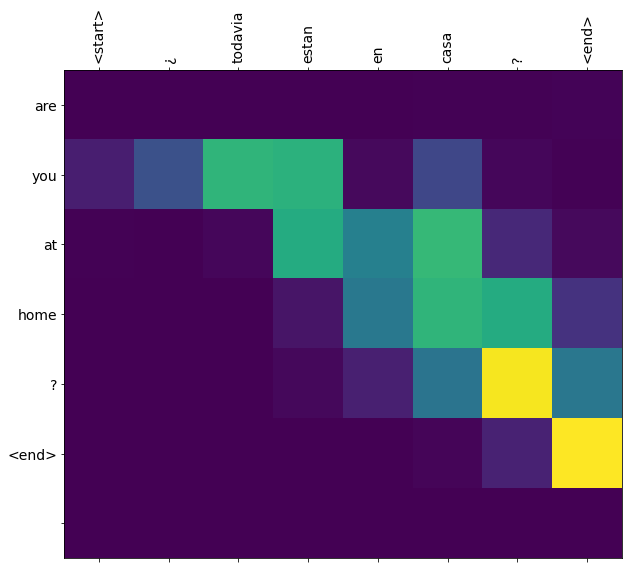

In [87]:
translate(u'¿todavia estan en casa?')

(16, 1024)
tf.Tensor(
[[-1.11555979e-02  1.63611565e-02  3.63596555e-05 ...  2.01929696e-02
   5.23264566e-03  2.73217596e-02]
 [-5.71860746e-02  8.95031393e-02 -8.41457248e-02 ...  1.29650727e-01
   1.40688986e-01  1.78372785e-01]
 [-4.43850681e-02  1.52928811e-02 -8.84535983e-02 ...  1.37008160e-01
  -8.19187909e-02 -3.68623137e-01]
 ...
 [ 1.77350305e-02 -4.07022893e-01 -8.83335412e-01 ...  9.97185469e-01
  -1.00570038e-01  9.94100153e-01]
 [ 1.62820648e-02 -4.04190302e-01 -8.69313598e-01 ...  9.97080803e-01
  -1.01043165e-01  9.97061431e-01]
 [ 1.55814951e-02 -4.01176929e-01 -8.57049704e-01 ...  9.97128367e-01
  -1.01538412e-01  9.97049093e-01]], shape=(16, 1024), dtype=float32)
The shape of 'attention_weights' is (1, 16, 1)
The shape of 'attention_weights' is (1, 16, 1)
The shape of 'attention_weights' is (1, 16, 1)
The shape of 'attention_weights' is (1, 16, 1)
The shape of 'attention_weights' is (1, 16, 1)
The shape of 'attention_weights' is (1, 16, 1)
The shape of 'attention_we

/Users/tamurataito/opt/anaconda3/envs/transformer_env/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()
/Users/tamurataito/opt/anaconda3/envs/transformer_env/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':


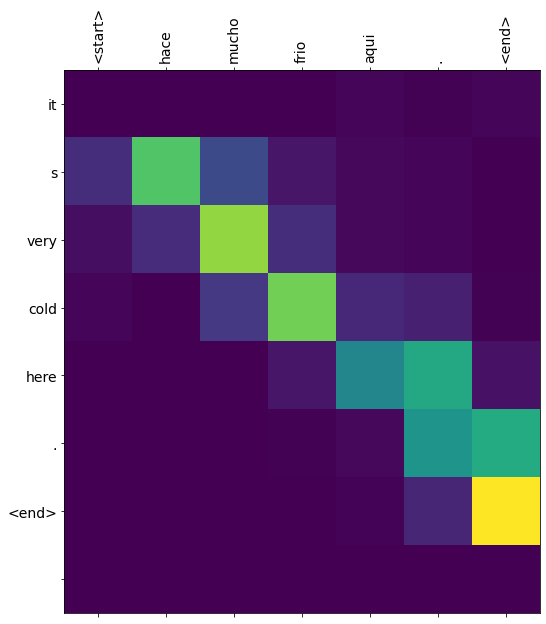

In [86]:
translate(u'hace mucho frio aqui.')

In [48]:
# checkpoint_dir の中の最後のチェックポイントを復元
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))